# Import


In [0]:
import gc
gc.collect()

0

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


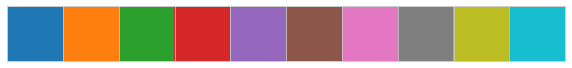

In [0]:
import numpy as np
import pandas as pd
import sklearn 
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import Ridge
from scipy.sparse import csr_matrix, hstack
from scipy.stats import probplot
import pickle
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline
import seaborn as sns 
import gc
import warnings
warnings.filterwarnings('ignore')
import time
from sklearn.model_selection import train_test_split

color = sns.color_palette()
sns.set_style("whitegrid")
sns.set_context("paper")
sns.palplot(color)

import os
import datetime

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
PATH = "../content/drive/My Drive/"

In [0]:
df = pd.read_csv(PATH+'train.csv', index_col = 0)

In [0]:
df.head()

,content,published,title,author,domain,tags,length,url,dow,year,month,hour,number_of_tags,target
0,Susan BrattonTrusted Hot Sex Advisor To Millio...,1970-01-01 00:00:00.001,Saving Your Marriage By Watching Steamy Sex Ed...,Susan Bratton,medium.com,Lovemaking Sex SexPositions EarlyBird SexEdVideos,5473,http://personallifemedia.com/2017/01/saving-ma...,3,1970,1,0,5,1.09861
1,"Ryo OoishiDec 31, 1969やってよかった中学受験明日から息子の中学受験がは...",1970-01-01 00:00:00.001,やってよかった中学受験,Ryo Ooishi,medium.com,NaN,5325,https://medium.com/@ooishi/%E3%82%84%E3%81%A3%...,3,1970,1,0,0,2.56495
2,なぞちゅう仮面ライダーとかスーパー戦隊を愛する30代。特撮はたしなむ程度（自称）色々なもの、...,1970-01-18 03:21:32.400,はてなブログに書いた今年の手帳のお話,なぞちゅう,medium.com,徒然日記 手帳 ブログ,2487,http://nazoblackrx.hatenablog.com/entry/2016/1...,6,1970,1,3,3,0.69315
3,"Internet Corporation LLCDec 8, 1987SPECIAL NOT...",1987-12-08 21:45:00.000,Internet Corporation LLC to Acquire Early Clue...,Internet Corporation LLC,medium.com,SocialMedia EarlyClues InternetCorporationLlc,11285,https://medium.com/the-internet-corporation/de...,1,1987,12,21,3,1.09861
4,"Mackenzie OldridgeDec 29, 2003g sowtwaretradin...",2003-12-29 17:00:00.000,g sowtwaretrading botMoneyMoneyMakeGetting To ...,Mackenzie Oldridge,medium.com,Finance Trading,12541,http://www.investopedia.com/articles/optioninv...,0,2003,12,17,2,3.52636


In [0]:
df_test = pd.read_csv(PATH+'test.csv', index_col = 0)
df_test.head()

,content,published,title,author,domain,tags,length,url,dow,year,month,hour,number_of_tags
0,Member previewHITRECORDhitrecord.org is a new ...,2018-02-21 17:01:00.928,"For Night Owls, the Day Starts with a Nocturna...",HITRECORD,medium.com,MorningRoutines Hitrecord Podcast Night,12500,https://medium.com/on-mornings/nocturnalmornin...,2,2018,2,17,4
1,Member previewMaria Bustillosis a journalist a...,2017-12-07 15:56:00.967,Blockchain is Memory,Maria Bustillos,medium.com,Blockchain Technology History Network WordsTha...,6703,https://medium.com/wordsthatmatter/never-break...,3,2017,12,15,5
2,HITRECORDhitrecord.org is a new kind of online...,2018-02-08 17:33:27.816,ON MORNINGS Credits,HITRECORD,medium.com,Medium Hitrecord OnMornings,6744,https://medium.com/on-mornings/onmorningscredi...,3,2018,2,17,3
3,"Member previewLance UlanoffTech expert, journa...",2018-02-09 18:04:12.262,Apple HomePod Review: Almost love,Lance Ulanoff,medium.com,Apple Homepod Technology Review Audio,12952,https://medium.com/@LanceUlanoff/apple-homepod...,4,2018,2,18,5
4,"MediumEveryone’s stories and ideasOct 2, 2017T...",2017-10-02 23:08:00.000,Tips and tricks for Medium writers,Medium,blog.medium.com,Medium Help Tips,5576,https://blog.medium.com/tips-and-tricks-for-me...,0,2017,10,23,3


# Exploratory data analysis

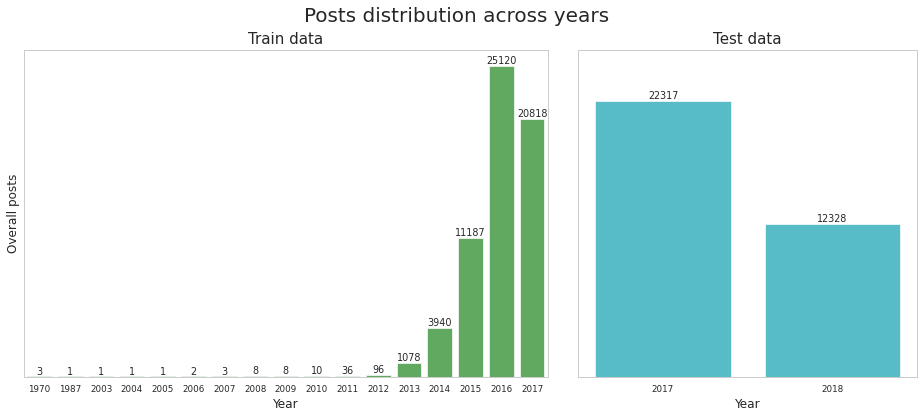

In [0]:
plt.figure(figsize=(16,6))
plt.suptitle("Posts distribution across years",fontsize=20)

ax1 = plt.subplot2grid((1,5),(0,0), colspan=3)
ax1 = sns.countplot(x='year', data=df, alpha=0.8, color=color[2])
plt.ylabel('Overall posts', fontsize=12)
plt.xlabel('Year', fontsize=12)
plt.title('Train data', fontsize=15)
plt.grid(False)

for p in ax1.patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax1.annotate('{}'.format(p.get_height()), (x.mean(), y), ha='center', va='bottom')
    
ax2 = plt.subplot2grid((1,5),(0,3), colspan=2, sharey=ax1)
ax2 = sns.countplot(x='year', data=df_test, alpha=0.8, color=color[9])
plt.xlabel('Year', fontsize=12)
plt.title('Test data', fontsize=15)
plt.yticks([])
plt.ylabel('')

for p in ax2.patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax2.annotate('{}'.format(p.get_height()), (x.mean(), y), ha='center', va='bottom')

In [0]:
# Большая часть выборки - это данные за 2016 и 2017 год, поэтому обрежем выборку по 2015 год
df = df[df['year']>= 2015]

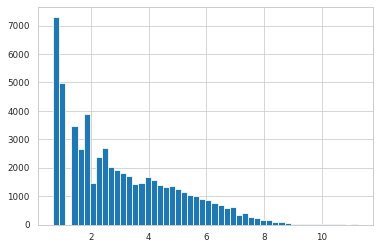

In [0]:
# Проанализируем Таргет
df['target'].hist(bins = 50)

Далеко от нормального распределения

In [0]:
# Информация по фичам (название, кол-во пропущенных значений, число унивкальных значений, питонячий тип)
pd.DataFrame({'Feature': df.columns.tolist(),
              'NaN_count': df.isna().sum().tolist(),
              'number_of_unique_elements': pd.Series(df.columns.tolist()).apply(lambda row: df[row].nunique()),
              'type': pd.Series(df.columns.tolist()).apply(lambda row: df[row].dtype)})

,Feature,NaN_count,number_of_unique_elements,type
0,content,0,57118,object
1,published,0,57031,object
2,title,0,56812,object
3,author,0,29557,object
4,domain,0,204,object
5,tags,2120,52218,object
6,length,0,18108,int64
7,url,0,57114,object
8,dow,0,7,int64
9,year,0,3,int64


In [0]:
df.describe()

,length,dow,year,month,hour,number_of_tags,target
count,55005.000000,55005.00000,55005.000000,55005.000000,55005.000000,55005.000000,55005.000000
mean,9870.366094,2.52937,2016.195909,5.915171,13.349732,3.999218,3.029522
std,9051.250599,1.86291,0.715349,3.400893,6.365220,1.086799,1.929194
min,205.000000,0.00000,2015.000000,1.000000,0.000000,1.000000,0.693150
25%,5960.000000,1.00000,2016.000000,3.000000,9.000000,3.000000,1.386290
50%,8059.000000,2.00000,2016.000000,5.000000,15.000000,4.000000,2.564950
75%,11254.000000,4.00000,2017.000000,9.000000,18.000000,5.000000,4.382030
max,423272.000000,6.00000,2017.000000,12.000000,23.000000,6.000000,11.251570


In [0]:
df.describe(include='object')

,content,title,author,domain,tags,url
count,55005,55005,55005,55005,55005,55005
unique,54998,54707,28624,200,52218,54994
top,Dev BattlesYoung Ukrainian startup for program...,10 Ideas Worth Sharing This Week,Jon Westenberg 🌈,medium.com,Startup Entrepreneurship,https://medium.com/@Stackspace/spark-geospatia...
freq,2,28,190,52314,58,2


In [0]:
df.corr()

,length,dow,year,month,hour,number_of_tags,target
length,1.000000,0.003403,-0.033256,0.011787,-0.002577,-0.014698,0.073477
dow,0.003403,1.000000,0.018261,-0.007992,-0.016493,0.004640,-0.031935
year,-0.033256,0.018261,1.000000,-0.508955,-0.005605,0.474119,-0.067909
month,0.011787,-0.007992,-0.508955,1.000000,-0.007658,0.013524,-0.001024
hour,-0.002577,-0.016493,-0.005605,-0.007658,1.000000,-0.001595,0.042028
number_of_tags,-0.014698,0.004640,0.474119,0.013524,-0.001595,1.000000,-0.007027
target,0.073477,-0.031935,-0.067909,-0.001024,0.042028,-0.007027,1.000000


## Работа с признаками

### Очистка данных

In [0]:
# Информация по фичам (название, кол-во пропущенных значений, число унивкальных значений, питонячий тип)
pd.DataFrame({'Feature': df.columns.tolist(),
              'NaN_count': df.isna().sum().tolist(),
              'number_of_unique_elements': pd.Series(df.columns.tolist()).apply(lambda row: df[row].nunique()),
              'type': pd.Series(df.columns.tolist()).apply(lambda row: df[row].dtype)})

,Feature,NaN_count,number_of_unique_elements,type
0,content,0,57118,object
1,published,0,57031,object
2,title,0,56812,object
3,author,0,29557,object
4,domain,0,204,object
5,tags,2120,52218,object
6,length,0,18108,int64
7,url,0,57114,object
8,dow,0,7,int64
9,year,0,3,int64


In [0]:
df['tags'].unique()

array([nan, 'Bulliednodamnmore Fiction AfricanAmerican',
       'ThisHappenedToMe', ...,
       'GenderEquality EqualRights SharedMission Constitution Perspective',
       'Dpc0213 TeoriaGeralDoProcesso Tgp ProcessoCivil',
       'Chile Etnografia ValleDeElqui Brujeria Postcolonial'],
      dtype=object)

In [0]:
df[df['tags'] == np.nan]

,content,published,title,author,domain,tags,length,url,dow,year,month,hour,number_of_tags,target


In [0]:
# Заменим пропущенные на -1
df['tags'] = df['tags'].fillna(-1)

In [0]:
# Удалим строки с пропущенными значениями
df = df[df['tags'] != -1]
# Обновим индексы
df = df.reset_index(drop=True)

In [0]:
# Удалим дубликаты 
df.drop_duplicates(keep=False, inplace = True)
# Обновим индексы
df = df.reset_index(drop=True)

### feature engineering

In [0]:
df['published'] = pd.to_datetime(df['published'])

In [0]:
# выделим сезонность 
seasons = {'winter': (1, 2, 12),
           'spring': (3, 4, 5),
           'summer': (6, 7, 8),
           'autumn': (9, 10, 11)}
           
df['season'] = df['month'].map({1: 'winter', 2: 'winter', 3: 'spring', 4: 'spring', 5: 'spring', 6: 'summer', 7: 'summer', 8: 'summer', 9: 'autumn', 10: 'autumn', 11: 'autumn', 12: 'winter'})

In [0]:
# Добавим день недели # 1 - пн, 7 - вскр
def get_day_of_the_week(day):
     return day.isoweekday() 

In [0]:
df['dayofweek'] = df.iloc[:,1].apply(get_day_of_the_week)

In [0]:
df['dayofweek'] = df['dayofweek'].map({1: 'monday', 2: 'tuesday', 3: 'wednesday', 4: 'thursday', 5: 'friday', 6: 'saturday', 7: 'sunday'})

In [0]:
df.head()

,content,published,title,author,domain,tags,length,url,dow,year,month,hour,number_of_tags,target,season,dayofweek
0,Alan JohnsonThe follow-up to THE BULLIED is BU...,2015-01-01 20:03:36.362,THE BULLIED,Alan Johnson,medium.com,Bulliednodamnmore Fiction AfricanAmerican,127120,https://medium.com/@alanjohnson/the-bullied-9e...,3,2015,1,20,3,0.69315,winter,thursday
1,"Allan ChochinovChair, MFA Products of Design a...",2015-01-02 02:04:07.732,"52,000 Knots",Allan Chochinov,medium.com,ThisHappenedToMe,37006,https://medium.com/re-form/fifty-three-thousan...,4,2015,1,2,1,4.93447,winter,friday
2,"The HairpinLadies first.Jan 2, 2015Ain’t No Fu...",2015-01-02 16:00:26.000,Ain’t No Fun If A Girl Can’t Have None,The Hairpin,medium.com,TheWomenOfOurYear Aaliyah DaBrat,6127,https://medium.com/the-hairpin/aint-no-fun-if-...,4,2015,1,16,3,0.69315,winter,friday
3,Conocerse es amarseEscribo en primera persona ...,2015-01-02 17:49:07.169,Expande tu consciencia y enriquece tu perspect...,Conocerse es amarse,medium.com,Constructivismo Psicologia Consciencia Desarro...,6672,https://medium.com/espanol/expande-tu-conscien...,4,2015,1,17,4,1.94591,winter,friday
4,Chris NordlingerPh.D. Fulbright Scholar. Story...,2015-01-02 22:59:12.812,3 Reasons that Apple Watch and others need hea...,Chris Nordlinger,medium.com,Wearables DigitalHealth Healthcare,11003,https://medium.com/@chrisnordlinger/wearables-...,4,2015,1,22,3,2.39790,winter,friday


In [0]:
# Выделим время публикации - утро/день/вечер/ночь
  # утро - 5-11
  # день - 12-17  
  # вечер - 18-23 
  # ночь - 0-5

In [0]:
df['partofday'] = df['hour'].map({0: 'night', 1: 'night', 2: 'night',
                                  3: 'night', 4: 'night', 5: 'morning',
                                  6: 'morning', 7: 'morning', 8: 'morning',
                                  9: 'morning', 10: 'morning', 11: 'morning',
                                  12: 'afternoon', 13: 'afternoon', 14: 'afternoon',
                                  15: 'afternoon', 16: 'afternoon', 17: 'afternoon',
                                  18: 'evening', 19: 'evening', 20: 'evening',
                                  21: 'evening', 22: 'evening', 23: 'evening'})

In [0]:
df.head()

,content,published,title,author,domain,tags,length,url,dow,year,month,hour,number_of_tags,target,season,dayofweek,partofday
0,Alan JohnsonThe follow-up to THE BULLIED is BU...,2015-01-01 20:03:36.362,THE BULLIED,Alan Johnson,medium.com,Bulliednodamnmore Fiction AfricanAmerican,127120,https://medium.com/@alanjohnson/the-bullied-9e...,3,2015,1,20,3,0.69315,winter,thursday,evening
1,"Allan ChochinovChair, MFA Products of Design a...",2015-01-02 02:04:07.732,"52,000 Knots",Allan Chochinov,medium.com,ThisHappenedToMe,37006,https://medium.com/re-form/fifty-three-thousan...,4,2015,1,2,1,4.93447,winter,friday,night
2,"The HairpinLadies first.Jan 2, 2015Ain’t No Fu...",2015-01-02 16:00:26.000,Ain’t No Fun If A Girl Can’t Have None,The Hairpin,medium.com,TheWomenOfOurYear Aaliyah DaBrat,6127,https://medium.com/the-hairpin/aint-no-fun-if-...,4,2015,1,16,3,0.69315,winter,friday,afternoon
3,Conocerse es amarseEscribo en primera persona ...,2015-01-02 17:49:07.169,Expande tu consciencia y enriquece tu perspect...,Conocerse es amarse,medium.com,Constructivismo Psicologia Consciencia Desarro...,6672,https://medium.com/espanol/expande-tu-conscien...,4,2015,1,17,4,1.94591,winter,friday,afternoon
4,Chris NordlingerPh.D. Fulbright Scholar. Story...,2015-01-02 22:59:12.812,3 Reasons that Apple Watch and others need hea...,Chris Nordlinger,medium.com,Wearables DigitalHealth Healthcare,11003,https://medium.com/@chrisnordlinger/wearables-...,4,2015,1,22,3,2.39790,winter,friday,evening


In [0]:
df.describe(include = 'object')

,content,title,author,domain,tags,url,season,dayofweek,partofday
count,55005,55005,55005,55005,55005,55005,55005,55005,55005
unique,54998,54707,28624,200,52218,54994,4,7,4
top,Richard BurtonBuilding Balance with some great...,10 Ideas Worth Sharing This Week,Jon Westenberg 🌈,medium.com,Startup Entrepreneurship,http://levvel.io/,spring,tuesday,afternoon
freq,2,28,190,52314,58,2,17863,9719,20328


In [0]:
# Информация по фичам (название, кол-во пропущенных значений, число унивкальных значений, питонячий тип)
pd.DataFrame({'Feature': df.columns.tolist(),
              'NaN_count': df.isna().sum().tolist(),
              'number_of_unique_elements': pd.Series(df.columns.tolist()).apply(lambda row: df[row].nunique()),
              'type': pd.Series(df.columns.tolist()).apply(lambda row: df[row].dtype)})

,Feature,NaN_count,number_of_unique_elements,type
0,content,0,54998,object
1,published,0,54913,datetime64[ns]
2,title,0,54707,object
3,author,0,28624,object
4,domain,0,200,object
5,tags,0,52218,object
6,length,0,17768,int64
7,url,0,54994,object
8,dow,0,7,int64
9,year,0,3,int64


### Графический анализ (с новыми признаками)

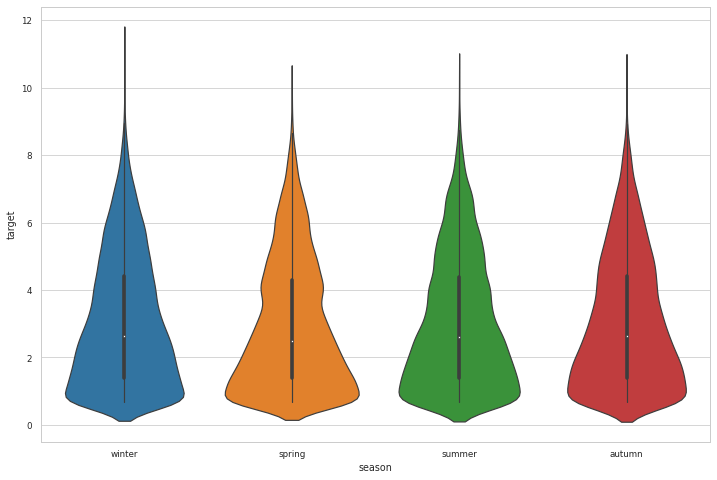

In [0]:
# Для рисунков
plt.rcParams['figure.figsize'] = (12,8)
sns.violinplot(df['season'], df['target']);

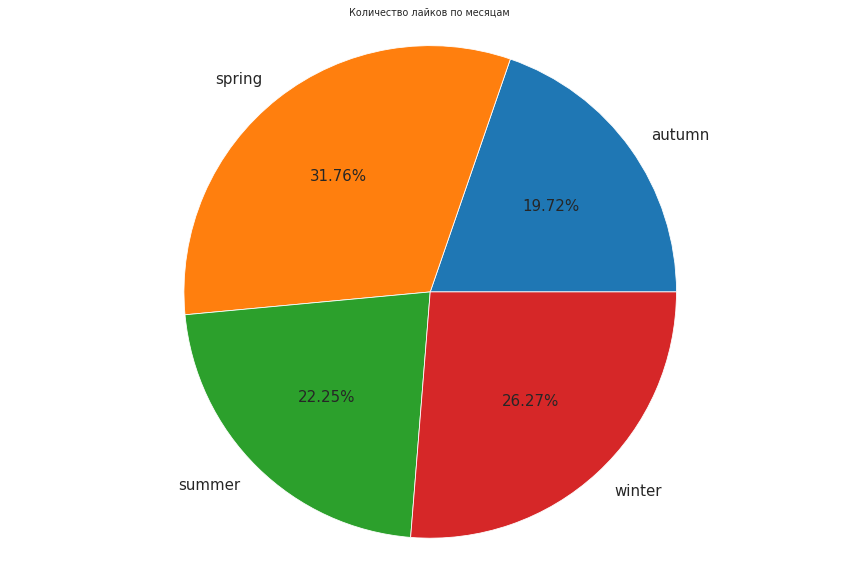

In [0]:
fig, ax = plt.subplots(1)
df['target'].groupby(df['season']).sum().plot(kind='pie',ax=ax, autopct='%.2f%%', fontsize=15)
ax.set_title('Количество лайков по сезонам')
ax.axis('equal')
ax.set_ylabel('')
plt.tight_layout();

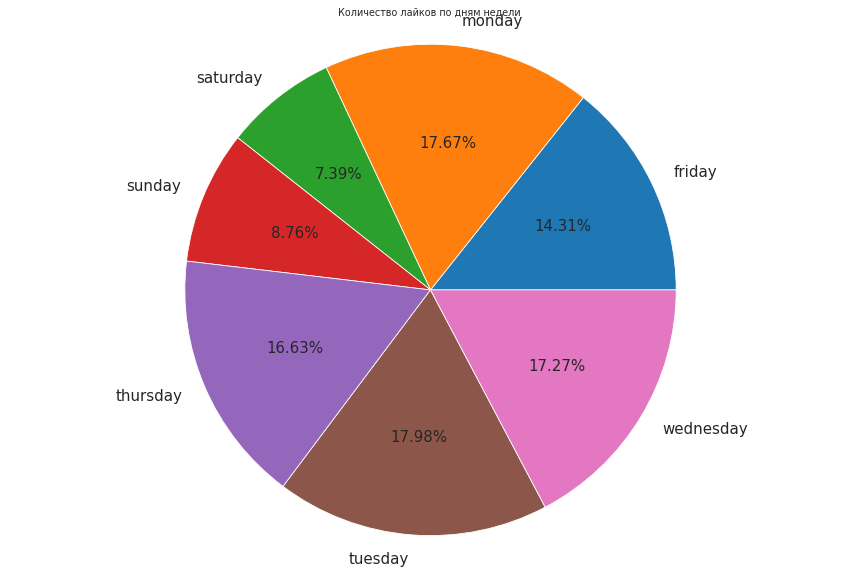

In [0]:
fig, ax = plt.subplots(1)
df['target'].groupby(df['dayofweek']).sum().plot(kind='pie',ax=ax, autopct='%.2f%%', fontsize=15)
ax.set_title('Количество лайков по дням недели')
ax.axis('equal')
ax.set_ylabel('')
plt.tight_layout();

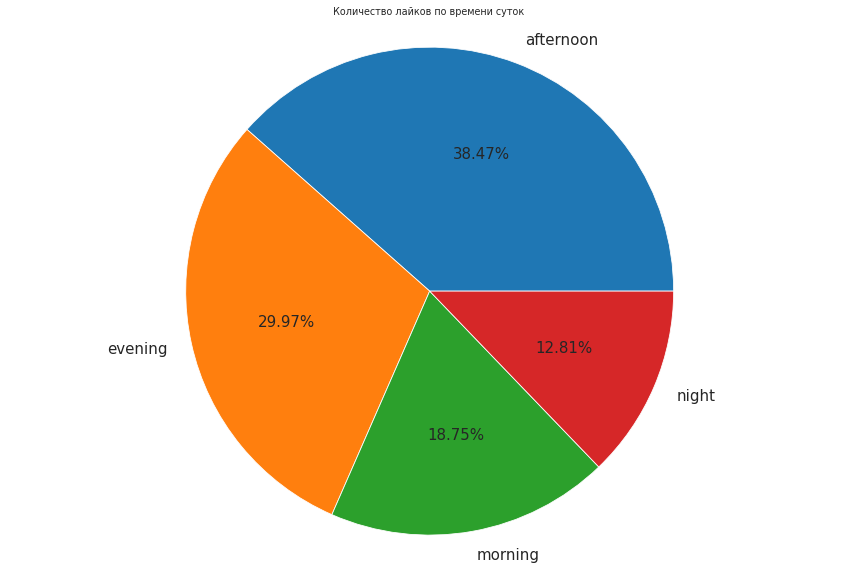

In [0]:
fig, ax = plt.subplots(1)
df['target'].groupby(df['partofday']).sum().plot(kind='pie',ax=ax, autopct='%.2f%%', fontsize=15)
ax.set_title('Количество лайков по времени суток')
ax.axis('equal')
ax.set_ylabel('')
plt.tight_layout();

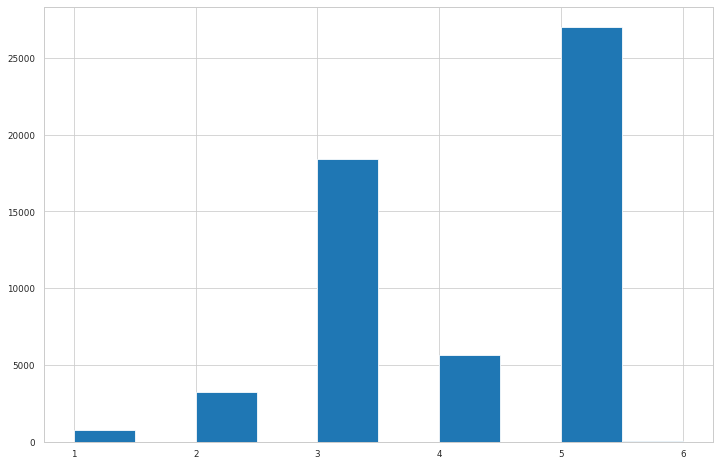

In [0]:
df['number_of_tags'].hist()

In [0]:
df[df['number_of_tags'] == 6] # 6 - максимальное число тэгов

,content,published,title,author,domain,tags,length,url,dow,year,month,hour,number_of_tags,target,season,dayofweek,partofday
13475,Netflix Technology BlogLearn more about how Ne...,2016-03-09 08:00:00.000,How We Build Code at Netflix,Netflix Technology Blog,medium.com,ContinuousIntegration Aminator AWS Bake Build ...,11390,http://techblog.netflix.com/2016/03/how-we-bui...,2,2016,3,8,6,6.04263,spring,wednesday,morning
18913,"Bruno AbarcaInternational Health BSc, MD, Publ...",2016-06-09 16:24:42.080,De héroes de la infancia y cintas de vídeo/a,Bruno Abarca,medium.com,Spanish Sexism Machismo Espanol Espanol Movies,12433,https://medium.com/de-las-distancias/de-h%C3%A...,3,2016,6,16,6,0.69315,summer,thursday,afternoon
20940,Candost DağdevireniOS/Software Developer. Tech...,2016-07-10 05:31:01.618,Bir kalifiye eleman Almanya’da nasıl çalışmaya...,Candost Dağdeviren,medium.com,Life Germany Jobs Work Turkce Turkce,14859,https://medium.com/@candost/bir-yazilimci-alma...,6,2016,7,5,6,5.48894,summer,sunday,morning
22273,Thomas BudimanIndonesian Product Designer · Co...,2016-07-29 07:44:05.013,Success Lessons I Learned from John Hanke,Thomas Budiman,medium.com,Life Success Entrepreneurship PokemonGo Pokemo...,5646,https://medium.com/@thomasbudiman/success-less...,4,2016,7,7,6,2.48491,summer,friday,morning
22299,Urban Resilience ProjectA changing climate mea...,2016-07-29 16:18:17.704,Too Hot for Pokemon Go? Use Your Phone to Figh...,Urban Resilience Project,medium.com,PokemonGo PokemonGo WomenInTech ClimateChange ...,4167,https://medium.com/@UrbanResilience/too-hot-fo...,4,2016,7,16,6,1.09861,summer,friday,afternoon
22458,"WNYCpodcasts, news & culture from New York Pub...",2016-08-01 13:31:03.147,The Future of Social Audio from WNYC,WNYC,medium.com,Podcast SocialMedia Radio Marketing OpenSource...,8541,https://medium.com/@WNYC/socialaudio-e648e8a5f2e9,0,2016,8,13,6,5.90808,summer,monday,afternoon
22794,Zach SupallaFounder/CEO of Particle (Internet ...,2016-08-05 12:01:02.630,A cellular-connected Pokéball for finding rare...,Zach Supalla,medium.com,Pokemon PokemonGo PokemonGo Hardware Arduino P...,2175,https://medium.com/particle-blog/cellular-conn...,4,2016,8,12,6,2.48491,summer,friday,afternoon
23829,"Rob WalkerRobWalker.netAug 20, 2016Pokémon Go ...",2016-08-20 20:23:43.933,Pokémon Go in the Lower Ninth Ward,Rob Walker,medium.com,NewOrleans Pokemongo PokemonGo PokemonGo Lower...,17805,https://medium.com/letters-from-here/pok%C3%A9...,5,2016,8,20,6,4.15888,summer,saturday,evening
29086,"ImmanuelTolstoyevskiFularsız EntellikOct 30, 2...",2016-10-31 00:00:00.000,Kariyerinizi Çöpe Atma Rehberi #4,ImmanuelTolstoyevski,medium.com,Turkce Turkce Turkish Kariyer Tavsiye KişiselG...,15311,http://fularsizentellik.com/journal/2016/10/31...,0,2016,10,0,6,4.24850,autumn,monday,night
44911,Andy FitzgeraldIndependent UX Architecture & D...,2017-04-05 18:34:57.414,Language Arts for the Lizard Brain: Vocabulary...,Andy Fitzgerald,medium.com,Design Linguistics Taxonomy UX Usability Cogni...,20291,https://medium.com/@andybywire/language-arts-f...,2,2017,4,18,6,2.07944,spring,wednesday,evening


In [0]:
df.iloc[0:1,:]

,content,published,title,author,domain,tags,length,url,dow,year,month,hour,number_of_tags,target,season,dayofweek,partofday
0,Alan JohnsonThe follow-up to THE BULLIED is BU...,2015-01-01 20:03:36.362,THE BULLIED,Alan Johnson,medium.com,Bulliednodamnmore Fiction AfricanAmerican,127120,https://medium.com/@alanjohnson/the-bullied-9e...,3,2015,1,20,3,0.69315,winter,thursday,evening


In [0]:
df_copy = df.copy()

In [0]:
df.loc[0,'tags']

'Bulliednodamnmore Fiction AfricanAmerican'

In [0]:
type(df.loc[0,'tags'])

str

Идея: Для 'length' ввести диапазоны длины

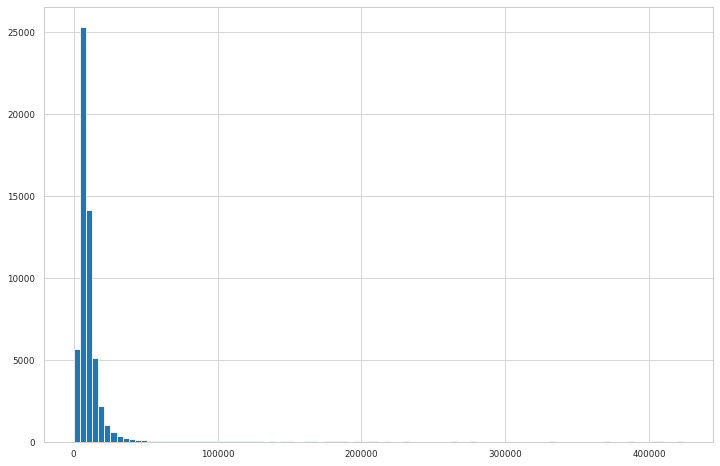

In [0]:
df['length'].hist(bins = 100)

In [0]:
df[df['length']>20000]

,content,published,title,author,domain,tags,length,url,dow,year,month,hour,number_of_tags,target,season,dayofweek,partofday
0,Alan JohnsonThe follow-up to THE BULLIED is BU...,2015-01-01 20:03:36.362,THE BULLIED,Alan Johnson,medium.com,Bulliednodamnmore Fiction AfricanAmerican,127120,https://medium.com/@alanjohnson/the-bullied-9e...,3,2015,1,20,3,0.69315,winter,thursday,evening
1,"Allan ChochinovChair, MFA Products of Design a...",2015-01-02 02:04:07.732,"52,000 Knots",Allan Chochinov,medium.com,ThisHappenedToMe,37006,https://medium.com/re-form/fifty-three-thousan...,4,2015,1,2,1,4.93447,winter,friday,night
8,manish nepalStir-crazy bum with an insatiable ...,2015-01-03 12:47:20.890,Tales from the Temple Town of Kathmandu,manish nepal,medium.com,Travel Globetrotter Nepal,24141,https://medium.com/@manishood/tales-from-the-t...,5,2015,1,12,3,1.09861,winter,saturday,afternoon
22,Dead Beat BooksWriters of Ruin Follow and Khro...,2015-01-05 16:51:33.290,Menagerie,Dead Beat Books,medium.com,Fiction RuinFollow SurrealScience,22688,https://medium.com/ruin-follow/menagerie-edc94...,0,2015,1,16,3,2.77259,winter,monday,afternoon
33,Jonathan Martinauthor of How to Survive a Ship...,2015-01-06 14:57:37.506,on going to (an episcopal) church.,Jonathan Martin,medium.com,EpiscopalChurch Liturgy Eucharist,21432,https://medium.com/@theboyonthebike/on-going-t...,1,2015,1,14,3,4.77068,winter,tuesday,afternoon
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54900,Jenny Odellamateur birdnoticer • • • www.jenny...,2017-06-30 03:46:01.508,how to do nothing,Jenny Odell,medium.com,Art Birds Oakland,61448,https://medium.com/@the_jennitaur/how-to-do-no...,4,2017,6,3,3,8.93604,summer,friday,night
54915,"Mohit MamoriaCEO, Authorito Capital (https://a...",2017-06-30 07:55:55.103,WTF is The Blockchain?,Mohit Mamoria,hackernoon.com,Bitcoin Blockchain Ethereum Inspiration Crypto...,20280,https://hackernoon.com/wtf-is-the-blockchain-1...,4,2017,6,7,5,10.20363,summer,friday,morning
54920,Ellen OsborneLearning about system change. Cul...,2017-06-30 09:16:00.988,IO Collective — the ASHA chronicles,Ellen Osborne,medium.com,IoCollective Cocreation Collaboration Transfor...,20599,https://medium.com/io-collective/io-collective...,4,2017,6,9,5,2.83321,summer,friday,morning
54987,"Autodesk UniversityLearn, connect, explore. Th...",2017-06-30 19:36:15.651,Custom Homes in Revit: The Tools to Succeed,Autodesk University,medium.com,Architecture Bim CustomHomeDesigns Construction,23888,https://medium.com/autodesk-university/custom-...,4,2017,6,19,4,0.69315,summer,friday,evening


In [0]:
df['length'].describe()

count     55005.000000
mean       9870.366094
std        9051.250599
min         205.000000
25%        5960.000000
50%        8059.000000
75%       11254.000000
max      423272.000000
Name: length, dtype: float64

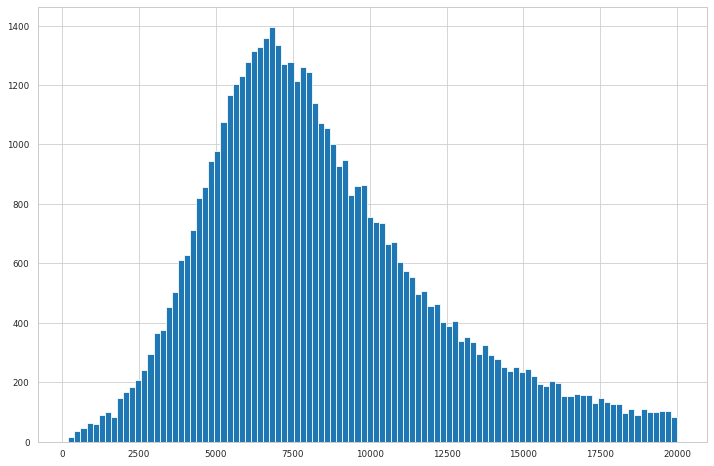

In [0]:
df[df['length']<20000]['length'].hist(bins= 100)

Посмотрим, сколько лайков у статей больших

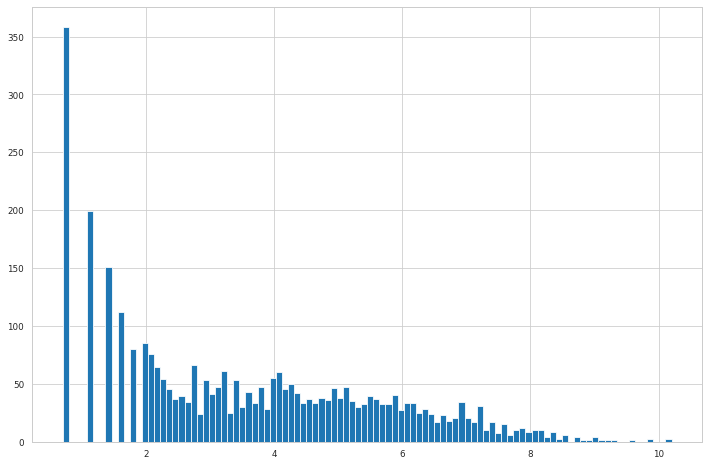

In [0]:
df[df['length']>20000]['target'].hist(bins= 100)

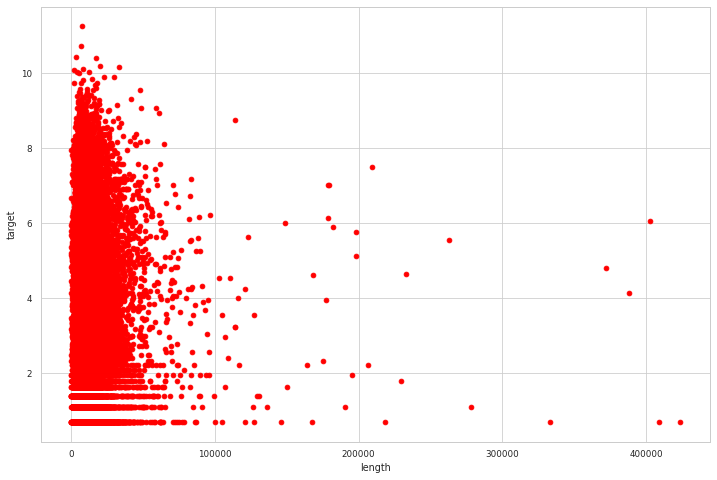

In [0]:
# нужно понять, как зависимость лайков и длины статьи
x = df['length'].copy()
y = df['target'].copy()
plt.xlabel('length')
plt.ylabel('target')

plt.scatter(x, y, c='red')

In [0]:
df[df['length'] >= 20000 ]

,content,published,title,author,domain,tags,length,url,dow,year,month,hour,number_of_tags,target,season,dayofweek,partofday
0,Alan JohnsonThe follow-up to THE BULLIED is BU...,2015-01-01 20:03:36.362,THE BULLIED,Alan Johnson,medium.com,Bulliednodamnmore Fiction AfricanAmerican,127120,https://medium.com/@alanjohnson/the-bullied-9e...,3,2015,1,20,3,0.69315,winter,thursday,evening
1,"Allan ChochinovChair, MFA Products of Design a...",2015-01-02 02:04:07.732,"52,000 Knots",Allan Chochinov,medium.com,ThisHappenedToMe,37006,https://medium.com/re-form/fifty-three-thousan...,4,2015,1,2,1,4.93447,winter,friday,night
8,manish nepalStir-crazy bum with an insatiable ...,2015-01-03 12:47:20.890,Tales from the Temple Town of Kathmandu,manish nepal,medium.com,Travel Globetrotter Nepal,24141,https://medium.com/@manishood/tales-from-the-t...,5,2015,1,12,3,1.09861,winter,saturday,afternoon
22,Dead Beat BooksWriters of Ruin Follow and Khro...,2015-01-05 16:51:33.290,Menagerie,Dead Beat Books,medium.com,Fiction RuinFollow SurrealScience,22688,https://medium.com/ruin-follow/menagerie-edc94...,0,2015,1,16,3,2.77259,winter,monday,afternoon
33,Jonathan Martinauthor of How to Survive a Ship...,2015-01-06 14:57:37.506,on going to (an episcopal) church.,Jonathan Martin,medium.com,EpiscopalChurch Liturgy Eucharist,21432,https://medium.com/@theboyonthebike/on-going-t...,1,2015,1,14,3,4.77068,winter,tuesday,afternoon
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54900,Jenny Odellamateur birdnoticer • • • www.jenny...,2017-06-30 03:46:01.508,how to do nothing,Jenny Odell,medium.com,Art Birds Oakland,61448,https://medium.com/@the_jennitaur/how-to-do-no...,4,2017,6,3,3,8.93604,summer,friday,night
54915,"Mohit MamoriaCEO, Authorito Capital (https://a...",2017-06-30 07:55:55.103,WTF is The Blockchain?,Mohit Mamoria,hackernoon.com,Bitcoin Blockchain Ethereum Inspiration Crypto...,20280,https://hackernoon.com/wtf-is-the-blockchain-1...,4,2017,6,7,5,10.20363,summer,friday,morning
54920,Ellen OsborneLearning about system change. Cul...,2017-06-30 09:16:00.988,IO Collective — the ASHA chronicles,Ellen Osborne,medium.com,IoCollective Cocreation Collaboration Transfor...,20599,https://medium.com/io-collective/io-collective...,4,2017,6,9,5,2.83321,summer,friday,morning
54987,"Autodesk UniversityLearn, connect, explore. Th...",2017-06-30 19:36:15.651,Custom Homes in Revit: The Tools to Succeed,Autodesk University,medium.com,Architecture Bim CustomHomeDesigns Construction,23888,https://medium.com/autodesk-university/custom-...,4,2017,6,19,4,0.69315,summer,friday,evening


In [0]:
# Удалим слишком длинные статьи
df = df[df['length'] <= 20000 ]

In [0]:
# Обновим индексы
df = df.reset_index(drop=True)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f14af8582b0>,
      dtype=object)

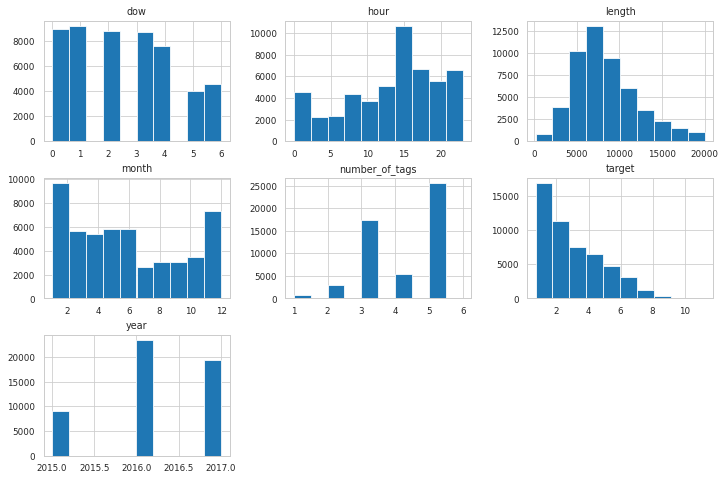

In [0]:
df.hist()

In [0]:
df_copy = df.copy()

In [0]:
# прологарифмируем 'target'
df['target_log'] = np.log1p(df['target'])

In [0]:
df.head()

,content,published,title,author,domain,tags,length,url,dow,year,month,hour,number_of_tags,target,season,dayofweek,partofday,target_log
0,"The HairpinLadies first.Jan 2, 2015Ain’t No Fu...",2015-01-02 16:00:26.000,Ain’t No Fun If A Girl Can’t Have None,The Hairpin,medium.com,TheWomenOfOurYear Aaliyah DaBrat,6127,https://medium.com/the-hairpin/aint-no-fun-if-...,4,2015,1,16,3,0.69315,winter,friday,afternoon,0.526591
1,Conocerse es amarseEscribo en primera persona ...,2015-01-02 17:49:07.169,Expande tu consciencia y enriquece tu perspect...,Conocerse es amarse,medium.com,Constructivismo Psicologia Consciencia Desarro...,6672,https://medium.com/espanol/expande-tu-conscien...,4,2015,1,17,4,1.94591,winter,friday,afternoon,1.080418
2,Chris NordlingerPh.D. Fulbright Scholar. Story...,2015-01-02 22:59:12.812,3 Reasons that Apple Watch and others need hea...,Chris Nordlinger,medium.com,Wearables DigitalHealth Healthcare,11003,https://medium.com/@chrisnordlinger/wearables-...,4,2015,1,22,3,2.39790,winter,friday,evening,1.223158
3,"Dale MugfordCo-founder of BraveNewCode, we mak...",2015-01-03 00:57:56.968,DIY Fusion Drives — The Right Way,Dale Mugford,medium.com,Fusion Mac Apple,10429,https://medium.com/@dalemugford/diy-fusion-dri...,5,2015,1,0,3,2.07944,winter,saturday,night,1.124748
4,"Henry WardCEO at CartaJan 2, 2015Broken cap ta...",2015-01-03 03:59:17.433,Broken cap tables,Henry Ward,medium.com,Henry Startup CapTable Investors Insightseshares,10496,https://blog.esharesinc.com/broken-cap-tables/,5,2015,1,3,5,5.94280,winter,saturday,night,1.937705


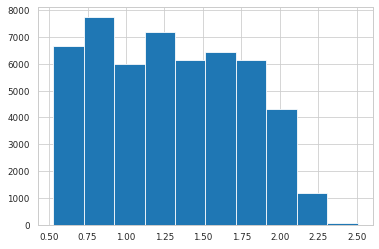

In [0]:
df['target_log'].hist()

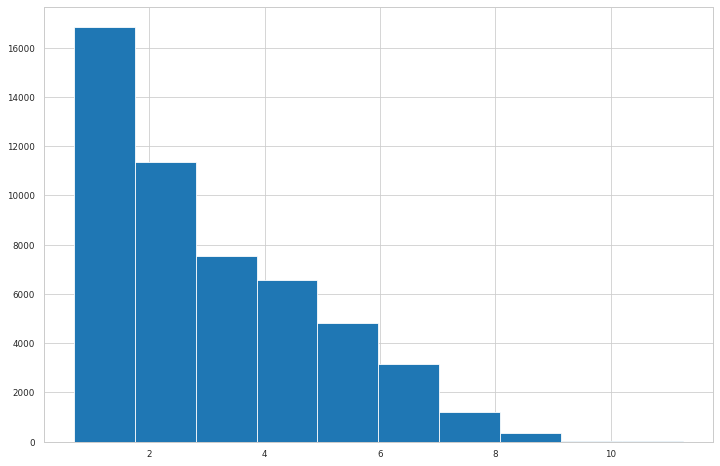

In [0]:
df['target'].hist()

In [0]:
df_copy = df.copy()

In [0]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51790 entries, 0 to 51789
Data columns (total 18 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   content         51790 non-null  object        
 1   published       51790 non-null  datetime64[ns]
 2   title           51790 non-null  object        
 3   author          51790 non-null  object        
 4   domain          51790 non-null  object        
 5   tags            51790 non-null  object        
 6   length          51790 non-null  int64         
 7   url             51790 non-null  object        
 8   dow             51790 non-null  int64         
 9   year            51790 non-null  int64         
 10  month           51790 non-null  int64         
 11  hour            51790 non-null  int64         
 12  number_of_tags  51790 non-null  int64         
 13  target          51790 non-null  float64       
 14  season          51790 non-null  object        
 15  da

In [0]:
df['target_log'].describe()

count    51790.000000
mean         1.272031
std          0.481696
min          0.526591
25%          0.869740
50%          1.271150
75%          1.673488
max          2.505654
Name: target_log, dtype: float64

#### Добавим признак "выходные или будние?" 

In [0]:
# Добавим день недели # 1 - пн, 7 - вскр
def get_day_type(day):
  res = ''
  if day == 6 or day == 7:
    res = 'weekend'
  else: 
    res = 'workday'
  return res

In [0]:
df['day_type'] = df['dow'].apply(get_day_type)

### Аналитика тэгов

In [0]:
# превратим тэги в вектора
cv_tags = CountVectorizer(ngram_range=(1, 1), min_df=5) # ngram_range=(1, 1) - униграмма (последовательность из 1 слова), min_df=5 - не берем слова, частота встречаемости которых меньше 5
tags = cv_tags.fit_transform(df.tags.values).toarray() # выдает рязряженную матрицу  - переведем в массив

In [0]:
df.tags.values

array(['TheWomenOfOurYear Aaliyah DaBrat',
       'Constructivismo Psicologia Consciencia DesarrolloPersonal',
       'Wearables DigitalHealth Healthcare', ..., 'Tr724Yorum Tr724',
       'Dpc0213 TeoriaGeralDoProcesso Tgp ProcessoCivil',
       'Chile Etnografia ValleDeElqui Brujeria Postcolonial'],
      dtype=object)

In [0]:
len(df.tags.values)

51790

In [0]:
tags # закодированные тэги 

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [0]:
tags.sum(axis=0)

array([ 17,   5,   8, ...,   5,   8, 116])

In [0]:
tags[0]

array([0, 0, 0, ..., 0, 0, 0])

In [0]:
tags.shape

(51790, 4484)

In [0]:
matrix_freq = tags.sum(axis=0).ravel() # матрица частот тэгов. Ravel() - делает плоский массив (в строку)
tags_freq = np.array([np.array(cv_tags.get_feature_names()), matrix_freq]) # объединяем в 2мерный массив - тэг [0] и его частота [1]

In [0]:
matrix_freq

array([ 17,   5,   8, ...,   5,   8, 116])

In [0]:
tags_freq

array([['13reasonswhy', '1960s', '1980s', ..., '區塊鏈', '建築', '日本語'],
       ['17', '5', '8', ..., '5', '8', '116']], dtype='<U25')

In [0]:
# для аналитики лайков по тэгам 
df_tags = pd.DataFrame()
df_tags['tag'] = tags_freq[0]
df_tags['number_of_posts'] = tags_freq[1]

In [0]:
df_tags

,tag,number_of_posts
0,13reasonswhy,17
1,1960s,5
2,1980s,8
3,1mdb,7
4,2015,24
...,...,...
4479,デザイン,11
4480,ライター,6
4481,區塊鏈,5
4482,建築,8


In [0]:
df_tags_ar = pd.DataFrame(tags)
df_tags_ar['target'] = df.target.values
for col in range(df_tags_ar.shape[1]-1):
    temp=df_tags_ar[df_tags_ar[col]==1]
    df_tags.loc[col,'mean_claps']=temp['target'].mean()
    df_tags.loc[col,'sum_claps']=temp['target'].sum()
    
df_tags['tag'] = df_tags['tag'].astype(str)
df_tags['number_of_posts'] = df_tags['number_of_posts'].astype(int)

In [0]:
df_tags_ar

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,4445,4446,4447,4448,4449,4450,4451,4452,4453,4454,4455,4456,4457,4458,4459,4460,4461,4462,4463,4464,4465,4466,4467,4468,4469,4470,4471,4472,4473,4474,4475,4476,4477,4478,4479,4480,4481,4482,4483,target
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.69315
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.94591
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2.39790
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2.07944
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5.94280
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51785,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.38629
51786,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2.77259
51787,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.38629
51788,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.09861


In [0]:
df_tags

,tag,number_of_posts,mean_claps,sum_claps
0,13reasonswhy,17,2.288260,38.90042
1,1960s,5,1.352314,6.76157
2,1980s,8,3.972799,31.78239
3,1mdb,7,2.435577,17.04904
4,2015,24,2.754372,66.10493
...,...,...,...,...
4479,デザイン,11,1.786849,19.65534
4480,ライター,6,1.704550,10.22730
4481,區塊鏈,5,4.350860,21.75430
4482,建築,8,1.608296,12.86637


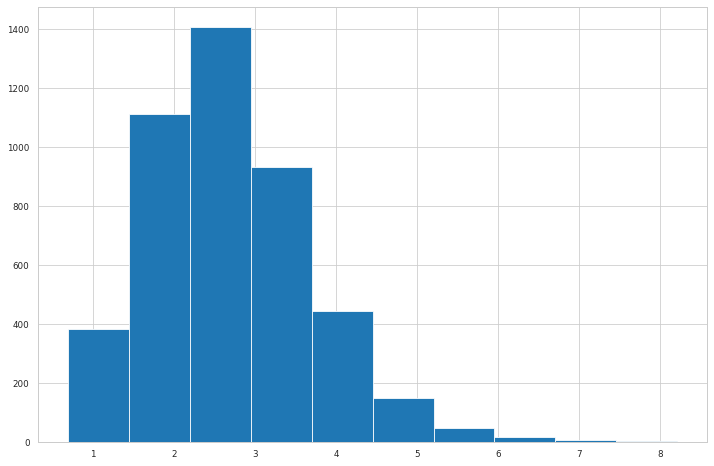

In [0]:
df_tags['mean_claps'].hist()

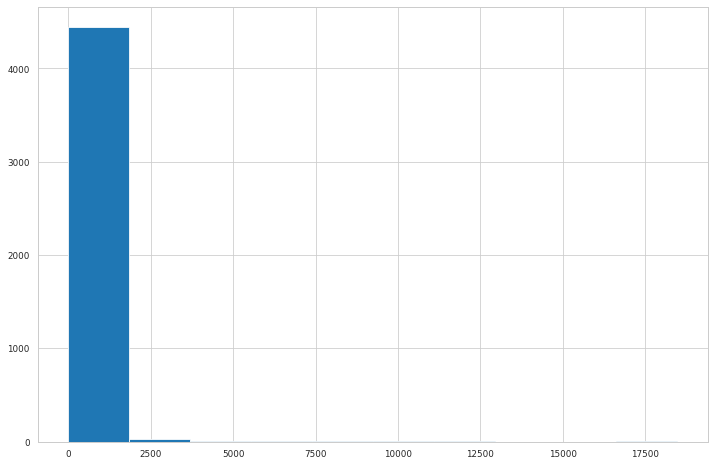

In [0]:
df_tags['sum_claps'].hist()

In [0]:
df_tags.describe()

,number_of_posts,mean_claps,sum_claps
count,4484.000000,4484.000000,4484.000000
mean,37.355486,2.682588,119.502307
std,150.874108,0.971372,567.191736
min,5.000000,0.693150,3.465750
25%,6.000000,1.994679,14.598068
50%,9.000000,2.579357,25.152420
75%,20.000000,3.268530,57.640895
max,4885.000000,8.211510,18469.788470


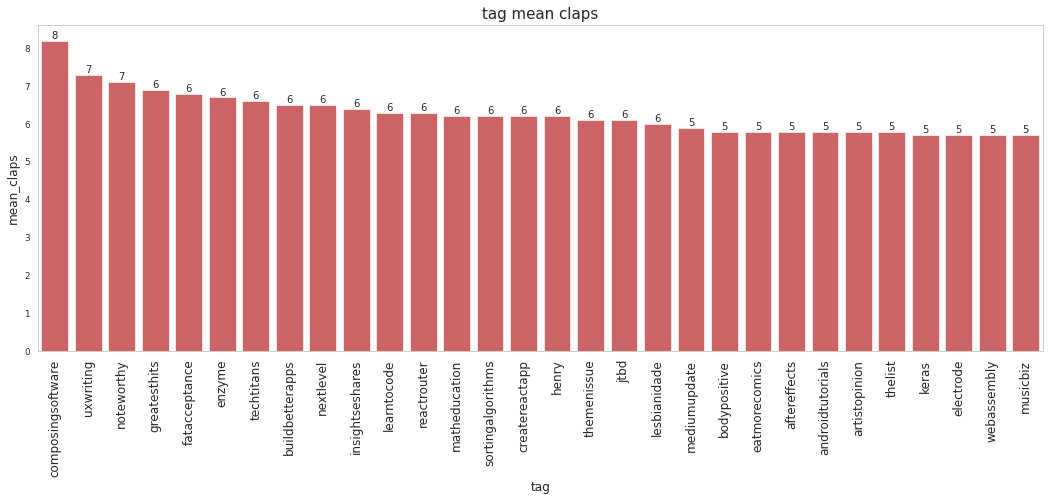

In [0]:
plt.figure(figsize=(18,6))

temp = df_tags.sort_values('mean_claps', ascending=False).iloc[:30]
ax1 = sns.barplot(temp['tag'],np.round(temp['mean_claps'], 1), alpha=0.8, color=color[3])
plt.ylabel('mean_claps', fontsize=12)
plt.xlabel('tag', fontsize=12)
plt.title('tag mean claps', fontsize=15)
plt.grid(False)
plt.xticks(rotation=90, fontsize=12)

for p in ax1.patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax1.annotate('{}'.format(int(p.get_height())), (x.mean(), y), ha='center', va='bottom')
    

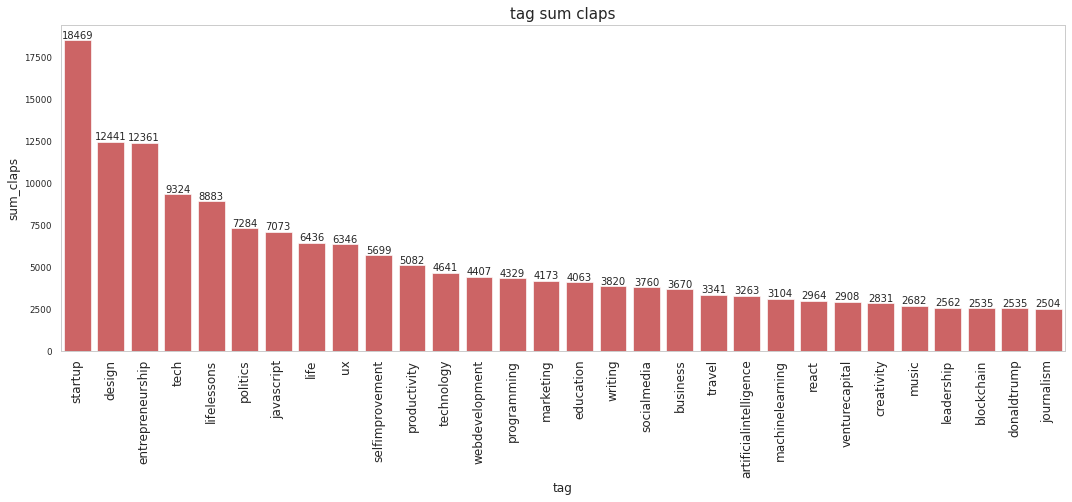

In [0]:
plt.figure(figsize=(18,6))

temp = df_tags.sort_values('sum_claps', ascending=False).iloc[:30]
ax1 = sns.barplot(temp['tag'],np.round(temp['sum_claps'], 1), alpha=0.8, color=color[3])
plt.ylabel('sum_claps', fontsize=12)
plt.xlabel('tag', fontsize=12)
plt.title('tag sum claps', fontsize=15)
plt.grid(False)
plt.xticks(rotation=90, fontsize=12)

for p in ax1.patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax1.annotate('{}'.format(int(p.get_height())), (x.mean(), y), ha='center', va='bottom')

In [0]:
# Попробуем через TfidfVectorizer - не получается, сессия crash 
# create the transform
# tfid = TfidfVectorizer()
# tokenize and build vocab
#  tags_tfid = tfid.fit_transform(df.tags.values).toarray()

# Попробуем через HashingVectorizer 
hashvect = HashingVectorizer(n_features=50)
# encode document
tags_hashvect = hashvect.fit_transform(df.tags.values).toarray()
# рез-тат хуже - 2 

In [0]:
tags_hashvect

array([[0. , 0. , 0. , ..., 0. , 0. , 0. ],
       [0. , 0. , 0. , ..., 0. , 0. , 0. ],
       [0. , 0. , 0. , ..., 0. , 0. , 0. ],
       ...,
       [0. , 0. , 0. , ..., 0. , 0. , 0. ],
       [0. , 0.5, 0. , ..., 0. , 0. , 0. ],
       [0. , 0. , 0. , ..., 0. , 0. , 0. ]])

In [0]:
tags_hashvect.shape

(51790, 50)

In [0]:
matrix_freq_hashvect = tags_hashvect.sum(axis=0).ravel() # матрица частот тэгов. Ravel() - делает плоский массив (в строку)
matrix_freq_hashvect

array([  732.33854081,   866.77476179,  -133.54516495,  -129.10174434,
         116.7687692 ,    55.49371195,   415.33360492,  1076.82829729,
         797.29968579,  -176.48515969,   -36.3342832 ,   980.15438807,
        -229.49192952,  -398.23958288,   170.49748353,  -931.48199774,
         140.98463648,  -184.55537803,  -132.98611668, -4088.10972436,
         -15.49934681,  -571.22153025,   342.18349243,   -70.04909889,
        -661.29599185,  -190.12929049,   273.50424534,  -586.83368682,
        -599.34570681, -1644.73293168,  -474.344274  ,  -752.39934353,
          97.45887193,  -241.11454538,    25.77125609,   -84.43309268,
        1661.75106436,  1998.86125638,   411.77059642,   225.58282425,
         214.48116285,   -19.37926782,    -8.58947158,  -132.48873501,
        1241.81904537,  -199.31966805,   -45.16833247,  -344.65193545,
          20.99014228,   152.76888225])

#### Добавим признак "Частота тэгов" 

топовый - самый частый 

In [0]:
df.head()

,content,published,title,author,domain,tags,length,url,dow,year,month,hour,number_of_tags,target,season,dayofweek,partofday,target_log,domain_top,author_wo_space
0,"The HairpinLadies first.Jan 2, 2015Ain’t No Fu...",2015-01-02 16:00:26.000,Ain’t No Fun If A Girl Can’t Have None,The Hairpin,medium.com,TheWomenOfOurYear Aaliyah DaBrat,6127,https://medium.com/the-hairpin/aint-no-fun-if-...,4,2015,1,16,3,0.69315,winter,friday,afternoon,0.526591,medium,TheHairpin
1,Conocerse es amarseEscribo en primera persona ...,2015-01-02 17:49:07.169,Expande tu consciencia y enriquece tu perspect...,Conocerse es amarse,medium.com,Constructivismo Psicologia Consciencia Desarro...,6672,https://medium.com/espanol/expande-tu-conscien...,4,2015,1,17,4,1.94591,winter,friday,afternoon,1.080418,medium,Conocerseesamarse
2,Chris NordlingerPh.D. Fulbright Scholar. Story...,2015-01-02 22:59:12.812,3 Reasons that Apple Watch and others need hea...,Chris Nordlinger,medium.com,Wearables DigitalHealth Healthcare,11003,https://medium.com/@chrisnordlinger/wearables-...,4,2015,1,22,3,2.39790,winter,friday,evening,1.223158,medium,ChrisNordlinger
3,"Dale MugfordCo-founder of BraveNewCode, we mak...",2015-01-03 00:57:56.968,DIY Fusion Drives — The Right Way,Dale Mugford,medium.com,Fusion Mac Apple,10429,https://medium.com/@dalemugford/diy-fusion-dri...,5,2015,1,0,3,2.07944,winter,saturday,night,1.124748,medium,DaleMugford
4,"Henry WardCEO at CartaJan 2, 2015Broken cap ta...",2015-01-03 03:59:17.433,Broken cap tables,Henry Ward,medium.com,Henry Startup CapTable Investors Insightseshares,10496,https://blog.esharesinc.com/broken-cap-tables/,5,2015,1,3,5,5.94280,winter,saturday,night,1.937705,medium,HenryWard


создадим таблу "Тэг - кол-во статей с ним" 

In [0]:
cv_tags = CountVectorizer(ngram_range=(1, 1), min_df=5) # ngram_range=(1, 1) - униграмма (последовательность из 1 слова), min_df=5 - не берем слова, частота встречаемости которых меньше 5
tags = cv_tags.fit_transform(df.tags.values).toarray() 

In [0]:
matrix_freq = tags.sum(axis=0).ravel() # матрица частот тэгов. Ravel() - делает плоский массив (в строку)
tags_freq = np.array([np.array(cv_tags.get_feature_names()), matrix_freq]) # объединяем в 2мерный массив - тэг [0] и его частота [1]

In [0]:
# для аналитики лайков по тэгам 
df_tags = pd.DataFrame()
df_tags['tag'] = tags_freq[0]
df_tags['number_of_posts'] = tags_freq[1]

In [0]:
df_tags.head()

,tag,number_of_posts
0,13reasonswhy,17
1,1960s,5
2,1980s,8
3,1mdb,7
4,2015,24


In [0]:
df_tags.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4484 entries, 0 to 4483
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   tag              4484 non-null   object
 1   number_of_posts  4484 non-null   object
dtypes: object(2)
memory usage: 70.2+ KB


In [0]:
df_tags['number_of_posts'] = df_tags['number_of_posts'].astype(int)
df_tags['tag'] = df_tags['tag'].astype(str)

In [0]:
df_tags.sort_values(by = 'number_of_posts', inplace = True, ascending =  False)
df_tags = df_tags.reset_index(drop=True)

In [0]:
df_tags.head()

,tag,number_of_posts
0,startup,4885
1,design,3177
2,entrepreneurship,3147
3,politics,2388
4,tech,2302


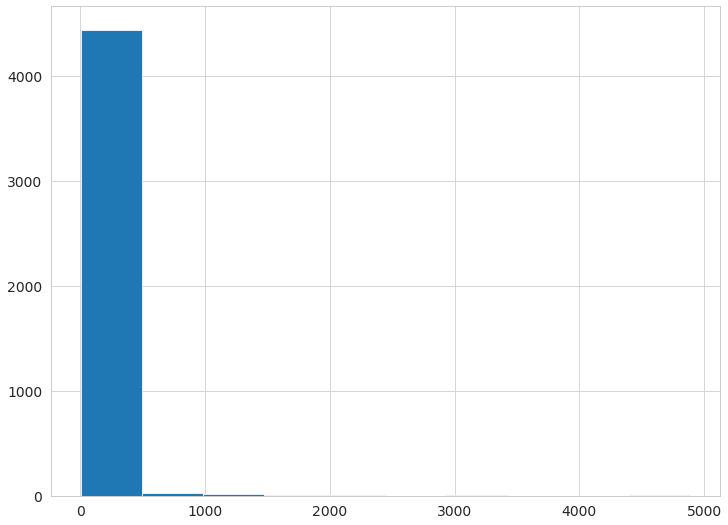

In [0]:
df_tags['number_of_posts'].hist

Добавим в df: Ожидаемый рейтинг = сум(Частота iого тэга статьи)  

In [0]:
len(df.loc[1, 'tags'].split())

4

In [0]:
int(len(df.loc[i, 'tags'].split())) 

4

In [0]:
int(df_tags[df_tags['tag'] == 'constructivismo']['number_of_posts'])

TypeError: ignored

In [0]:
def get_num_freq_tags(instr):
  list_tag = instr.split()
  cnt_freq = 0 
  tmp = []
  # in df_tags нет тэгов, которые встречаются меньше 5 раз 
  for i in list_tag:
      tmp = df_tags[df_tags['tag'] == str.lower(i)]['number_of_posts']
      #print(tmp)
      try:
        tmp_num = int(tmp)
      except: 
        tmp_num = 1 
      #print(tmp_num)
      cnt_freq = cnt_freq + tmp_num
      #print(cnt_freq)
  return cnt_freq


In [0]:
instr = df.loc[4, 'tags']
get_num_freq_tags(instr)

4922

In [0]:
# Применим ко всему датасэту 
df['tags_freq'] = df['tags'].apply(get_num_freq_tags)

In [0]:
df.loc[4, :]

content            Henry WardCEO at CartaJan 2, 2015Broken cap ta...
published                                    2015-01-03 03:59:17.433
title                                              Broken cap tables
author                                                    Henry Ward
domain                                                    medium.com
tags                Henry Startup CapTable Investors Insightseshares
length                                                         10496
url                   https://blog.esharesinc.com/broken-cap-tables/
dow                                                                5
year                                                            2015
month                                                              1
hour                                                               3
number_of_tags                                                     5
target                                                        5.9428
season                            

In [0]:
df.head()

,content,published,title,author,domain,tags,length,url,dow,year,month,hour,number_of_tags,target,season,dayofweek,partofday,target_log,domain_top,author_wo_space,tags_freq
0,"The HairpinLadies first.Jan 2, 2015Ain’t No Fu...",2015-01-02 16:00:26.000,Ain’t No Fun If A Girl Can’t Have None,The Hairpin,medium.com,TheWomenOfOurYear Aaliyah DaBrat,6127,https://medium.com/the-hairpin/aint-no-fun-if-...,4,2015,1,16,3,0.69315,winter,friday,afternoon,0.526591,medium,TheHairpin,0
1,Conocerse es amarseEscribo en primera persona ...,2015-01-02 17:49:07.169,Expande tu consciencia y enriquece tu perspect...,Conocerse es amarse,medium.com,Constructivismo Psicologia Consciencia Desarro...,6672,https://medium.com/espanol/expande-tu-conscien...,4,2015,1,17,4,1.94591,winter,friday,afternoon,1.080418,medium,Conocerseesamarse,40
2,Chris NordlingerPh.D. Fulbright Scholar. Story...,2015-01-02 22:59:12.812,3 Reasons that Apple Watch and others need hea...,Chris Nordlinger,medium.com,Wearables DigitalHealth Healthcare,11003,https://medium.com/@chrisnordlinger/wearables-...,4,2015,1,22,3,2.39790,winter,friday,evening,1.223158,medium,ChrisNordlinger,305
3,"Dale MugfordCo-founder of BraveNewCode, we mak...",2015-01-03 00:57:56.968,DIY Fusion Drives — The Right Way,Dale Mugford,medium.com,Fusion Mac Apple,10429,https://medium.com/@dalemugford/diy-fusion-dri...,5,2015,1,0,3,2.07944,winter,saturday,night,1.124748,medium,DaleMugford,364
4,"Henry WardCEO at CartaJan 2, 2015Broken cap ta...",2015-01-03 03:59:17.433,Broken cap tables,Henry Ward,medium.com,Henry Startup CapTable Investors Insightseshares,10496,https://blog.esharesinc.com/broken-cap-tables/,5,2015,1,3,5,5.94280,winter,saturday,night,1.937705,medium,HenryWard,4921


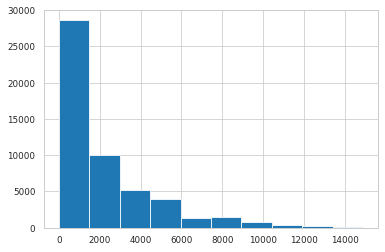

In [0]:
df['tags_freq'].hist()

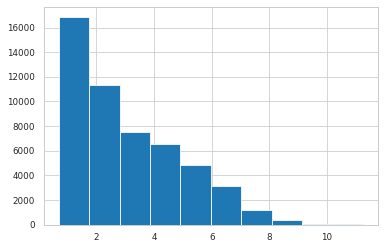

In [0]:
df['target'].hist()

### Анализ признака domain


In [0]:
df['domain'].describe

<bound method NDFrame.describe of 0        medium.com
1        medium.com
2        medium.com
3        medium.com
4        medium.com
            ...    
51785    medium.com
51786    medium.com
51787    medium.com
51788    medium.com
51789    medium.com
Name: domain, Length: 51790, dtype: object>

In [0]:
df.domain.value_counts()

medium.com                       49227
hackernoon.com                    1830
jw-webmagazine.com                 143
blog.medium.com                     60
thecoffeelicious.com                42
                                 ...  
blog.markgrowth.com                  1
davidtintner.com                     1
insights.qualcommventures.com        1
hackers.rockcontent.com              1
blog.purse.io                        1
Name: domain, Length: 193, dtype: int64

In [0]:
def domain_get(label):
  if label == 'medium.com':
    res = 'medium' 
  elif label == 'hackernoon.com':
    res = 'hackernoon'
  else: 
    res = 'others'
  return res 

In [0]:
# Добавим признак - домен=medium.com/hackernoon?
df['domain_top'] = df['domain'].apply(domain_get)

In [0]:
df.head()

,content,published,title,author,domain,tags,length,url,dow,year,month,hour,number_of_tags,target,season,dayofweek,partofday,target_log,domain_top
0,"The HairpinLadies first.Jan 2, 2015Ain’t No Fu...",2015-01-02 16:00:26.000,Ain’t No Fun If A Girl Can’t Have None,The Hairpin,medium.com,TheWomenOfOurYear Aaliyah DaBrat,6127,https://medium.com/the-hairpin/aint-no-fun-if-...,4,2015,1,16,3,0.69315,winter,friday,afternoon,0.526591,medium
1,Conocerse es amarseEscribo en primera persona ...,2015-01-02 17:49:07.169,Expande tu consciencia y enriquece tu perspect...,Conocerse es amarse,medium.com,Constructivismo Psicologia Consciencia Desarro...,6672,https://medium.com/espanol/expande-tu-conscien...,4,2015,1,17,4,1.94591,winter,friday,afternoon,1.080418,medium
2,Chris NordlingerPh.D. Fulbright Scholar. Story...,2015-01-02 22:59:12.812,3 Reasons that Apple Watch and others need hea...,Chris Nordlinger,medium.com,Wearables DigitalHealth Healthcare,11003,https://medium.com/@chrisnordlinger/wearables-...,4,2015,1,22,3,2.39790,winter,friday,evening,1.223158,medium
3,"Dale MugfordCo-founder of BraveNewCode, we mak...",2015-01-03 00:57:56.968,DIY Fusion Drives — The Right Way,Dale Mugford,medium.com,Fusion Mac Apple,10429,https://medium.com/@dalemugford/diy-fusion-dri...,5,2015,1,0,3,2.07944,winter,saturday,night,1.124748,medium
4,"Henry WardCEO at CartaJan 2, 2015Broken cap ta...",2015-01-03 03:59:17.433,Broken cap tables,Henry Ward,medium.com,Henry Startup CapTable Investors Insightseshares,10496,https://blog.esharesinc.com/broken-cap-tables/,5,2015,1,3,5,5.94280,winter,saturday,night,1.937705,medium


Text(0.5, 1.0, 'domain_top')

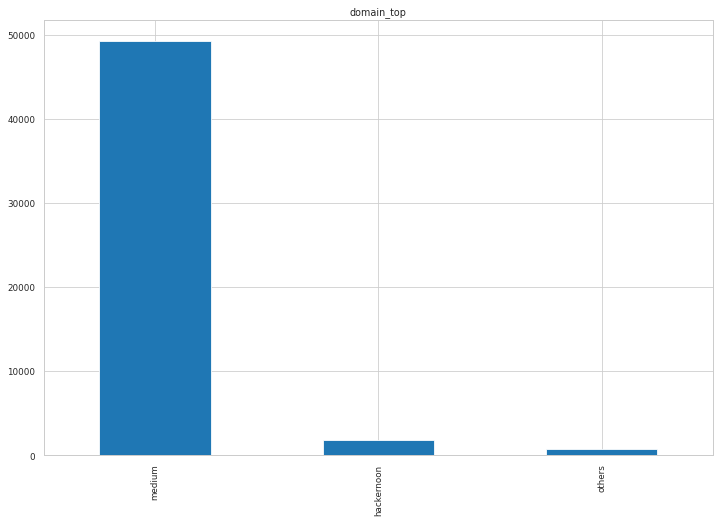

In [0]:
# Строим картинку
df['domain_top'].value_counts().plot(kind='bar')
# Добавляем подпись
plt.title(u'domain_top')

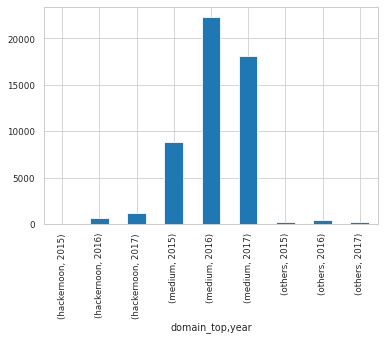

In [0]:
df.groupby(['domain_top','year']).size().plot(kind='bar')

In [0]:
df.head(1)

,content,published,title,author,domain,tags,length,url,dow,year,month,hour,number_of_tags,target,season,dayofweek,partofday,target_log,domain_top,author_wo_space
0,"The HairpinLadies first.Jan 2, 2015Ain’t No Fu...",2015-01-02 16:00:26.000,Ain’t No Fun If A Girl Can’t Have None,The Hairpin,medium.com,TheWomenOfOurYear Aaliyah DaBrat,6127,https://medium.com/the-hairpin/aint-no-fun-if-...,4,2015,1,16,3,0.69315,winter,friday,afternoon,0.526591,medium,TheHairpin


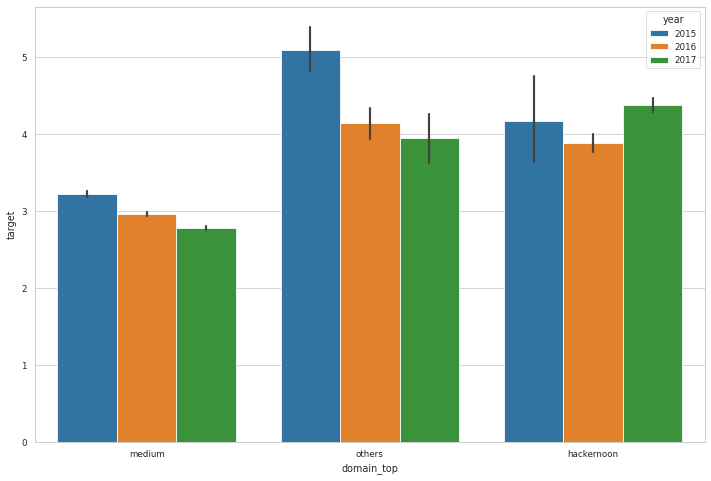

In [0]:
# Проверим влияние на target
plt.rcParams['figure.figsize'] = (12,8)
sns.barplot(df['domain_top'], df['target'], hue = df['year']); # показывает среднее 

In [0]:
df.pivot_table('target', columns = 'domain_top', aggfunc ='sum') 

domain_top,hackernoon,medium,others
target,7687.64784,144509.3143,3163.63909


In [0]:
df.corr()

,length,dow,year,month,hour,number_of_tags,target,target_log
length,1.000000,0.001582,-0.017552,0.000802,0.015327,-0.017560,0.094210,0.088741
dow,0.001582,1.000000,0.019587,-0.009804,-0.015838,0.004988,-0.032410,-0.034098
year,-0.017552,0.019587,1.000000,-0.510349,-0.006179,0.475427,-0.066048,-0.073823
month,0.000802,-0.009804,-0.510349,1.000000,-0.007202,0.013862,-0.000247,0.001799
hour,0.015327,-0.015838,-0.006179,-0.007202,1.000000,-0.002299,0.042758,0.046290
number_of_tags,-0.017560,0.004988,0.475427,0.013862,-0.002299,1.000000,-0.008584,-0.017873
target,0.094210,-0.032410,-0.066048,-0.000247,0.042758,-0.008584,1.000000,0.973733
target_log,0.088741,-0.034098,-0.073823,0.001799,0.046290,-0.017873,0.973733,1.000000


### Анализ признака author 

In [0]:
df.author.value_counts()

Jon Westenberg 🌈            189
War Is Boring               108
Larry Kim                   106
Darius Foroux               104
James Altucher               96
                           ... 
Tim Carmody                   1
Kristine Zerkowski            1
Derek McDaniel                1
Anneke Elyse Jong             1
Florian Matthaeus Spiegl      1
Name: author, Length: 27512, dtype: int64

In [0]:
df.length.value_counts()


5182     16
6158     16
6498     16
7764     15
8367     15
         ..
13569     1
11522     1
14355     1
18427     1
2047      1
Name: length, Length: 14816, dtype: int64

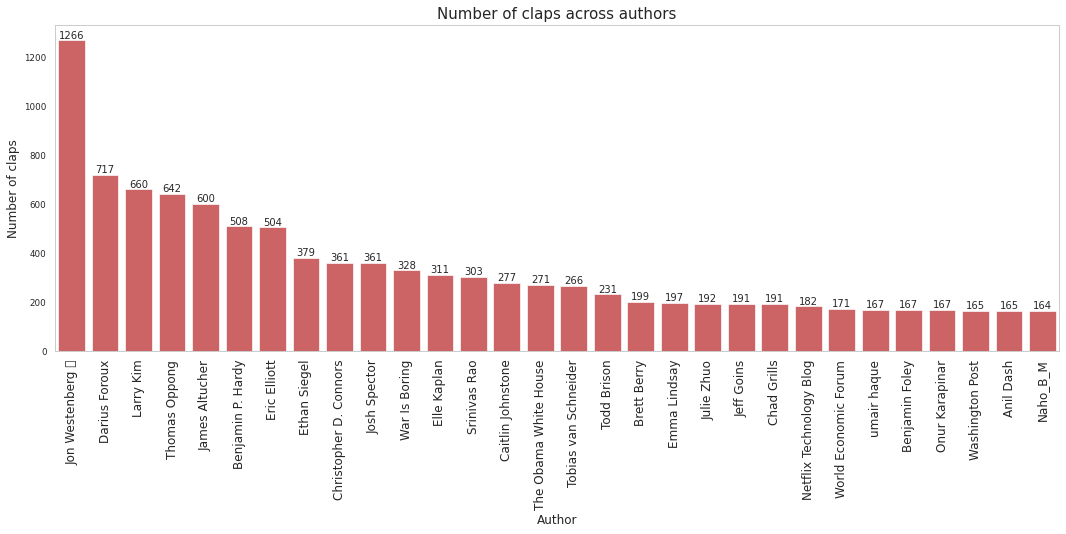

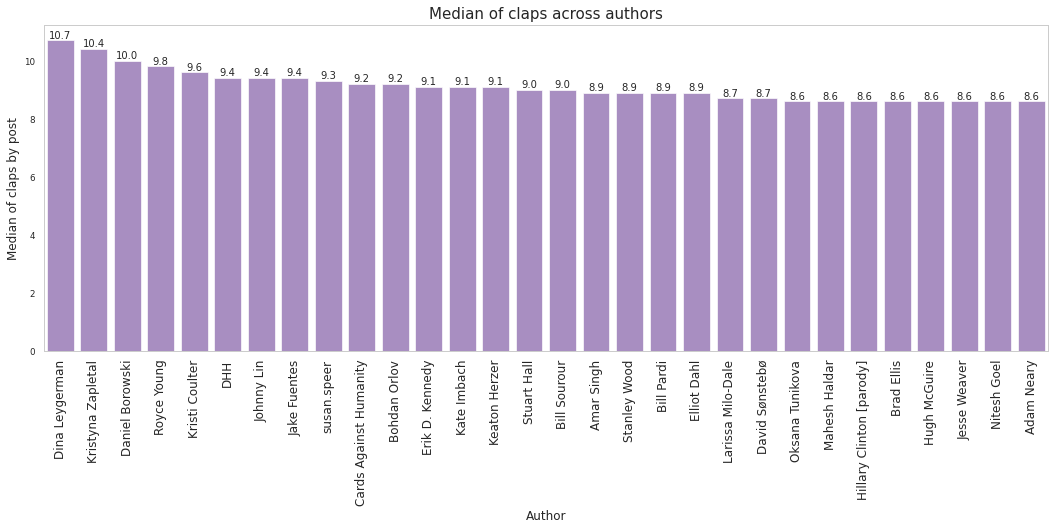

In [0]:
plt.figure(figsize=(18,6))

temp = df.groupby('author')['target'].sum().sort_values(ascending=False).iloc[:30]
ax1 = sns.barplot(temp.index,np.round(temp.values, 1), alpha=0.8, color=color[3])
plt.ylabel('Number of claps', fontsize=12)
plt.xlabel('Author', fontsize=12)
plt.title('Number of claps across authors', fontsize=15)
plt.grid(False)
plt.xticks(rotation=90, fontsize=12)

for p in ax1.patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax1.annotate('{}'.format(int(p.get_height())), (x.mean(), y), ha='center', va='bottom')
    
plt.figure(figsize=(18,6))

temp = df.groupby('author')['target'].median().sort_values(ascending=False).iloc[:30]
ax2 = sns.barplot(temp.index,np.round(temp.values, 1), alpha=0.8, color=color[4])
plt.ylabel('Median of claps by post', fontsize=12)
plt.xlabel('Author', fontsize=12)
plt.title('Median of claps across authors', fontsize=15)
plt.grid(False)
plt.xticks(rotation=90, fontsize=12)

for p in ax2.patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax2.annotate('{}'.format(p.get_height()), (x.mean(), y), ha='center', va='bottom');

In [0]:
temp

author
Dina Leygerman              10.736420
Kristyna Zapletal           10.434150
Daniel Borowski             10.043290
Royce Young                  9.752720
Kristi Coulter               9.615870
DHH                          9.400605
Johnny Lin                   9.384380
Jake Fuentes                 9.375940
susan.speer                  9.296610
Cards Against Humanity       9.208440
Bohdan Orlov                 9.179980
Erik D. Kennedy              9.116140
Kate Imbach                  9.093920
Keaton Herzer                9.071190
Stuart Hall                  9.036110
Bill Sourour                 9.012010
Amar Singh                   8.922790
Stanley Wood                 8.909370
Bill Pardi                   8.909370
Elliot Dahl                  8.895770
Larissa Milo-Dale            8.716210
David Sønstebø               8.682880
Oksana Tunikova              8.648400
Mahesh Haldar                8.648400
Hillary Clinton [parody]     8.630700
Brad Ellis                   8.630700
Hugh 

In [0]:
df.groupby('author')['target'].sum().sort_values(ascending=False).iloc[:30]

author
Jon Westenberg 🌈           1266.85817
Darius Foroux               717.56338
Larry Kim                   660.14002
Thomas Oppong               642.73227
James Altucher              600.69904
Benjamin P. Hardy           508.51969
Eric Elliott                504.26865
Ethan Siegel                379.09031
Christopher D. Connors      361.12369
Josh Spector                361.10019
War Is Boring               328.92348
Elle Kaplan                 311.34027
Srinivas Rao                303.34189
Caitlin Johnstone           277.89787
The Obama White House       271.55613
Tobias van Schneider        266.88425
Todd Brison                 231.64576
Brett Berry                 199.55827
Emma Lindsay                197.72370
Julie Zhuo                  192.52209
Jeff Goins                  191.94833
Chad Grills                 191.40752
Netflix Technology Blog     182.52783
World Economic Forum        171.55547
umair haque                 167.90687
Benjamin Foley              167.80017
Onur 

In [0]:
df.head(1)

,content,published,title,author,domain,tags,length,url,dow,year,month,hour,number_of_tags,target,season,dayofweek,partofday,target_log,domain_top
0,"The HairpinLadies first.Jan 2, 2015Ain’t No Fu...",2015-01-02 16:00:26,Ain’t No Fun If A Girl Can’t Have None,The Hairpin,medium.com,TheWomenOfOurYear Aaliyah DaBrat,6127,https://medium.com/the-hairpin/aint-no-fun-if-...,4,2015,1,16,3,0.69315,winter,friday,afternoon,0.526591,medium


Идея: рейтинг автора - колво статей - как часто выпускает статьи




In [0]:
# ввести рэйтинг автора - сколько лайков за 1 статью у автора 
def get_author_cnt_articles (df):
    authors = df['author'].unique()
    dict_authors = {i: len(df[df['author'] == i]) for i in authors}
    df['author_cnt_article'] = df['author'].map(dict_authors)

In [0]:
# get_author_cnt_articles (df)

In [0]:
# df['author_cnt_article'].hist(bins = 20)

In [0]:
# df[df['author_cnt_article'] > 40]

обработаем признак author также как и признак tags

In [0]:
# Удалим пробелы из ФИ автора, чтобы работать с сочетаниями Ф+И
df['author_wo_space'] = df['author'].str.replace(' ', '')

In [0]:
df[['author', 'author_wo_space']]

,author,author_wo_space
0,The Hairpin,TheHairpin
1,Conocerse es amarse,Conocerseesamarse
2,Chris Nordlinger,ChrisNordlinger
3,Dale Mugford,DaleMugford
4,Henry Ward,HenryWard
...,...,...
51785,Bruna Ciafrei,BrunaCiafrei
51786,kerry stranman,kerrystranman
51787,Akif Umut Avaz,AkifUmutAvaz
51788,niva,niva


In [0]:
df_copy = df.copy()

# Подготовка данных для модели

In [0]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [0]:
# уже подготовленный датасэт, но некодированный
df = pd.read_csv(PATH+'df_new.csv', index_col=0)

In [0]:
df.shape

(51790, 22)

In [0]:
# %%time
# Применим ко всему датасэту 
# df['tags_freq'] = df['tags'].apply(get_num_freq_tags)

In [0]:

# df.rename(columns={'tag_freq_log': 'tags_freq_log'}, inplace=True) 


In [0]:
# df.to_csv('df_new.csv')

In [0]:
df.head(1)

,content,published,title,author,domain,tags,length,url,dow,year,month,hour,number_of_tags,target,season,dayofweek,partofday,target_log,domain_top,author_wo_space,tags_freq,tags_freq_log
0,"The HairpinLadies first.Jan 2, 2015Ain’t No Fu...",2015-01-02 16:00:26.000,Ain’t No Fun If A Girl Can’t Have None,The Hairpin,medium.com,TheWomenOfOurYear Aaliyah DaBrat,6127,https://medium.com/the-hairpin/aint-no-fun-if-...,4,2015,1,16,3,0.69315,winter,friday,afternoon,0.526591,medium,TheHairpin,3,1.098612


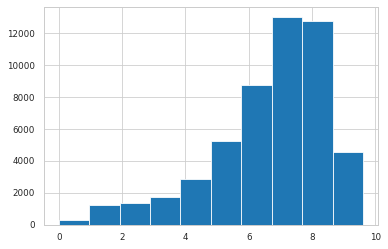

In [0]:
# tags_freq - прологарифмируем 

#df['tags_freq_log'] = np.log(df['tags_freq'])
df['tags_freq_log'].hist() # 

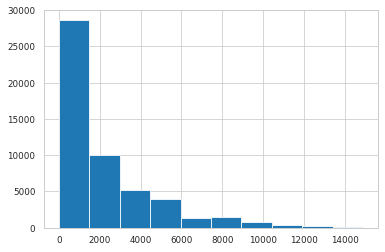

In [0]:
df['tags_freq'].hist()

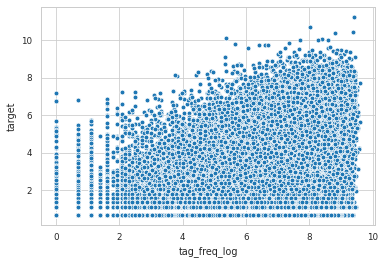

In [0]:
# Зависимость target от tag_freq_log 

sns.scatterplot(x = 'tag_freq_log', y = 'target', data = df)

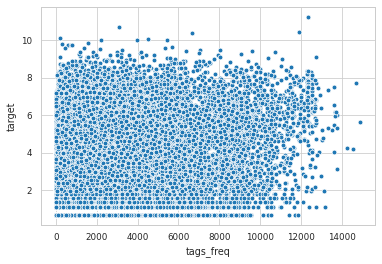

In [0]:
# Зависимость target от tags_freq 

sns.scatterplot(x = 'tags_freq', y = 'target', data = df)

In [0]:
# Информация по фичам (название, кол-во пропущенных значений, число унивкальных значений, питонячий тип)
pd.DataFrame({'Feature': df.columns.tolist(),
              'NaN_count': df.isna().sum().tolist(),
              'number_of_unique_elements': pd.Series(df.columns.tolist()).apply(lambda row: df[row].nunique()),
              'type': pd.Series(df.columns.tolist()).apply(lambda row: df[row].dtype)})

,Feature,NaN_count,number_of_unique_elements,type
0,content,0,51784,object
1,published,0,51707,object
2,title,0,51523,object
3,author,0,27512,object
4,domain,0,193,object
5,tags,0,49286,object
6,length,0,14816,int64
7,url,0,51782,object
8,dow,0,7,int64
9,year,0,3,object


In [0]:
# Добавим к модели признаки: месяц, год, час - сделаем их object 
list_tmp = ['month', 'hour', 'year', 'number_of_tags']

for i in list_tmp:
  df[i] = df[i].astype(object)


In [0]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 51790 entries, 0 to 51789
Data columns (total 22 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   content          51790 non-null  object 
 1   published        51790 non-null  object 
 2   title            51790 non-null  object 
 3   author           51790 non-null  object 
 4   domain           51790 non-null  object 
 5   tags             51790 non-null  object 
 6   length           51790 non-null  int64  
 7   url              51790 non-null  object 
 8   dow              51790 non-null  int64  
 9   year             51790 non-null  object 
 10  month            51790 non-null  object 
 11  hour             51790 non-null  object 
 12  number_of_tags   51790 non-null  object 
 13  target           51790 non-null  float64
 14  season           51790 non-null  object 
 15  dayofweek        51790 non-null  object 
 16  partofday        51790 non-null  object 
 17  target_log  

In [0]:
def data_prepared(data, l_test_data = False, del_label = None): 
  if l_test_data == True:
    df_model = data[['length', 'number_of_tags', 'month', 'hour', 'year', 'season', 'dayofweek', 'partofday', 'domain_top', 'tags_freq', 'day_type']] 
  else: 
    df_model = data[['length', 'number_of_tags', 'month', 'hour', 'year', 'season', 'dayofweek', 'partofday', 'domain_top', 'tags_freq', 'day_type', 'target']] 
  if del_label != None: 
    df_model = df_model.drop(columns = del_label)
  # категориальные фичи
  cat_features = df_model.columns[df_model.dtypes == 'object'].tolist()
  # числовые признаки
  numerical_feature = df_model.columns[df_model.dtypes != 'object'].tolist()
  if l_test_data == True:
    pass 
  else: 
    numerical_feature.remove('target')
  # Стандратизация числовых признаков
  scaler=StandardScaler()
  df_scaled = pd.DataFrame(scaler.fit_transform(df_model[numerical_feature]), columns = numerical_feature)
  # Со стандартизированными числовыми признаками новый датасэт
  df_model = df_model.drop(columns = numerical_feature) # удаляем числовые признаки
  df_model = pd.concat([df_scaled, df_model], axis = 1)  # добавляем их уже в стандартизированном формате
  # Обработка категориальных признаков с помощью One Hot Encoding
  df_concat_cat_features = pd.get_dummies(df_model[cat_features])
  # Удаление категориальных переменных
  df_model.drop(cat_features, axis = 1, inplace = True)
  # Присоединение новых
  df_model = pd.concat([df_concat_cat_features, df_model], axis = 1 )
  return df_model

In [0]:
df_model = data_prepared(df)

In [0]:
df_model.head()

,number_of_tags_1,number_of_tags_2,number_of_tags_3,number_of_tags_4,number_of_tags_5,number_of_tags_6,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,hour_0,hour_1,hour_2,hour_3,hour_4,hour_5,hour_6,hour_7,hour_8,hour_9,hour_10,hour_11,hour_12,hour_13,hour_14,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23,year_2015,year_2016,year_2017,season_autumn,season_spring,season_summer,season_winter,dayofweek_friday,dayofweek_monday,dayofweek_saturday,dayofweek_sunday,dayofweek_thursday,dayofweek_tuesday,dayofweek_wednesday,partofday_afternoon,partofday_evening,partofday_morning,partofday_night,domain_top_hackernoon,domain_top_medium,domain_top_others,day_type_weekend,day_type_workday,length,tags_freq,target
0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,-0.626931,-0.868428,0.69315
1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,-0.480578,-0.852215,1.94591
2,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0.682465,-0.742881,2.39790
3,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,1,0.528323,-0.717937,2.07944
4,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,1,0.546316,1.176499,5.94280


In [0]:
df_model.shape

(51790, 68)

In [0]:
ddf_model_wo_season =  data_prepared(df, del_label = 'season')
df_model_wo_season.head()

,dayofweek_friday,dayofweek_monday,dayofweek_saturday,dayofweek_sunday,dayofweek_thursday,dayofweek_tuesday,dayofweek_wednesday,partofday_afternoon,partofday_evening,partofday_morning,partofday_night,domain_top_hackernoon,domain_top_medium,domain_top_others,length,number_of_tags,target
0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,-0.626931,-0.922931,0.69315
1,1,0,0,0,0,0,0,1,0,0,0,0,1,0,-0.480578,-0.001992,1.94591
2,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0.682465,-0.922931,2.39790
3,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0.528323,-0.922931,2.07944
4,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0.546316,0.918948,5.94280


In [0]:
# обработка tags 1k
cv_tags_1k = CountVectorizer(max_features=1000)  # ridge c 5000 хуже - 1.32 (in colab)
tags_train = df['tags'].values.tolist()
X_train_tags_1k = cv_tags_1k.fit_transform(tags_train) # выдает разряженную матрицу

In [0]:
# обработка tags 10k
cv_tags_10k = CountVectorizer(max_features=10000)  # ridge c 5000 хуже - 1.32 (in colab)
tags_train = df['tags'].values.tolist()
X_train_tags_10k = cv_tags_10k.fit_transform(tags_train) # выдает разряженную матрицу

In [0]:
# обработка title 1k - в названии могут быть популярные слова - тэги
cv_title_1k = CountVectorizer(max_features=1000) # c 50000 - catboost 1.13
title_train = df['title'].values.tolist()
X_train_title_1k = cv_title_1k.fit_transform(title_train) # выдает разряженную матрицу

In [0]:
# обработка title 10k- в названии могут быть популярные слова - тэги
cv_title_10k = CountVectorizer(max_features=10000) # c 50000 - catboost 1.13
title_train = df['title'].values.tolist()
X_train_title_10k = cv_title_10k.fit_transform(title_train) # выдает разряженную матрицу

In [0]:
# обработка title 30k- в названии могут быть популярные слова - тэги
cv_title_30k = CountVectorizer(max_features=30000) # c 50000 - catboost 1.13
title_train = df['title'].values.tolist()
X_train_title_30k = cv_title_30k.fit_transform(title_train) # выдает разряженную матрицу

In [0]:
# обработка content 1k - в названии могут быть популярные слова - тэги
cv_content_1k = CountVectorizer(max_features=1000) 
content_train = df['content'].values.tolist()
X_train_content_1k = cv_content_1k.fit_transform(content_train) # выдает разряженную матрицу

In [0]:
# обработка content 10k - в названии могут быть популярные слова - тэги
cv_content_10k = CountVectorizer(max_features=10000) 
content_train = df['content'].values.tolist()
X_train_content_10k = cv_content_10k.fit_transform(content_train) # выдает разряженную матрицу

In [0]:
# обработка content 50k - в названии могут быть популярные слова - тэги
cv_content_50k = CountVectorizer(max_features=50000) 
content_train = df['content'].values.tolist()
X_train_content_50k = cv_content_50k.fit_transform(content_train) # выдает разряженную матрицу

In [0]:
# обработка author 1k
cv_author_1k = CountVectorizer(max_features=1000) 
author_train = df['author_wo_space'].values.tolist()
X_train_author_1k = cv_author_1k.fit_transform(author_train) # выдает разряженную матрицу
# результат хуже - 1.89

In [0]:
# обработка author 10k
cv_author_10k = CountVectorizer(max_features=10000) 
author_train = df['author_wo_space'].values.tolist()
X_train_author_10k = cv_author_10k.fit_transform(author_train) # выдает разряженную матрицу

In [0]:
df_model.head()

,number_of_tags_1,number_of_tags_2,number_of_tags_3,number_of_tags_4,number_of_tags_5,number_of_tags_6,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,hour_0,hour_1,hour_2,hour_3,hour_4,hour_5,hour_6,hour_7,hour_8,hour_9,hour_10,hour_11,hour_12,hour_13,hour_14,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23,year_2015,year_2016,year_2017,season_autumn,season_spring,season_summer,season_winter,dayofweek_friday,dayofweek_monday,dayofweek_saturday,dayofweek_sunday,dayofweek_thursday,dayofweek_tuesday,dayofweek_wednesday,partofday_afternoon,partofday_evening,partofday_morning,partofday_night,domain_top_hackernoon,domain_top_medium,domain_top_others,length,tags_freq_log,target
0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,1,0,-0.626931,-3.025129,0.69315
1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,1,0,-0.480578,-1.592821,1.94591
2,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0.682465,-0.516772,2.39790
3,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0.528323,-0.419305,2.07944
4,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0.546316,0.992659,5.94280


In [0]:
df_model = df_model.drop('target', axis = 1)

In [0]:
#X_train_sparse = csr_matrix(hstack([X_train_tags, X_train_title, X_train_content, df_model.values]))
X_train_sparse_with_author_1k = csr_matrix(hstack([X_train_tags_1k, X_train_title_1k, X_train_content_1k, X_train_author_1k, df_model.values]))
X_train_sparse_with_author_10k = csr_matrix(hstack([X_train_tags_10k, X_train_title_10k, X_train_content_10k, X_train_author_10k, df_model.values]))

In [0]:
# tag_freq 
X_train_tag_freq_1k = csr_matrix(hstack([X_train_tags_1k, X_train_title_1k, X_train_content_1k, X_train_author_1k, df_model.values]))


In [0]:
# tag 1k, title 30k, content 50k - хуже рез-т
X_train_1k_30k_50k = csr_matrix(hstack([X_train_tags_1k, X_train_title_30k, X_train_content_50k, X_train_author_1k, df_model.values]))


In [0]:
X_train_sparse_with_author_1k.shape

(51790, 4065)

In [0]:
X_train_sparse_with_author_10k.shape

(51790, 40065)

In [0]:
#X_train_sparse_with_author  # c 50000 - catboost 1.13

<51790x31020 sparse matrix of type '<class 'numpy.float64'>'
	with 22309252 stored elements in Compressed Sparse Row format>

In [0]:
# Попробуем без season - не сильно лучше
# df_model_wo_season = df_model_wo_season.drop('target', axis = 1)
# X_train_sparse = csr_matrix(hstack([X_train_tags, X_train_title, X_train_content, df_model_wo_season.values]))

In [0]:
#X_train_sparse

<51790x3016 sparse matrix of type '<class 'numpy.float64'>'
	with 12457582 stored elements in Compressed Sparse Row format>

In [0]:
y_train_df = df['target'].values

# Построение модели

In [0]:
from sklearn.metrics import make_scorer, accuracy_score, mean_squared_error
from sklearn.metrics import mean_squared_log_error, mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_val_score, KFold
from sklearn.linear_model import LinearRegression, Ridge, Lasso, RidgeCV, LassoCV, SGDRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.svm import LinearSVR
from lightgbm import LGBMRegressor
import xgboost as xgb


In [0]:
X_train_1k, X_holdout_1k, y_train_1k, y_holdout_1k = train_test_split(X_train_sparse_with_author_1k, y_train_df, test_size=0.3,random_state=17)

In [0]:
X_train_10k, X_holdout_10k, y_train_10k, y_holdout_10k = train_test_split(X_train_sparse_with_author_10k, y_train_df, test_size=0.3,random_state=17)

In [0]:
# tag_freq
X_train_tag_freq_1k, X_holdout_tag_freq_1k, y_train_tag_freq_1k, y_holdout_tag_freq_1k = train_test_split(X_train_tag_freq_1k, y_train_df, test_size=0.3,random_state=17)

In [0]:
# tag 1k, title 30k, content 50k
X_train_tag_freq_13050k, X_holdout_tag_freq_13050k, y_train_tag_freq_13050k, y_holdout_tag_freq_13050k = train_test_split(X_train_1k_30k_50k, y_train_df, test_size=0.3,random_state=17)

## Метод главных компонент

In [0]:
from sklearn.decomposition import PCA

In [0]:
pca = PCA(n_components = 0.99, whiten = True )

In [0]:
features_pca = pca.fit_transform(X_train_sparse_with_author_1k)

TypeError: ignored

In [0]:
features = df.drop(columns = ['target'])
features.shape

(51790, 21)

In [0]:
features.head(1)

,content,published,title,author,domain,tags,length,url,dow,year,month,hour,number_of_tags,season,dayofweek,partofday,target_log,domain_top,author_wo_space,tags_freq,tags_freq_log
0,"The HairpinLadies first.Jan 2, 2015Ain’t No Fu...",2015-01-02 16:00:26.000,Ain’t No Fun If A Girl Can’t Have None,The Hairpin,medium.com,TheWomenOfOurYear Aaliyah DaBrat,6127,https://medium.com/the-hairpin/aint-no-fun-if-...,4,2015,1,16,3,winter,friday,afternoon,0.526591,medium,TheHairpin,3,1.098612


In [0]:
features_pca = pca.fit_transform(features)

ValueError: ignored

In [0]:
df_model.head(1)

,season_autumn,season_spring,season_summer,season_winter,dayofweek_friday,dayofweek_monday,dayofweek_saturday,dayofweek_sunday,dayofweek_thursday,dayofweek_tuesday,dayofweek_wednesday,partofday_afternoon,partofday_evening,partofday_morning,partofday_night,domain_top_hackernoon,domain_top_medium,domain_top_others,length,number_of_tags,tags_freq_log
0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,1,0,-0.626931,-0.922931,-3.025129


In [0]:
features_pca = pca.fit_transform(df_model)

In [0]:
print("old dim: " , df_model.shape[1])
print("pca dim: " , features_pca.shape[1])

old dim:  21
pca dim:  16


In [0]:
features_pca

array([[ 2.47865815, -0.8735611 ,  1.60455277, ..., -0.63401989,
        -0.24884342,  0.07753633],
       [ 0.97941653, -0.61111055,  1.21335821, ..., -0.60963785,
        -0.22961331, -0.12049911],
       [ 0.96739693,  0.6600835 , -0.29588691, ..., -0.70439112,
        -0.1309232 , -0.03134728],
       ...,
       [ 3.31779343,  0.87693871,  1.21192959, ..., -0.6505849 ,
        -0.15915772,  0.44871761],
       [ 1.93110307,  1.60120155,  2.43013003, ..., -0.68073996,
        -0.16970182,  0.31921707],
       [ 0.72755817,  0.93505379,  2.39439204, ..., -0.66417874,
        -0.16139922,  0.11251093]])

In [0]:
X_train_pca, X_holdout_pca, y_train_pca, y_holdout_pca = train_test_split(features_pca, y_train_df, test_size=0.3,random_state=17)

In [0]:
%%time
ridge_pca = Ridge(random_state = 17)
ridge_pca.fit(X_train_pca, y_train_pca)


CPU times: user 9.2 ms, sys: 1.03 ms, total: 10.2 ms
Wall time: 11.7 ms


In [0]:
mean_absolute_error(y_holdout_pca, ridge_pca.predict(X_holdout_pca))

1.4642719655449719

In [0]:
%%time
ridge_1k = Ridge(random_state = 17)
ridge_1k.fit(X_train_1k, y_train_1k)


CPU times: user 19.1 s, sys: 14.2 ms, total: 19.1 s
Wall time: 19.1 s


In [0]:
mean_absolute_error(y_holdout_1k, ridge_1k.predict(X_holdout_1k))

1.148656612973401

In [0]:
from sklearn.decomposition import TruncatedSVD

In [0]:
tsvd = TruncatedSVD()

In [0]:
features_tsvd = tsvd.fit_transform(X_train_sparse_with_author_1k)

In [0]:
print("old dim: " , X_train_sparse_with_author_1k.shape[1])
print("tsvd dim: " , features_tsvd.shape[1])

old dim:  4021
tsvd dim:  2


In [0]:
features_tsvd

array([[ 79.35838863,   0.40599545],
       [  1.84795333,  90.35373801],
       [130.72506938,  -1.1105431 ],
       ...,
       [  5.35858531,  14.37535701],
       [  6.94846961, 139.93232161],
       [  2.1765871 , 171.33167838]])

In [0]:
X_train_tsvd, X_holdout_tsvd, y_train_tsvd, y_holdout_tsvd = train_test_split(features_tsvd, y_train_df, test_size=0.3,random_state=17)

In [0]:
%%time
ridge_1k = Ridge(random_state = 17)
ridge_1k.fit(X_train_tsvd, y_train_tsvd)

CPU times: user 3.6 ms, sys: 936 µs, total: 4.54 ms
Wall time: 6.06 ms


In [0]:
mean_absolute_error(y_holdout_tsvd, ridge_1k.predict(X_holdout_tsvd))

1.570735041018422

In [0]:
X_holdout_tsvd.shape

(15537, 2)

## Одиночные стандартные модели

### Ridge

In [0]:
# c признаками времени, кол-во тэгов, tag_freq_log
%%time 
ridge_1k = Ridge(random_state = 17)
ridge_1k.fit(X_train_1k, y_train_1k)
mean_absolute_error(y_holdout_1k, ridge_1k.predict(X_holdout_1k))


CPU times: user 22.5 s, sys: 15.4 ms, total: 22.6 s
Wall time: 22.6 s


In [0]:
mean_absolute_error(y_holdout_1k, ridge_1k.predict(X_holdout_1k))

1.139653939365833

In [0]:
# c признаками времени, кол-во тэгов, tag_freq
%%time 
ridge_tag_freq_1k = Ridge(random_state = 17)
ridge_tag_freq_1k.fit(X_train_tag_freq_1k, y_train_tag_freq_1k)


CPU times: user 22.8 s, sys: 18.8 ms, total: 22.8 s
Wall time: 22.8 s


In [0]:
mean_absolute_error(y_holdout_tag_freq_1k, ridge_tag_freq_1k.predict(X_holdout_tag_freq_1k))

1.1398372283251623

In [0]:
# c признаками времени, кол-во тэгов, tag_freq
%%time 
ridge_tag_freq_13050k = Ridge(random_state = 17)
ridge_tag_freq_13050k.fit(X_train_tag_freq_13050k, y_train_tag_freq_13050k)


CPU times: user 11min 45s, sys: 8min 15s, total: 20min 1s
Wall time: 10min 10s


In [0]:
mean_absolute_error(y_holdout_tag_freq_13050k, ridge_tag_freq_13050k.predict(X_holdout_tag_freq_13050k))

2.593295082068321

In [0]:
# c признаками времени, кол-во тэгов, tag_freq, day_type
%%time 
ridge_day_type_1k = Ridge(random_state = 17)
ridge_day_type_1k.fit(X_train_tag_freq_1k, y_train_tag_freq_1k)


CPU times: user 23.8 s, sys: 24.2 ms, total: 23.8 s
Wall time: 23.9 s


In [0]:
mean_absolute_error(y_holdout_tag_freq_1k, ridge_day_type_1k.predict(X_holdout_tag_freq_1k))

1.1399667830935363

In [0]:
ridge_1k = Ridge(random_state = 17)
ridge_1k.fit(X_train_1k, y_train_1k)
mean_absolute_error(y_holdout_1k, ridge_1k.predict(X_holdout_1k))

1.1466537754857424

In [0]:
ridge_10k = Ridge(random_state = 17)
ridge_10k.fit(X_train_10k, y_train_10k)
mean_absolute_error(y_holdout_10k, ridge_10k.predict(X_holdout_10k))

1.3927530995614519

Попробуем с log(tag_freq)

In [0]:
ridge_1k = Ridge(random_state = 17)
ridge_1k.fit(X_train_1k, y_train_1k)
mean_absolute_error(y_holdout_1k, ridge_1k.predict(X_holdout_1k))

1.144277377761767

Попробуем без кодирования tags (лучше с кодированием)

In [0]:
df.head(1)

,content,published,title,author,domain,tags,length,url,dow,year,month,hour,number_of_tags,target,season,dayofweek,partofday,target_log,domain_top,author_wo_space,tags_freq
0,"The HairpinLadies first.Jan 2, 2015Ain’t No Fu...",2015-01-02 16:00:26.000,Ain’t No Fun If A Girl Can’t Have None,The Hairpin,medium.com,TheWomenOfOurYear Aaliyah DaBrat,6127,https://medium.com/the-hairpin/aint-no-fun-if-...,4,2015,1,16,3,0.69315,winter,friday,afternoon,0.526591,medium,TheHairpin,0


In [0]:
df_model_test = data_prepared(df)

In [0]:
X_train_sparse_tag_1k = csr_matrix(hstack([X_train_title_1k, X_train_content_1k, X_train_author_1k, df_model_test.drop(columns = 'target', axis = 1).values]))
y_train_df = df['target'].values

In [0]:
X_train_tag_1k, X_holdout_tag_1k, y_train_tag_1k, y_holdout_tag_1k = train_test_split(X_train_sparse_tag_1k, y_train_df, test_size=0.3,random_state=17)

In [0]:
ridge_tag_1k = Ridge(random_state = 17)
ridge_tag_1k.fit(X_train_tag_1k, y_train_tag_1k)


Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=17, solver='auto', tol=0.001)

In [0]:
mean_absolute_error(y_holdout_tag_1k, ridge_tag_1k.predict(X_holdout_tag_1k))

1.1708496152651988

In [0]:
df_model_test.head()

,season_autumn,season_spring,season_summer,season_winter,dayofweek_friday,dayofweek_monday,dayofweek_saturday,dayofweek_sunday,dayofweek_thursday,dayofweek_tuesday,dayofweek_wednesday,partofday_afternoon,partofday_evening,partofday_morning,partofday_night,domain_top_hackernoon,domain_top_medium,domain_top_others,length,number_of_tags,tags_freq,target
0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,1,0,-0.626931,-0.922931,-0.869213,0.69315
1,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,1,0,-0.480578,-0.001992,-0.852587,1.94591
2,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0.682465,-0.922931,-0.742439,2.39790
3,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0.528323,-0.922931,-0.717915,2.07944
4,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0.546316,0.918948,1.176209,5.94280


In [0]:
X_tr = df_model_test.drop(columns = 'target', axis = 1)

In [0]:
X_train_tag_1k, X_holdout_tag_1k, y_train_tag_1k, y_holdout_tag_1k = train_test_split( X_tr, y_train_df, test_size=0.3,random_state=17)

In [0]:
ridge_wocv_1k = Ridge(random_state = 17)
ridge_wocv_1k.fit(X_train_tag_1k, y_train_tag_1k)

Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=17, solver='auto', tol=0.001)

In [0]:
mean_absolute_error(y_holdout_tag_1k, ridge_wocv_1k.predict(X_holdout_tag_1k))

1.47088488311128

In [0]:
# Ridge Countvectorizer 5000
ridge = Ridge(random_state = 17)
ridge.fit(X_train, y_train)

Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=17, solver='auto', tol=0.001)

In [0]:
mean_absolute_error(y_holdout, ridge.predict(X_holdout))

1.3191164076310349

In [0]:
# Ridge Countvectorizer 1000
ridge_1000 = Ridge(random_state = 17)
ridge_1000.fit(X_train, y_train)
mean_absolute_error(y_holdout, ridge_1000.predict(X_holdout))

1.2378954549637031

In [0]:
# Ridge without label "season"
ridge_wo_season = Ridge(random_state = 17)
ridge_wo_season.fit(X_train, y_train)
mean_absolute_error(y_holdout, ridge_wo_season.predict(X_holdout))

1.236115452721839

### RandomForest

долго - 22 мин и ничего 

In [0]:
%%time
rfr_1k = RandomForestRegressor(random_state = 17)
rfr_1k.fit(X_train_1k, y_train_1k)
mean_absolute_error(y_holdout_1k, rfr_1k.predict(X_holdout_1k))

### Gradient boosting

In [0]:
gb = GradientBoostingRegressor(random_state=17)
gb.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=17, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [0]:
mean_absolute_error(y_holdout, gb.predict(X_holdout))

1.3019880276769644

In [0]:
gb_1000 = GradientBoostingRegressor(random_state=17)
gb_1000.fit(X_train, y_train)
mean_absolute_error(y_holdout, gb_1000.predict(X_holdout))

1.3206893386309897

### Neural net - MLP

In [0]:
mlp = MLPRegressor(random_state=17)                          
mlp.fit(X_train, y_train)

MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
             beta_2=0.999, early_stopping=False, epsilon=1e-08,
             hidden_layer_sizes=(100,), learning_rate='constant',
             learning_rate_init=0.001, max_fun=15000, max_iter=200,
             momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
             power_t=0.5, random_state=17, shuffle=True, solver='adam',
             tol=0.0001, validation_fraction=0.1, verbose=False,
             warm_start=False)

In [0]:
mean_absolute_error(y_holdout, mlp.predict(X_holdout))

1.258766634813294

In [0]:
mlp_1000 = MLPRegressor(random_state=17)                          
mlp_1000.fit(X_train, y_train)
mean_absolute_error(y_holdout, mlp_1000.predict(X_holdout))

1.3817829308039755

### XGBoosting

In [0]:
xgbr = xgb.XGBRegressor(random_state=17)
xgbr.fit(X_train, y_train)

[04:00:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=17,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [0]:
mean_absolute_error(y_holdout, xgbr.predict(X_holdout))

1.3015147067290669

In [0]:
xgbr_1000 = xgb.XGBRegressor(random_state=17)
xgbr_1000.fit(X_train, y_train)
mean_absolute_error(y_holdout, xgbr_1000.predict(X_holdout))

[08:25:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


1.3225166445853664

### LightGBM

In [0]:
# c признаками времени, кол-во тэгов
lgbmr = LGBMRegressor(random_state=17)
lgbmr.fit(X_train_1k, y_train_1k)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
              random_state=17, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [0]:
mean_absolute_error(y_holdout_1k, lgbmr.predict(X_holdout_1k))

1.203686858203803

In [0]:
# c новым признаком
lgbmr = LGBMRegressor(random_state=17)
lgbmr.fit(X_train_1k, y_train_1k)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
              random_state=17, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [0]:
mean_absolute_error(y_holdout_1k, lgbmr.predict(X_holdout_1k))

1.205746404316062

In [0]:
lgbmr = LGBMRegressor(random_state=17)
lgbmr.fit(X_train, y_train)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
              random_state=17, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [0]:
mean_absolute_error(y_holdout, lgbmr.predict(X_holdout))

1.1984450102726583

In [0]:
lgbmr_1000 = LGBMRegressor(random_state=17)
lgbmr_1000.fit(X_train, y_train)
mean_absolute_error(y_holdout, lgbmr_1000.predict(X_holdout))

1.2238609206751758

In [0]:
lgbmr_1000

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
              random_state=17, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

### AdaBoost

In [0]:
adb = AdaBoostRegressor(random_state=17)
adb.fit(X_train, y_train)
mean_absolute_error(y_holdout, adb.predict(X_holdout))

1.6418599922393458

### CatBoost

1) проверить на категориальных данных 
2) проверить на подготовленном датасэте

In [0]:
! pip install catboost

     |████████████████████████████████| 64.7MB 52kB/s 


In [0]:
from catboost import Pool, CatBoostRegressor

In [0]:
# c признаками времени, кол-во тэгов
%%time
catboost_1k = CatBoostRegressor(random_state=17, verbose = 0)
catboost_1k.fit(X_train_1k, y_train_1k)

CPU times: user 4min 46s, sys: 5.75 s, total: 4min 52s
Wall time: 2min 32s


In [0]:
mean_absolute_error(y_holdout_1k, catboost_1k.predict(X_holdout_1k))

1.1542751018139648

In [0]:
# c признаками времени, кол-во тэгов, tag_freq
%%time 
catboost_tag_freq_13050k = CatBoostRegressor(random_state=17, verbose = 0)
catboost_tag_freq_13050k.fit(X_train_tag_freq_13050k, y_train_tag_freq_13050k)


KeyboardInterrupt: ignored

In [0]:
mean_absolute_error(y_holdout_tag_freq_13050k, catboost_tag_freq_13050k.predict(X_holdout_tag_freq_13050k))

CatBoostError: ignored

In [0]:
catboost_1k = CatBoostRegressor(random_state=17, verbose = 0)
catboost_1k.fit(X_train_1k, y_train_1k)
mean_absolute_error(y_holdout_1k, catboost_1k.predict(X_holdout_1k))

1.1577437974433589

In [0]:
catboost_10k = CatBoostRegressor(random_state=17)
catboost_10k.fit(X_train_10k, y_train_10k)
mean_absolute_error(y_holdout_10k, catboost_10k.predict(X_holdout_10k))

Learning rate set to 0.073954
0:	learn: 1.8869992	total: 1.53s	remaining: 25m 28s
1:	learn: 1.8649857	total: 3.12s	remaining: 25m 56s
2:	learn: 1.8459787	total: 4.6s	remaining: 25m 28s
3:	learn: 1.8273023	total: 6.04s	remaining: 25m 5s
4:	learn: 1.8111984	total: 7.62s	remaining: 25m 16s
5:	learn: 1.7968216	total: 9.28s	remaining: 25m 37s


KeyboardInterrupt: ignored

In [0]:
catboost_r = CatBoostRegressor(random_state=17)
catboost_r.fit(X_train, y_train)
mean_absolute_error(y_holdout, catboost_r.predict(X_holdout))

Learning rate set to 0.073954
0:	learn: 1.8930189	total: 236ms	remaining: 3m 56s
1:	learn: 1.8747941	total: 458ms	remaining: 3m 48s
2:	learn: 1.8586886	total: 685ms	remaining: 3m 47s
3:	learn: 1.8469234	total: 893ms	remaining: 3m 42s
4:	learn: 1.8328332	total: 1.12s	remaining: 3m 42s
5:	learn: 1.8193745	total: 1.36s	remaining: 3m 46s
6:	learn: 1.8079276	total: 1.6s	remaining: 3m 47s
7:	learn: 1.7969191	total: 1.85s	remaining: 3m 49s
8:	learn: 1.7871554	total: 2.07s	remaining: 3m 47s
9:	learn: 1.7784220	total: 2.29s	remaining: 3m 47s
10:	learn: 1.7701751	total: 2.52s	remaining: 3m 47s
11:	learn: 1.7620196	total: 2.74s	remaining: 3m 45s
12:	learn: 1.7556357	total: 2.97s	remaining: 3m 45s
13:	learn: 1.7486659	total: 3.21s	remaining: 3m 46s
14:	learn: 1.7416431	total: 3.44s	remaining: 3m 46s
15:	learn: 1.7359841	total: 3.69s	remaining: 3m 47s
16:	learn: 1.7304207	total: 3.92s	remaining: 3m 46s
17:	learn: 1.7251933	total: 4.14s	remaining: 3m 45s
18:	learn: 1.7197935	total: 4.35s	remaining: 

1.1886596161115257

In [0]:
mean_absolute_error(y_holdout, catboost_r.predict(X_holdout)) # loss func - RMSE 

1.1886596161115257

In [0]:
catboost_r.get_all_params()

{'bayesian_matrix_reg': 0.10000000149011612,
 'best_model_min_trees': 1,
 'boost_from_average': True,
 'boosting_type': 'Plain',
 'bootstrap_type': 'MVS',
 'border_count': 254,
 'classes_count': 0,
 'depth': 6,
 'eval_metric': 'RMSE',
 'feature_border_type': 'GreedyLogSum',
 'grow_policy': 'SymmetricTree',
 'iterations': 1000,
 'l2_leaf_reg': 3,
 'leaf_estimation_backtracking': 'AnyImprovement',
 'leaf_estimation_iterations': 1,
 'leaf_estimation_method': 'Newton',
 'learning_rate': 0.07395400106906891,
 'loss_function': 'RMSE',
 'max_leaves': 64,
 'min_data_in_leaf': 1,
 'model_shrink_mode': 'Constant',
 'model_shrink_rate': 0,
 'model_size_reg': 0.5,
 'nan_mode': 'Min',
 'penalties_coefficient': 1,
 'random_seed': 17,
 'random_strength': 1,
 'rsm': 1,
 'sampling_frequency': 'PerTree',
 'score_function': 'Cosine',
 'sparse_features_conflict_fraction': 0,
 'subsample': 0.800000011920929,
 'task_type': 'CPU',
 'use_best_model': False}

In [0]:
# Without label "season"
catboost_r_wo_season = CatBoostRegressor(random_state=17)
catboost_r_wo_season.fit(X_train, y_train)
mean_absolute_error(y_holdout, catboost_r_wo_season.predict(X_holdout))

Learning rate set to 0.073954
0:	learn: 1.8934567	total: 265ms	remaining: 4m 24s
1:	learn: 1.8764712	total: 502ms	remaining: 4m 10s
2:	learn: 1.8589650	total: 729ms	remaining: 4m 2s
3:	learn: 1.8441646	total: 941ms	remaining: 3m 54s
4:	learn: 1.8311969	total: 1.16s	remaining: 3m 50s
5:	learn: 1.8191685	total: 1.37s	remaining: 3m 46s
6:	learn: 1.8070430	total: 1.6s	remaining: 3m 47s
7:	learn: 1.7973130	total: 1.82s	remaining: 3m 46s
8:	learn: 1.7878461	total: 2.05s	remaining: 3m 45s
9:	learn: 1.7794265	total: 2.26s	remaining: 3m 44s
10:	learn: 1.7700946	total: 2.49s	remaining: 3m 44s
11:	learn: 1.7622741	total: 2.73s	remaining: 3m 44s
12:	learn: 1.7558217	total: 2.97s	remaining: 3m 45s
13:	learn: 1.7484390	total: 3.2s	remaining: 3m 45s
14:	learn: 1.7426365	total: 3.43s	remaining: 3m 45s
15:	learn: 1.7369467	total: 3.63s	remaining: 3m 43s
16:	learn: 1.7317679	total: 3.84s	remaining: 3m 42s
17:	learn: 1.7261295	total: 4.07s	remaining: 3m 42s
18:	learn: 1.7211663	total: 4.31s	remaining: 3m

1.1905318723835798

In [0]:
# с автором
X_train_w_a, X_holdout_w_a, y_train_w_a, y_holdout_w_a = train_test_split(X_train_sparse_with_author, y_train_df, test_size=0.3,random_state=17)

In [0]:
# CV = 50 000
catboost_r_wa_author = CatBoostRegressor(random_state=17)
catboost_r_wa_author.fit(X_train_w_a, y_train_w_a)

Learning rate set to 0.073954
0:	learn: 1.8897836	total: 2.06s	remaining: 34m 23s
1:	learn: 1.8712180	total: 4.13s	remaining: 34m 22s
2:	learn: 1.8522611	total: 5.99s	remaining: 33m 11s
3:	learn: 1.8343120	total: 8s	remaining: 33m 11s
4:	learn: 1.8197759	total: 10s	remaining: 33m 13s
5:	learn: 1.8066181	total: 12.1s	remaining: 33m 17s
6:	learn: 1.7935543	total: 14.2s	remaining: 33m 28s
7:	learn: 1.7812779	total: 16s	remaining: 33m 9s
8:	learn: 1.7704248	total: 18s	remaining: 33m 6s
9:	learn: 1.7603649	total: 20s	remaining: 33m 4s
10:	learn: 1.7521366	total: 22s	remaining: 32m 55s
11:	learn: 1.7437041	total: 23.9s	remaining: 32m 49s
12:	learn: 1.7356533	total: 25.9s	remaining: 32m 42s
13:	learn: 1.7277892	total: 27.8s	remaining: 32m 38s
14:	learn: 1.7217453	total: 29.8s	remaining: 32m 36s
15:	learn: 1.7151121	total: 31.8s	remaining: 32m 37s
16:	learn: 1.7100821	total: 33.7s	remaining: 32m 27s
17:	learn: 1.7044273	total: 35.6s	remaining: 32m 21s
18:	learn: 1.6987867	total: 37.5s	remainin

In [0]:
mean_absolute_error(y_holdout_w_a, catboost_r_wa_author.predict(X_holdout_w_a))

1.1334048006592625

In [0]:
catboost_r_wa_author.get_all_params()

{'bayesian_matrix_reg': 0.10000000149011612,
 'best_model_min_trees': 1,
 'boost_from_average': True,
 'boosting_type': 'Plain',
 'bootstrap_type': 'MVS',
 'border_count': 254,
 'classes_count': 0,
 'depth': 6,
 'eval_metric': 'RMSE',
 'feature_border_type': 'GreedyLogSum',
 'grow_policy': 'SymmetricTree',
 'iterations': 1000,
 'l2_leaf_reg': 3,
 'leaf_estimation_backtracking': 'AnyImprovement',
 'leaf_estimation_iterations': 1,
 'leaf_estimation_method': 'Newton',
 'learning_rate': 0.07395400106906891,
 'loss_function': 'RMSE',
 'max_leaves': 64,
 'min_data_in_leaf': 1,
 'model_shrink_mode': 'Constant',
 'model_shrink_rate': 0,
 'model_size_reg': 0.5,
 'nan_mode': 'Min',
 'penalties_coefficient': 1,
 'random_seed': 17,
 'random_strength': 1,
 'rsm': 1,
 'sampling_frequency': 'PerTree',
 'score_function': 'Cosine',
 'sparse_features_conflict_fraction': 0,
 'subsample': 0.800000011920929,
 'task_type': 'CPU',
 'use_best_model': False}

In [0]:
# CV = 10 000
catboost_r_wa_author_10_000 = CatBoostRegressor(random_state=17)
catboost_r_wa_author_10_000.fit(X_train_w_a, y_train_w_a)

Learning rate set to 0.073954
0:	learn: 1.8896014	total: 1.44s	remaining: 24m 3s
1:	learn: 1.8713785	total: 2.79s	remaining: 23m 11s
2:	learn: 1.8543944	total: 4.25s	remaining: 23m 31s
3:	learn: 1.8388793	total: 5.62s	remaining: 23m 19s
4:	learn: 1.8233021	total: 7.09s	remaining: 23m 31s
5:	learn: 1.8103373	total: 8.47s	remaining: 23m 22s
6:	learn: 1.7978747	total: 9.92s	remaining: 23m 26s
7:	learn: 1.7863743	total: 11.3s	remaining: 23m 23s
8:	learn: 1.7753916	total: 12.7s	remaining: 23m 18s
9:	learn: 1.7665512	total: 14.1s	remaining: 23m 13s
10:	learn: 1.7582046	total: 15.5s	remaining: 23m 12s
11:	learn: 1.7497874	total: 16.7s	remaining: 22m 58s
12:	learn: 1.7423198	total: 18.2s	remaining: 23m 1s
13:	learn: 1.7348936	total: 19.6s	remaining: 22m 57s
14:	learn: 1.7287699	total: 21s	remaining: 22m 56s
15:	learn: 1.7225244	total: 22.4s	remaining: 22m 55s
16:	learn: 1.7166129	total: 23.9s	remaining: 22m 59s
17:	learn: 1.7112254	total: 25.3s	remaining: 22m 57s
18:	learn: 1.7065750	total: 26

In [0]:
mean_absolute_error(y_holdout_w_a, catboost_r_wa_author_10_000.predict(X_holdout_w_a))

1.147390483718

14 мая

In [0]:
catboost_r_1k = CatBoostRegressor(random_state=17, verbose = False)
catboost_r_1k.fit(X_train_1k, y_train_1k)
mean_absolute_error(y_holdout_1k, catboost_r_1k.predict(X_holdout_1k))

1.1673561177727343

In [0]:
pd.DataFrame(catboost_r_1k.get_all_params(), index = [0])

,nan_mode,eval_metric,iterations,sampling_frequency,leaf_estimation_method,grow_policy,penalties_coefficient,boosting_type,model_shrink_mode,feature_border_type,bayesian_matrix_reg,l2_leaf_reg,random_strength,rsm,boost_from_average,model_size_reg,subsample,use_best_model,random_seed,depth,border_count,classes_count,sparse_features_conflict_fraction,leaf_estimation_backtracking,best_model_min_trees,model_shrink_rate,min_data_in_leaf,loss_function,learning_rate,score_function,task_type,leaf_estimation_iterations,bootstrap_type,max_leaves
0,Min,RMSE,1000,PerTree,Newton,SymmetricTree,1,Plain,Constant,GreedyLogSum,0.1,3,1,1,True,0.5,0.8,False,17,6,254,0,0,AnyImprovement,1,0,1,RMSE,0.073954,Cosine,CPU,1,MVS,64


In [0]:
catboost_r_10k = CatBoostRegressor(random_state=17, verbose = False)
catboost_r_10k.fit(X_train_10k, y_train_10k)
mean_absolute_error(y_holdout_10k, catboost_r_10k.predict(X_holdout_10k))

1.146452148696767

In [0]:
pd.DataFrame(catboost_r_10k.get_all_params(), index = [0])

,nan_mode,eval_metric,iterations,sampling_frequency,leaf_estimation_method,grow_policy,penalties_coefficient,boosting_type,model_shrink_mode,feature_border_type,bayesian_matrix_reg,l2_leaf_reg,random_strength,rsm,boost_from_average,model_size_reg,subsample,use_best_model,random_seed,depth,border_count,classes_count,sparse_features_conflict_fraction,leaf_estimation_backtracking,best_model_min_trees,model_shrink_rate,min_data_in_leaf,loss_function,learning_rate,score_function,task_type,leaf_estimation_iterations,bootstrap_type,max_leaves
0,Min,RMSE,1000,PerTree,Newton,SymmetricTree,1,Plain,Constant,GreedyLogSum,0.1,3,1,1,True,0.5,0.8,False,17,6,254,0,0,AnyImprovement,1,0,1,RMSE,0.073954,Cosine,CPU,1,MVS,64


15 мая

## Тюннинг параметров моделей

hyper opt light gbm, xgboost, catboost
https://www.kaggle.com/bigironsphere/parameter-tuning-in-one-function-with-hyperopt

### RidgeGrid

In [0]:
# ridge 
ridge_params = {'alpha': np.arange(1,20,5),'normalize': [False], "fit_intercept": [True, False], "solver": ['svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']}
ridge_grid = GridSearchCV(ridge, ridge_params, cv=3, n_jobs=-1,verbose= 0)
ridge_grid.fit(X_train, y_train)

GridSearchCV(cv=3, error_score=nan,
             estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=None, normalize=False, random_state=17,
                             solver='auto', tol=0.001),
             iid='deprecated', n_jobs=-1,
             param_grid={'alpha': array([ 1,  6, 11, 16]),
                         'fit_intercept': [True, False], 'normalize': [False],
                         'solver': ['svd', 'cholesky', 'lsqr', 'sparse_cg',
                                    'sag', 'saga']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [0]:
ridge_res = pd.DataFrame({
                        "Best parameters":[ridge_grid.best_params_],
                        #"RMSE": np.sqrt(mean_squared_error(y_holdout,model_grid.predict(X_holdout))),
                        "MAE": mean_absolute_error(y_holdout, ridge_grid.predict(X_holdout)),
                        #"Score model": model_grid.best_score_,
                        "Method": str(type(ridge)).split('.')[-1].replace("'>",'') 
                       }) 
ridge_res

,Best parameters,MAE,Method
0,"{'alpha': 16, 'fit_intercept': False, 'normali...",1.275179,Ridge


In [0]:
ridge_res # {'alpha': 16, 'fit_intercept': False, 'normalize': False, 'solver': 'cholesky'}

{'alpha': 16, 'fit_intercept': False, 'normalize': False, 'solver': 'cholesky'}

In [0]:
# ridge 1000  - параметры нашли ранее
ridge_1000 = Ridge(alpha = 16, fit_intercept= False, solver= 'cholesky', normalize=False,random_state = 17)
ridge_1000.fit(X_train, y_train)
mean_absolute_error(y_holdout, ridge_1000.predict(X_holdout))

1.2289408131828177

### GradientBoostingGrid

In [0]:
gb_params = {#'n_estimators':range(20,81,10), 
             #'max_depth':range(5,16,2), 
             #'min_samples_split':range(200,1001,200),
             #'min_samples_leaf':range(30,71,10),
             #'subsample':[0.6,0.7,0.75,0.8,0.85,0.9]
             #"loss":["deviance"],
              "learning_rate": [0.01, 0.025, 0.05, 0.075, 0.1, 0.15, 0.2],
              "min_samples_split": np.linspace(0.1, 0.5, 12),
              "min_samples_leaf": np.linspace(0.1, 0.5, 12),
              "max_depth":[3,5,8],
              "max_features":["log2","sqrt"],
              "criterion": ["friedman_mse",  "mae"],
              "subsample":[0.5, 0.618, 0.8, 0.85, 0.9, 0.95, 1.0],
              "n_estimators":[10]
             }
gb_grid = GridSearchCV(gb, gb_params, cv=3, n_jobs=-1,verbose= 0)
gb_grid.fit(X_train, y_train)

KeyboardInterrupt: ignored

In [0]:
gb_res = pd.DataFrame({
                        "Best parameters":[gb_grid.best_params_],
                        #"RMSE": np.sqrt(mean_squared_error(y_holdout,model_grid.predict(X_holdout))),
                        "MAE": mean_absolute_error(y_holdout, gb_grid.predict(X_holdout)),
                        #"Score model": model_grid.best_score_,
                        "Method": str(type(gb)).split('.')[-1].replace("'>",'') 
                       }) 
gb_res

### Neural net Grid

In [0]:
mlp_params = {"hidden_layer_sizes": [(1,),(50,)], 
              "activation": ["identity", "logistic", "tanh", "relu"], 
              "solver": ["lbfgs", "sgd", "adam"], 
              "alpha": [0.00005,0.0005]}
mlp_grid = GridSearchCV(mlp, mlp_params, cv=3, n_jobs=-1,verbose= 0)
mlp_grid.fit(X_train, y_train)

In [0]:
mlp_res = pd.DataFrame({
                        "Best parameters":[mlp_grid.best_params_],
                        #"RMSE": np.sqrt(mean_squared_error(y_holdout,model_grid.predict(X_holdout))),
                        "MAE": mean_absolute_error(y_holdout, mlp_grid.predict(X_holdout)),
                        #"Score model": model_grid.best_score_,
                        "Method": str(type(mlp)).split('.')[-1].replace("'>",'') 
                       }) 
mlp_res

### XGBoostingGrid

In [0]:
xgb_params = {'min_child_weight':[4,5],
              'gamma':[i/10.0 for i in range(3,6)],  
              'subsample':[i/10.0 for i in range(6,11)],
              'colsample_bytree':[i/10.0 for i in range(6,11)],
              'max_depth': [2,3,4]}
xgb_grid = GridSearchCV(xgb, xgb_params, cv=3, n_jobs=-1,verbose= 0)
xgb_grid.fit(X_train, y_train)

TypeError: ignored

In [0]:
xgb_res = pd.DataFrame({
                        "Best parameters":[xgb_grid.best_params_],
                        #"RMSE": np.sqrt(mean_squared_error(y_holdout,model_grid.predict(X_holdout))),
                        "MAE": mean_absolute_error(y_holdout, xgb_grid.predict(X_holdout)),
                        #"Score model": model_grid.best_score_,
                        "Method": str(type(xgb)).split('.')[-1].replace("'>",'') 
                       }) 
xgb_res

### XGBoost HyperOpt

In [0]:
import hyperopt as hp
from hyperopt import Trials,fmin,STATUS_OK
import xgboost as xgb

In [0]:
### Step 1 : defining the objective function
def objective(params, n_folds=3):

# Converting pandas dataframe into xgboost format
    d_train = xgb.DMatrix(X_train, y_train)    

# Running cross validation on your xgboost model
    cv_results = xgb.cv(params, d_train, nfold = n_folds, num_boost_round = 500, 
                        early_stopping_rounds = 25, metrics = 'mae', seed = 0)
  
# returns the loss on validation set
    loss = min(cv_results['test-mae-mean'])
    return loss


In [0]:
### step 2 : defining the search space
xgb_space = {
#    max_depth : maximum depth allowed for every tree
# hp.choice.choice will select 1 value from the given list
    'max_depth':hp.hp.choice('max_depth', np.arange(6, 14,1, dtype=int)),
#    subsample : maximum allowed rows for every tree
    'subsample':hp.hp.quniform('subsample',0.5,1.0,0.05),
#    colsample_bytree : maximum allowed features for every tree
# hp.hp.quniform returns a float between a given range
    'colsample_bytree':hp.hp.quniform('colsample_bytree',0.5,1.0,0.05),
#    min_child-weight : minimum number of instances required in each node
    'min_child_weight':hp.hp.quniform('min_child_weight', 100, 1000,100),
#    reg_alpha : L1 regularisation term on weights
    'reg_alpha': hp.hp.uniform('reg_alpha', 0.0, 1.0),
#    reg_lambda : L2 regularisation term on weights
    'reg_lambda': hp.hp.uniform('reg_lambda', 0.0, 1.0)}


In [0]:
### step 3 : storing the results of every iteration    
bayes_trials = Trials()
MAX_EVALS = 20

In [0]:
# Optimize
best = fmin(fn = objective, space = xgb_space, algo = hp.tpe.suggest, 
            max_evals = MAX_EVALS, trials = bayes_trials)

### best will the return the the best hyperparameter set

100%|██████████| 20/20 [58:46<00:00, 176.33s/it, best loss: 1.2483043333333335]


In [0]:
best

{'colsample_bytree': 0.7000000000000001,
 'max_depth': 0,
 'min_child_weight': 400.0,
 'reg_alpha': 0.7725447602343205,
 'reg_lambda': 0.14471176069179092,
 'subsample': 0.8500000000000001}

### LightGBM Grid

In [0]:
lgbmr_params = {'n_estimators': [10, 100],
                'max_depth':  [4, 5, -1]#,
                #'num_leaves': [15, 31, 63, 127],
                #'subsample': [0.6, 1.0]
                #'colsample_bytree': [0.6, 0.7, 0.8, 1.0]
                }
lgbmr_grid = GridSearchCV(lgbmr_1000, lgbm_params, cv=3, n_jobs=-1,verbose= 0)
lgbmr_grid.fit(X_train, y_train)

NameError: ignored

In [0]:
lgbmr_res = pd.DataFrame({
                        "Best parameters":[lgbmr_grid.best_params_],
                        #"RMSE": np.sqrt(mean_squared_error(y_holdout,model_grid.predict(X_holdout))),
                        "MAE": mean_absolute_error(y_holdout, lgbmr_grid.predict(X_holdout)),
                        #"Score model": model_grid.best_score_,
                        "Method": str(type(lgbmr_1000)).split('.')[-1].replace("'>",'') 
                       }) 
lgbmr_res

### CatBoost HyperOpt


In [0]:
pip install hyperopt

#### Var 1 

HyperOpt For Catboost, LightGBM, XGboost: https://towardsdatascience.com/an-example-of-hyperparameter-optimization-on-xgboost-lightgbm-and-catboost-using-hyperopt-12bc41a271e 

https://www.kaggle.com/ilialar/hyperparameters-tunning-with-hyperopt#Hyperopt

In [0]:
from hyperopt import fmin, tpe, STATUS_OK, STATUS_FAIL, Trials, hp, anneal
import catboost as ctb

In [0]:
class HPOpt(object):

    def __init__(self, x_train, x_test, y_train, y_test):
        self.x_train = x_train
        self.x_test  = x_test
        self.y_train = y_train
        self.y_test  = y_test

    def process(self, fn_name, space, trials, algo, max_evals):
        fn = getattr(self, fn_name)
        try:
            result = fmin(fn=fn, space=space, algo=algo, max_evals=max_evals, trials=trials)
        except Exception as e:
            return {'status': STATUS_FAIL,
                    'exception': str(e)}
        return result, trials

    #def xgb_reg(self, para):
        #reg = xgb.XGBRegressor(**para['reg_params'])
        #return self.train_reg(reg, para)

    #def lgb_reg(self, para):
        #reg = lgb.LGBMRegressor(**para['reg_params'])
        #return self.train_reg(reg, para)

    def ctb_reg(self, para):
        reg = ctb.CatBoostRegressor(random_state=17, **para['reg_params'])
        return self.train_reg(reg, para)

    def train_reg(self, reg, para):
        reg.fit(self.x_train, self.y_train,
                eval_set=[(self.x_train, self.y_train), (self.x_test, self.y_test)],
                **para['fit_params'])
        pred = reg.predict(self.x_test)
        loss = para['loss_func'](self.y_test, pred)
        return {'loss': loss, 'status': STATUS_OK}

In [0]:
# CatBoost parameters
ctb_reg_params = {
    'learning_rate':     hp.choice('learning_rate',     np.arange(0.05, 0.31, 0.01)),
    'max_depth':         hp.choice('max_depth',         np.arange(5, 16, 2, dtype=int)),
    #'colsample_bylevel': hp.choice('colsample_bylevel', np.arange(0.3, 0.8, 0.1)),
    'n_estimators':      100,
    'eval_metric':       'RMSE'
}
ctb_fit_params = {
    'early_stopping_rounds': 10,
    'verbose': False
}
ctb_para = dict()
ctb_para['reg_params'] = ctb_reg_params
ctb_para['fit_params'] = ctb_fit_params
ctb_para['loss_func' ] = lambda y, pred: np.sqrt(mean_squared_error(y, pred))

In [0]:

ctb_para

{'fit_params': {'early_stopping_rounds': 10, 'verbose': False},
 'loss_func': <function __main__.<lambda>>,
 'reg_params': {'eval_metric': 'RMSE',
  'learning_rate': <hyperopt.pyll.base.Apply at 0x7f6ed03eff60>,
  'max_depth': <hyperopt.pyll.base.Apply at 0x7f6ed6f854a8>,
  'n_estimators': 100}}

In [0]:
np.arange(0.05, 0.31, 0.01)

array([0.05, 0.06, 0.07, 0.08, 0.09, 0.1 , 0.11, 0.12, 0.13, 0.14, 0.15,
       0.16, 0.17, 0.18, 0.19, 0.2 , 0.21, 0.22, 0.23, 0.24, 0.25, 0.26,
       0.27, 0.28, 0.29, 0.3 ])

In [0]:
np.arange(5, 16, 2, dtype=int)

array([ 5,  7,  9, 11, 13, 15])

In [0]:
obj = HPOpt(X_train_w_a, X_holdout_w_a, y_train_w_a, y_holdout_w_a)
ctb_opt = obj.process(fn_name='ctb_reg', space=ctb_para, trials=Trials(), algo=tpe.suggest, max_evals=10)


 80%|████████  | 8/10 [3:32:56<53:14, 1597.04s/it, best loss: 1.503115814044018]


KeyboardInterrupt: ignored

In [0]:
ctb_opt # Получилась огромная ошибка

({'colsample_bylevel': 2, 'learning_rate': 22, 'max_depth': 3},
 <hyperopt.base.Trials at 0x7f6e0846ebe0>)

In [0]:
catboost_r_opt = CatBoostRegressor(n_estimators = 100, verbose= False, early_stopping_rounds= 10,
                                   # colsample_bylevel= 2, 
                                   #learning_rate = 22,
                                   max_depth = 3, random_state=17)
catboost_r_opt.fit(X_train, y_train)
mean_absolute_error(y_holdout, catboost_r_opt.predict(X_holdout))



NameError: ignored

#### Var 2 (Crash RAM)

Попробуем другой вариант hyperopt

https://www.kaggle.com/ilialar/hyperparameters-tunning-with-hyperopt#Hyperopt

In [0]:
from hyperopt import fmin, tpe, hp, anneal, Trials

In [0]:
random_state=17
n_iter=10

train_data, test_data, train_targets, test_targets = train_test_split(X_train_sparse_with_author_1k, y_train_df, 
                                                                      test_size=0.30, shuffle=True,
                                                                      random_state=random_state)

num_folds=3
kf = KFold(n_splits=num_folds, random_state=random_state)

In [0]:
def gb_mse_cv(params, random_state=random_state, cv=kf, X=train_data, y=train_targets):
    # the function gets a set of variable parameters in "param"
    params = {#'n_estimators': params['n_estimators'], 
              'max_depth': params['max_depth'], 
             'learning_rate': params['learning_rate']}
    
    # we use this params to create a new catboost Regressor
    model = CatBoostRegressor(random_state=random_state, iterations = 10, **params)
    
    # and then conduct the cross validation with the same folds as before
    score = -cross_val_score(model, X, y, cv=cv, scoring="neg_mean_squared_error", n_jobs=-1).mean()

    return score

In [0]:

# possible values of parameters
space={#'n_estimators': hp.quniform('n_estimators', 100, 1000, 1),
       'max_depth' : hp.quniform('max_depth', 2, 20, 1),
       'learning_rate': hp.loguniform('learning_rate', -5, 0)
       #'n_estimators': hp.choice('n_estimators', np.arange(100, 1000, 100)),
       #'learning_rate': hp.choice('learning_rate',     np.arange(0.05, 0.31, 0.01)),
       #'max_depth':      hp.choice('max_depth',         np.arange(5, 16, 2, dtype=int))
      }

# trials will contain logging information
trials = Trials()



In [0]:
def get_catboost_params(space):
    params = dict()
    #params['n_estimators'] = space['n_estimators']
    params['max_depth'] = space['max_depth']
    params['learning_rate'] = space['learning_rate']
    #params['border_count'] = space['border_count']
    #params['rsm'] = space['rsm']
    return params

In [0]:
%%time
best=fmin(fn=gb_mse_cv, # function to optimize
          space=space, 
          algo=anneal.suggest, # optimization algorithm, hyperotp will select its parameters automatically
          max_evals=n_iter, # maximum number of iterations
          trials=trials, # logging
          rstate=np.random.RandomState(random_state) # fixing random state for the reproducibility
         )

 10%|█         | 1/10 [00:27<04:05, 27.33s/it, best loss: nan]


TerminatedWorkerError: ignored

In [0]:
# computing the score on the test set
model = CatBoostRegressor(random_state=random_state, n_estimators=int(best['n_estimators']),
                          max_depth=int(best['max_depth']),learning_rate=best['learning_rate'])
model.fit(train_data,train_targets)
sa_test_score=mean_squared_error(test_targets, model.predict(test_data))

print("Best MSE {:.3f} params {}".format( gb_mse_cv(best), best))

#### Var 3 (work)

Попробуем другой вариант 2 

https://www.kaggle.com/redroy44/catboost-hyperopt#catboost-+-hyperopt

In [0]:
pip install colorama

In [0]:
import sklearn
import catboost
import hyperopt
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
import colorama

N_HYPEROPT_PROBES = 60
HYPEROPT_ALGO = tpe.suggest
colorama.init()

In [0]:
X_train_1k

<36253x4021 sparse matrix of type '<class 'numpy.float64'>'
	with 8794750 stored elements in Compressed Sparse Row format>

In [0]:
D_train = catboost.Pool(X_train_1k, y_train_1k)
D_test = catboost.Pool(X_holdout_1k, y_holdout_1k)

In [0]:
def get_catboost_params(space):
    params = dict()
    params['learning_rate'] = space['learning_rate']
    params['depth'] = int(space['depth'])
    params['l2_leaf_reg'] = space['l2_leaf_reg']
    #params['border_count'] = space['border_count']
    #params['n_estimators'] = space['n_estimators']
    #params['rsm'] = space['rsm']
    
    # Новые параметры 
    #params['max_bin'] = space['max_bin']
    #params['min_data_in_leaf'] = space['min_data_in_leaf']
    #params['random_strength'] = space['random_strength']
    #params['bootstrap_type'] = space['bootstrap_type']
    #params['leaf_estimation_backtracking'] = space['leaf_estimation_backtracking']
    #params['grow_policy'] = space['grow_policy']
    #params['colsample_bylevel'] = space['colsample_bylevel']
    #params['fold_len_multiplier'] = space['fold_len_multiplier']
    #params['od_type'] = space['od_type']
    #params['od_wait'] = space['od_wait']
        
    return params

In [0]:
obj_call_count = 0
cur_best_loss = np.inf
#log_writer = open( 'catboost-hyperopt-log.txt', 'w' )

In [0]:
obj_call_count = 0
#cur_best_loss = np.inf
cur_best_mae = np.inf 

def objective(space):
    global obj_call_count, cur_best_mae #cur_best_loss

    obj_call_count += 1

    #print('\nCatBoost objective call #{} cur_best_loss={:7.5f}'.format(obj_call_count,cur_best_loss) )
    print('\nCatBoost objective call #{} cur_best_mae={:7.5f}'.format(obj_call_count,cur_best_mae) )

    params = get_catboost_params(space)

    sorted_params = sorted(space.items(), key=lambda z: z[0])
    params_str = str.join(' ', ['{}={}'.format(k, v) for k, v in sorted_params])
    print('Params: {}'.format(params_str) )

    model = catboost.CatBoostRegressor(#iterations=100, # убрать если будем итерироваться по n_estimators 
                                        learning_rate=params['learning_rate'],
                                        depth=int(params['depth']),
                                        #loss_function='Logloss',
                                        #use_best_model=True,
                                        #task_type="GPU",
                                        eval_metric= 'RMSE',
                                        l2_leaf_reg=params['l2_leaf_reg'],
                                        early_stopping_rounds=3000,
                                        od_type="Iter",
                                        random_state = 17,
                                        n_estimators = 1000, #int(params['n_estimators']),  #100, - убрать, если по итерациям будем работать
                                        #border_count=int(params['border_count'])
                                        #verbose=False
                                        #max_bin = params['max_bin'],
                                        #min_data_in_leaf = params['min_data_in_leaf'] ,
                                        #random_strength = params['random_strength'] ,
                                        #bootstrap_type = params['bootstrap_type'] ,
                                        #leaf_estimation_backtracking = params['leaf_estimation_backtracking'] ,
                                        #grow_policy = params['grow_policy'] ,
                                        #colsample_bylevel = params['colsample_bylevel'] ,
                                        #fold_len_multiplier = params['fold_len_multiplier'] 
                                        
                                        )
    
    #model.fit(D_train, eval_set=D_test, verbose=False)
    model.fit(X_train_1k,y_train_1k) #, eval_set = D_test)
    nb_trees = model.tree_count_

    print('nb_trees={}'.format(nb_trees))

    #y_pred = model.predict_proba(D_test.get_features())
    y_pred = model.predict(X_holdout_1k)
    #test_loss = sklearn.metrics.log_loss(D_test.get_label(), y_pred, labels=[0, 1])
    test_mae = mean_absolute_error(y_holdout_1k, y_pred)
    #acc = sklearn.metrics.accuracy_score(D_test.get_label(), np.argmax(y_pred, axis=1))
    #auc = sklearn.metrics.roc_auc_score(D_test.get_label(), y_pred[:,1])

    #log_writer.write('loss={:<7.5f} acc={} auc={} Params:{} nb_trees={}\n'.format(test_loss, acc, auc, params_str, nb_trees ))
    #log_writer.flush()

   #if test_loss<cur_best_loss:
       #cur_best_loss = test_loss
       #print(colorama.Fore.GREEN + 'NEW BEST LOSS={}'.format(cur_best_loss) + colorama.Fore.RESET)

    if test_mae<cur_best_mae:
       cur_best_mae = test_mae
       #print(colorama.Fore.GREEN + 'NEW BEST MAE={}'.format(cur_best_mae) + colorama.Fore.RESET)  
    print("cur_best_mae =  "  + str(cur_best_mae)) 
    
    #score = mean_absolute_error(y_train_1k, model.predict(X_train_1k))
    score = -cross_val_score(model, X_train_1k, y_train_1k, cv=3, scoring="neg_mean_squared_error", n_jobs=-1).mean()
    #score = -cross_val_score(model, X_train_ho, y_train_ho, cv=3, scoring="neg_mean_absolute_error", n_jobs=-1).mean()
    return score

In [0]:
LEB = ['No', 'AnyImprovement']
grow_policy = [{'grow_policy':'SymmetricTree'},
                       {'grow_policy':'Depthwise'},
                       {'grow_policy':'Lossguide',
                        'max_leaves': hp.quniform('max_leaves', 2, 32, 1)}]

bootstrap_type = [# {'bootstrap_type':'Poisson'}, - ARD: закомментил , тк CPU dont support Poisson
                           {'bootstrap_type':'Bayesian',
                            'bagging_temperature' : hp.loguniform('bagging_temperature', np.log(1), np.log(50))},
                          {'bootstrap_type':'Bernoulli'}] 

space = {
        #'depth': hp.quniform("depth", 1, 9, 1),
        #'border_count': hp.uniform ('border_count', 32, 255),
        #'learning_rate': hp.loguniform('learning_rate', -5.0, -1),
        #'l2_leaf_reg': hp.uniform('l2_leaf_reg', 3, 8),
      
         'depth': hp.quniform('depth', 2, 9, 1),
         #'max_bin' : hp.quniform('max_bin', 1, 32, 1), #if using CPU just set this to 254
         'l2_leaf_reg' : hp.uniform('l2_leaf_reg', 0, 8),
         #'min_data_in_leaf' : hp.quniform('min_data_in_leaf', 1, 50, 1),
         #'random_strength' : hp.loguniform('random_strength', np.log(0.005), np.log(5)),
         #'bootstrap_type' : hp.choice('bootstrap_type', bootstrap_type),
         'learning_rate' : hp.uniform('learning_rate', 0.05, 0.25),
         #'objective' : 'MAE',
         #'leaf_estimation_backtracking' : hp.choice('leaf_estimation_backtracking', LEB),
          #'grow_policy': hp.choice('grow_policy', grow_policy),
         # 'colsample_bylevel' : hp.quniform('colsample_bylevel', 0.1, 1, 0.01),# CPU only : ARD раскомментил
         # 'fold_len_multiplier' : hp.loguniform('fold_len_multiplier', np.log(1.01), np.log(2.5)),
          #'od_type' : 'Iter',
          #'od_wait' : 25,
          #'task_type' : 'GPU', # ARD: закомментил
          #'verbose' : 0
        }

trials = Trials()
best = hyperopt.fmin(fn=objective,
                     space=space,
                     algo= HYPEROPT_ALGO,
                     max_evals= 10, #  N_HYPEROPT_PROBES,
                     trials=trials#, verbose=True
                     )

print('-'*50)
print('The best params:')
print( best )
print('\n\n')

Streaming output truncated to the last 5000 lines.
510:	learn: 1.0432313	total: 2m 17s	remaining: 2m 11s

511:	learn: 1.0423102	total: 2m 18s	remaining: 2m 11s

512:	learn: 1.0414323	total: 2m 18s	remaining: 2m 11s

513:	learn: 1.0406452	total: 2m 18s	remaining: 2m 11s

514:	learn: 1.0400805	total: 2m 19s	remaining: 2m 10s

515:	learn: 1.0392797	total: 2m 19s	remaining: 2m 10s

516:	learn: 1.0387548	total: 2m 19s	remaining: 2m 10s

517:	learn: 1.0382283	total: 2m 19s	remaining: 2m 10s

518:	learn: 1.0375983	total: 2m 20s	remaining: 2m 9s

519:	learn: 1.0375382	total: 2m 20s	remaining: 2m 9s

520:	learn: 1.0373651	total: 2m 20s	remaining: 2m 9s

521:	learn: 1.0371892	total: 2m 20s	remaining: 2m 8s

522:	learn: 1.0365076	total: 2m 21s	remaining: 2m 8s

523:	learn: 1.0362142	total: 2m 21s	remaining: 2m 8s

524:	learn: 1.0361585	total: 2m 21s	remaining: 2m 8s

525:	learn: 1.0360075	total: 2m 21s	remaining: 2m 7s

526:	learn: 1.0347652	total: 2m 22s	remaining: 2m 7s

527:	learn: 1.0342306	t

In [0]:
#best.update({'border_count': int(best['border_count'])})
# 16 мая: n_estim-s = 100 (in hyper score), n_estim-s = 5000 (1.12)
# ИЗменил : n_estim-s = 1000 (in hyper score), n_estim-s = 10 000 (CHECK?)
catboost_hyper = catboost.CatBoostRegressor(#iterations=1000, 
                                    #loss_function='',
                                    #use_best_model=True,
                                    #task_type="GPU",
                                    eval_metric= 'RMSE',
                                    early_stopping_rounds=500,
                                    od_type="Iter",
                                    random_state = 17,
                                    #verbose=2000,
                                    n_estimators = 10000,
                                    **best
                                    )
catboost_hyper.fit(X_train_1k,y_train_1k) #, verbose=2000)


Streaming output truncated to the last 5000 lines.
5001:	learn: 0.2815434	total: 21m 5s	remaining: 21m 4s
5002:	learn: 0.2814864	total: 21m 5s	remaining: 21m 3s
5003:	learn: 0.2814828	total: 21m 5s	remaining: 21m 3s
5004:	learn: 0.2814397	total: 21m 5s	remaining: 21m 3s
5005:	learn: 0.2813888	total: 21m 6s	remaining: 21m 3s
5006:	learn: 0.2812421	total: 21m 6s	remaining: 21m 2s
5007:	learn: 0.2811528	total: 21m 6s	remaining: 21m 2s
5008:	learn: 0.2810648	total: 21m 6s	remaining: 21m 2s
5009:	learn: 0.2809936	total: 21m 7s	remaining: 21m 2s
5010:	learn: 0.2809744	total: 21m 7s	remaining: 21m 1s
5011:	learn: 0.2808760	total: 21m 7s	remaining: 21m 1s
5012:	learn: 0.2807956	total: 21m 7s	remaining: 21m 1s
5013:	learn: 0.2806288	total: 21m 8s	remaining: 21m 1s
5014:	learn: 0.2805410	total: 21m 8s	remaining: 21m
5015:	learn: 0.2803882	total: 21m 8s	remaining: 21m
5016:	learn: 0.2802738	total: 21m 9s	remaining: 21m
5017:	learn: 0.2801901	total: 21m 9s	remaining: 21m
5018:	learn: 0.2801793	tot

In [0]:
# сохраним модель
from sklearn.externals import joblib

In [0]:
%%time
joblib.dump(catboost_hyper, "catboost_hyper_10kNEstims_freq_log.pkl")

CPU times: user 99.2 ms, sys: 69 ms, total: 168 ms
Wall time: 169 ms


['catboost_hyper_10kNEstims_freq_log.pkl']

In [0]:

mae_train = mean_absolute_error(y_train_1k, catboost_hyper.predict(X_train_1k))
mae_test = mean_absolute_error(y_holdout_1k, catboost_hyper.predict(X_holdout_1k))
mae_df = pd.DataFrame({'MAE_TRAIN': mae_train, 'MAE_TEST': mae_test }, index = [0])
best_df = pd.DataFrame(dict(best) , index = [0])
result_test = pd.concat([best_df, mae_df], axis = 1)
result_test

,depth,l2_leaf_reg,learning_rate,MAE_TRAIN,MAE_TEST
0,8.0,6.655447,0.16376,0.067191,1.117985


In [0]:
# 16 may - 1.237 (n_estimators = 1000), 1.12  (n_estimators = 10000), 
mae_train = mean_absolute_error(y_train_1k, catboost_hyper.predict(X_train_1k))
mae_test = mean_absolute_error(y_holdout_1k, catboost_hyper.predict(X_holdout_1k))
mae_df = pd.DataFrame({'MAE_TRAIN': mae_train, 'MAE_TEST': mae_test }, index = [0])
best_df = pd.DataFrame(dict(best) , index = [0])
result_test = pd.concat([best_df, mae_df], axis = 1)
result_test

In [0]:
# 16 may - 1.237 (n_estimators = 100), 1.12  (n_estimators = 5000), 
mae_train = mean_absolute_error(y_train_1k, catboost_hyper.predict(X_train_1k))
mae_test = mean_absolute_error(y_holdout_1k, catboost_hyper.predict(X_holdout_1k))
mae_df = pd.DataFrame({'MAE_TRAIN': mae_train, 'MAE_TEST': mae_test }, index = [0])
best_df = pd.DataFrame(dict(best) , index = [0])
result_test = pd.concat([best_df, mae_df], axis = 1)
result_test

,depth,l2_leaf_reg,learning_rate,MAE_TRAIN,MAE_TEST
0,6.0,0.059811,0.191261,0.211318,1.126713


In [0]:
# TEst with range of parameters 
mae_train = mean_absolute_error(y_train_1k, catboost_hyper.predict(X_train_1k))
mae_test = mean_absolute_error(y_holdout_1k, catboost_hyper.predict(X_holdout_1k))
mae_df = pd.DataFrame({'MAE_TRAIN': mae_train, 'MAE_TEST': mae_test }, index = [0])
best_df = pd.DataFrame(dict(best) , index = [0])
result_test = pd.concat([best_df, mae_df], axis = 1)
result_test

,colsample_bylevel,depth,fold_len_multiplier,l2_leaf_reg,learning_rate,max_bin,min_data_in_leaf,random_strength,MAE_TRAIN,MAE_TEST
0,0.53,5.0,1.536402,4.501693,0.178709,18.0,42.0,0.078351,1.220964,1.263859


In [0]:
# score in def obj - MAE
mae_train = mean_absolute_error(y_train_1k, catboost_hyper.predict(X_train_1k))
mae_test = mean_absolute_error(y_holdout_1k, catboost_hyper.predict(X_holdout_1k))
mae_df = pd.DataFrame({'MAE_TRAIN': mae_train, 'MAE_TEST': mae_test }, index = [0])
best_df = pd.DataFrame(dict(best) , index = [0])
result_0 = pd.concat([best_df, mae_df], axis = 1)
result_0

,border_count,depth,l2_leaf_reg,learning_rate,MAE_TRAIN,MAE_TEST
0,191,3.0,3.83573,0.299035,0.974247,1.14715


In [0]:
# score in def obj - RMSE
mae_train = mean_absolute_error(y_train_1k, catboost_hyper.predict(X_train_1k))
mae_test = mean_absolute_error(y_holdout_1k, catboost_hyper.predict(X_holdout_1k))
mae_df = pd.DataFrame({'MAE_TRAIN': mae_train, 'MAE_TEST': mae_test }, index = [0])
best_df = pd.DataFrame(dict(best) , index = [0])
result_0 = pd.concat([best_df, mae_df], axis = 1)
result_0

,border_count,depth,l2_leaf_reg,learning_rate,MAE_TRAIN,MAE_TEST
0,95,6.0,3.158792,0.114331,0.936892,1.146824


In [0]:
# score in def obj - RMSE: scroe  1.217
mae_train = mean_absolute_error(y_train_1k, catboost_hyper.predict(X_train_1k))
mae_test = mean_absolute_error(y_holdout_1k, catboost_hyper.predict(X_holdout_1k))
mae_df = pd.DataFrame({'MAE_TRAIN': mae_train, 'MAE_TEST': mae_test }, index = [0])
best_df = pd.DataFrame(dict(best) , index = [0])
result_12 = pd.concat([best_df, mae_df], axis = 1)
result_12

,border_count,depth,l2_leaf_reg,learning_rate,MAE_TRAIN,MAE_TEST
0,239,7.0,4.677282,0.298589,1.131286,1.217418


In [0]:

# eval metric - MAE
print("mae = ", mean_absolute_error(y_test_ho, catboost_hyper.predict(X_test_ho)))

mae =  1.1254818213922189


In [0]:
 # eval metric - RMSE
print("mae = ", mean_absolute_error(y_test_ho, catboost_hyper.predict(X_test_ho)))

mae =  1.0884963307339355


В качестве ф-ции для минимизации RMSE

iterations = 10 

In [0]:
best_first = {'border_count': 244,
 'depth': 6.0,
 'l2_leaf_reg': 3.348412127011729,
 'learning_rate': 0.11883857591801182}
mae_train = mean_absolute_error(y_train_ho, catboost_hyper.predict(X_train_ho))
mae_test = mean_absolute_error(y_test_ho, catboost_hyper.predict(X_test_ho))
mae_df = pd.DataFrame({'MAE_TRAIN': mae_train, 'MAE_TEST': mae_test}, index = [0])
best_df = pd.DataFrame(dict(best_first) , index = [0])
result_1 = pd.concat([best_df, mae_df], axis = 1)
result_1

,border_count,depth,l2_leaf_reg,learning_rate,MAE_TRAIN,MAE_TEST
0,244,6.0,3.348412,0.118839,0.47535,1.09283


In [0]:
# eval metric - RMSE (with new best - new param value)

mae_train = mean_absolute_error(y_train_ho, catboost_hyper.predict(X_train_ho))
mae_test = mean_absolute_error(y_test_ho, catboost_hyper.predict(X_test_ho))
mae_df = pd.DataFrame({'MAE_TRAIN': mae_train, 'MAE_TEST': mae_test }, index = [0])
best_df = pd.DataFrame(dict(best) , index = [0])
result_2 = pd.concat([best_df, mae_df], axis = 1)
result_2

,border_count,depth,l2_leaf_reg,learning_rate,MAE_TRAIN,MAE_TEST
0,126,8.0,4.608234,0.366893,0.039144,1.155164


В качетсве ф-ции для минимизации возьмем MAE

iterations = 10

In [0]:
mae_train = mean_absolute_error(y_train_ho, catboost_hyper.predict(X_train_ho))
mae_test = mean_absolute_error(y_test_ho, catboost_hyper.predict(X_test_ho))
mae_df = pd.DataFrame({'MAE_TRAIN': mae_train, 'MAE_TEST': mae_test }, index = [0])
best_df = pd.DataFrame(dict(best) , index = [0])
result_3 = pd.concat([best_df, mae_df], axis = 1)
result_3

,border_count,depth,l2_leaf_reg,learning_rate,MAE_TRAIN,MAE_TEST
0,226.982818,4.0,4.515048,0.498698,0.939275,1.128883


iterations = 100

In [0]:
mae_train = mean_absolute_error(y_train_ho, catboost_hyper.predict(X_train_ho))
mae_test = mean_absolute_error(y_test_ho, catboost_hyper.predict(X_test_ho))
mae_df = pd.DataFrame({'MAE_TRAIN': mae_train, 'MAE_TEST': mae_test }, index = [0])
best_df = pd.DataFrame(dict(best) , index = [0])
result_4 = pd.concat([best_df, mae_df], axis = 1)
result_4

,border_count,depth,l2_leaf_reg,learning_rate,MAE_TRAIN,MAE_TEST
0,67,4.0,4.439598,0.398723,0.843855,1.125452


In [0]:
# score = cross_val_score( mean_absolute_error)
mae_train = mean_absolute_error(y_train_ho, catboost_hyper.predict(X_train_ho))
mae_test = mean_absolute_error(y_test_ho, catboost_hyper.predict(X_test_ho))
mae_df = pd.DataFrame({'MAE_TRAIN': mae_train, 'MAE_TEST': mae_test }, index = [0])
best_df = pd.DataFrame(dict(best) , index = [0])
result_5 = pd.concat([best_df, mae_df], axis = 1)
result_5

,border_count,depth,l2_leaf_reg,learning_rate,MAE_TRAIN,MAE_TEST
0,129,5.0,3.904442,0.79126,0.56775,1.232966


In [0]:
mae_train = mean_absolute_error(y_train_ho, catboost_hyper.predict(X_train_ho))
mae_test = mean_absolute_error(y_test_ho, catboost_hyper.predict(X_test_ho))
mae_df = pd.DataFrame({'MAE_TRAIN': mae_train, 'MAE_TEST': mae_test }, index = [0])
best_df = pd.DataFrame(dict(best) , index = [0])
result_6 = pd.concat([best_df, mae_df], axis = 1)
result_6

,border_count,depth,l2_leaf_reg,learning_rate,MAE_TRAIN,MAE_TEST
0,159,8.0,3.174052,0.763,0.226023,1.26821


In [0]:
mae_train = mean_absolute_error(y_train_ho, catboost_hyper.predict(X_train_ho))
mae_test = mean_absolute_error(y_test_ho, catboost_hyper.predict(X_test_ho))
mae_df = pd.DataFrame({'MAE_TRAIN': mae_train, 'MAE_TEST': mae_test }, index = [0])
best_df = pd.DataFrame(dict(best) , index = [0])
result_7 = pd.concat([best_df, mae_df], axis = 1)
result_7

,border_count,depth,l2_leaf_reg,learning_rate,MAE_TRAIN,MAE_TEST
0,87,8.0,6.995777,0.195554,0.699321,1.118617


iterations 500

In [0]:
mae_train = mean_absolute_error(y_train_ho, catboost_hyper.predict(X_train_ho))
mae_test = mean_absolute_error(y_test_ho, catboost_hyper.predict(X_test_ho))
mae_df = pd.DataFrame({'MAE_TRAIN': mae_train, 'MAE_TEST': mae_test }, index = [0])
best_df = pd.DataFrame(dict(best) , index = [0])
result_8 = pd.concat([best_df, mae_df], axis = 1)
result_8

,border_count,depth,l2_leaf_reg,learning_rate,MAE_TRAIN,MAE_TEST
0,222,8.0,4.221281,0.177512,0.692994,1.119908


anneal.suggest

In [0]:
mae_train = mean_absolute_error(y_train_ho, catboost_hyper.predict(X_train_ho))
mae_test = mean_absolute_error(y_test_ho, catboost_hyper.predict(X_test_ho))
mae_df = pd.DataFrame({'MAE_TRAIN': mae_train, 'MAE_TEST': mae_test }, index = [0])
best_df = pd.DataFrame(dict(best) , index = [0])
result_10 = pd.concat([best_df, mae_df], axis = 1)
result_10

with estimator

In [0]:
def get_catboost_params(space):
    params = dict()
    params['n_estimators'] = space['n_estimators']
    return params

In [0]:
obj_call_count = 0
cur_best_loss = np.inf

def objective(space):
    global obj_call_count, cur_best_loss

    obj_call_count += 1

    print('\nCatBoost objective call #{} cur_best_loss={:7.5f}'.format(obj_call_count,cur_best_loss) )

    params = get_catboost_params(space)

    sorted_params = sorted(space.items(), key=lambda z: z[0])
    params_str = str.join(' ', ['{}={}'.format(k, v) for k, v in sorted_params])
    print('Params: {}'.format(params_str) )

    model = catboost.CatBoostRegressor(#iterations=100, # убрать если будем итерироваться по n_estimators 
                                        learning_rate= 0.195554,
                                        depth=int(8),
                                        #loss_function='Logloss',
                                        #use_best_model=True,
                                        #task_type="GPU",
                                        eval_metric= 'RMSE',
                                        l2_leaf_reg= 6.995777,
                                        early_stopping_rounds=3000,
                                        od_type="Iter",
                                        random_seed = 17,
                                        n_estimators = int(params['n_estimators']),  #100, - убрать, если по итерациям будем работать
                                        border_count= 87 #,
                                        #verbose=False
                                        )
    
    #model.fit(D_train, eval_set=D_test)#, verbose=False)
    model.fit(X_train_ho,y_train_ho)
    nb_trees = model.tree_count_

    print('nb_trees={}'.format(nb_trees))

    #y_pred = model.predict_proba(D_test.get_features())
    #test_loss = sklearn.metrics.log_loss(D_test.get_label(), y_pred, labels=[0, 1])
    #acc = sklearn.metrics.accuracy_score(D_test.get_label(), np.argmax(y_pred, axis=1))
    #auc = sklearn.metrics.roc_auc_score(D_test.get_label(), y_pred[:,1])

    #log_writer.write('loss={:<7.5f} acc={} auc={} Params:{} nb_trees={}\n'.format(test_loss, acc, auc, params_str, nb_trees ))
    #log_writer.flush()

   # if test_loss<cur_best_loss:
       # cur_best_loss = test_loss
       # print(colorama.Fore.GREEN + 'NEW BEST LOSS={}'.format(cur_best_loss) + colorama.Fore.RESET)
    
    score = mean_absolute_error(y_train_ho, model.predict(X_train_ho))
    # -cross_val_score(model, X_train_ho, y_train_ho, cv=3, scoring="neg_mean_squared_error", n_jobs=-1).mean()
    #score = -cross_val_score(model, X_train_ho, y_train_ho, cv=3, scoring="neg_mean_absolute_error", n_jobs=-1).mean()
    return score

In [0]:
space = {
        
        'n_estimators': hp.quniform('n_estimators', 100, 1000, 1),
        
        }

trials = Trials()
best = hyperopt.fmin(fn=objective,
                     space=space,
                     algo=anneal.suggest , #HYPEROPT_ALGO,
                     max_evals= 10, #  N_HYPEROPT_PROBES,
                     trials=trials#,
                     #verbose=True
                     )

print('-'*50)
print('The best params:')
print( best )
print('\n\n')

Streaming output truncated to the last 5000 lines.

248:	learn: 1.2830292	total: 1m 14s	remaining: 1m 22s

249:	learn: 1.2828904	total: 1m 14s	remaining: 1m 22s

250:	learn: 1.2813679	total: 1m 15s	remaining: 1m 22s

251:	learn: 1.2811196	total: 1m 15s	remaining: 1m 21s

252:	learn: 1.2802058	total: 1m 15s	remaining: 1m 21s

253:	learn: 1.2789290	total: 1m 16s	remaining: 1m 21s

254:	learn: 1.2777136	total: 1m 16s	remaining: 1m 20s

255:	learn: 1.2766464	total: 1m 16s	remaining: 1m 20s

256:	learn: 1.2764248	total: 1m 16s	remaining: 1m 20s

257:	learn: 1.2755655	total: 1m 17s	remaining: 1m 19s

258:	learn: 1.2738198	total: 1m 17s	remaining: 1m 19s

259:	learn: 1.2728652	total: 1m 17s	remaining: 1m 19s

260:	learn: 1.2724953	total: 1m 18s	remaining: 1m 19s

261:	learn: 1.2713828	total: 1m 18s	remaining: 1m 18s

262:	learn: 1.2705353	total: 1m 18s	remaining: 1m 18s

263:	learn: 1.2704732	total: 1m 19s	remaining: 1m 18s

264:	learn: 1.2696292	total: 1m 19s	remaining: 1m 17s

265:	learn: 1

In [0]:
best

{'n_estimators': 924.0}

In [0]:
catboost_hyper = catboost.CatBoostRegressor(#iterations=1000, 
                                    #loss_function='',
                                    #use_best_model=True,
                                    #task_type="GPU",
                                    eval_metric= 'RMSE',
                                    early_stopping_rounds=500,
                                    od_type="Iter",
                                    random_seed = 17,
                                    #verbose=2000,
                                    learning_rate= 0.195554,
                                    depth=int(8),
                                    l2_leaf_reg= 6.995777,
                                    border_count= 87,
                                    **best
                                    )
catboost_hyper.fit(X_train_ho,y_train_ho) #, verbose=2000)

0:	learn: 1.8627378	total: 336ms	remaining: 5m 9s
1:	learn: 1.8260934	total: 683ms	remaining: 5m 14s
2:	learn: 1.7986166	total: 1.03s	remaining: 5m 17s
3:	learn: 1.7709292	total: 1.38s	remaining: 5m 18s
4:	learn: 1.7487716	total: 1.73s	remaining: 5m 18s
5:	learn: 1.7308859	total: 2.09s	remaining: 5m 19s
6:	learn: 1.7173843	total: 2.42s	remaining: 5m 17s
7:	learn: 1.7013884	total: 2.76s	remaining: 5m 15s
8:	learn: 1.6900069	total: 3.06s	remaining: 5m 11s
9:	learn: 1.6824637	total: 3.4s	remaining: 5m 10s
10:	learn: 1.6723938	total: 3.74s	remaining: 5m 10s
11:	learn: 1.6650110	total: 4.07s	remaining: 5m 9s
12:	learn: 1.6569234	total: 4.41s	remaining: 5m 8s
13:	learn: 1.6490689	total: 4.74s	remaining: 5m 8s
14:	learn: 1.6433486	total: 5.05s	remaining: 5m 6s
15:	learn: 1.6375478	total: 5.33s	remaining: 5m 2s
16:	learn: 1.6336026	total: 5.63s	remaining: 5m
17:	learn: 1.6291214	total: 5.92s	remaining: 4m 57s
18:	learn: 1.6242320	total: 6.21s	remaining: 4m 56s
19:	learn: 1.6198696	total: 6.54s

In [0]:
mae_train = mean_absolute_error(y_train_ho, catboost_hyper.predict(X_train_ho))
mae_test = mean_absolute_error(y_test_ho, catboost_hyper.predict(X_test_ho))
mae_df = pd.DataFrame({'MAE_TRAIN': mae_train, 'MAE_TEST': mae_test }, index = [0])
best_df = pd.DataFrame(dict(best) , index = [0])
result_9 = pd.concat([best_df, mae_df], axis = 1)
result_9

,n_estimators,MAE_TRAIN,MAE_TEST
0,987.0,0.708838,1.116977


anneal.suggest

In [0]:
mae_train = mean_absolute_error(y_train_ho, catboost_hyper.predict(X_train_ho))
mae_test = mean_absolute_error(y_test_ho, catboost_hyper.predict(X_test_ho))
mae_df = pd.DataFrame({'MAE_TRAIN': mae_train, 'MAE_TEST': mae_test }, index = [0])
best_df = pd.DataFrame(dict(best) , index = [0])
result_10 = pd.concat([best_df, mae_df], axis = 1)
result_10

,n_estimators,MAE_TRAIN,MAE_TEST
0,924.0,0.726929,1.118316


count vectorizer 10k

In [0]:
X_train_10k, X_test_10k, y_train_10k, y_test_10k = train_test_split(X_train_sparse_with_author_10k, y_train_df_ho, test_size=0.3)
X_train_10k

<36253x40020 sparse matrix of type '<class 'numpy.float64'>'
	with 15680544 stored elements in Compressed Sparse Row format>

In [0]:
def get_catboost_params(space):
    params = dict()
    params['learning_rate'] = space['learning_rate']
    params['depth'] = int(space['depth'])
    params['l2_leaf_reg'] = space['l2_leaf_reg']
    params['border_count'] = space['border_count']
    #params['n_estimators'] = space['n_estimators']
    #params['rsm'] = space['rsm']
    
    return params

In [0]:
obj_call_count = 0
cur_best_loss = np.inf

def objective(space):
    global obj_call_count, cur_best_loss

    obj_call_count += 1

    print('\nCatBoost objective call #{} cur_best_loss={:7.5f}'.format(obj_call_count,cur_best_loss) )

    params = get_catboost_params(space)

    sorted_params = sorted(space.items(), key=lambda z: z[0])
    params_str = str.join(' ', ['{}={}'.format(k, v) for k, v in sorted_params])
    print('Params: {}'.format(params_str) )

    model = catboost.CatBoostRegressor(iterations=100, # убрать если будем итерироваться по n_estimators 
                                        learning_rate=params['learning_rate'],
                                        depth=int(params['depth']),
                                        #loss_function='Logloss',
                                        #use_best_model=True,
                                        #task_type="GPU",
                                        eval_metric= 'RMSE',
                                        l2_leaf_reg=params['l2_leaf_reg'],
                                        early_stopping_rounds=3000,
                                        od_type="Iter",
                                        random_seed = 17,
                                        #n_estimators = 987, #int(params['n_estimators']),  #100, - убрать, если по итерациям будем работать
                                        border_count=int(params['border_count'])#,
                                        #verbose=False
                                        )
    
    #model.fit(D_train, eval_set=D_test)#, verbose=False)
    model.fit(X_train_ho,y_train_ho)
    nb_trees = model.tree_count_

    print('nb_trees={}'.format(nb_trees))

    #y_pred = model.predict_proba(D_test.get_features())
    #test_loss = sklearn.metrics.log_loss(D_test.get_label(), y_pred, labels=[0, 1])
    #acc = sklearn.metrics.accuracy_score(D_test.get_label(), np.argmax(y_pred, axis=1))
    #auc = sklearn.metrics.roc_auc_score(D_test.get_label(), y_pred[:,1])

    #log_writer.write('loss={:<7.5f} acc={} auc={} Params:{} nb_trees={}\n'.format(test_loss, acc, auc, params_str, nb_trees ))
    #log_writer.flush()

   # if test_loss<cur_best_loss:
       # cur_best_loss = test_loss
       # print(colorama.Fore.GREEN + 'NEW BEST LOSS={}'.format(cur_best_loss) + colorama.Fore.RESET)
    
    score = mean_absolute_error(y_train_ho, model.predict(X_train_ho))
    # -cross_val_score(model, X_train_ho, y_train_ho, cv=3, scoring="neg_mean_squared_error", n_jobs=-1).mean()
    #score = -cross_val_score(model, X_train_ho, y_train_ho, cv=3, scoring="neg_mean_absolute_error", n_jobs=-1).mean()
    return score

In [0]:
space = {
        'depth': hp.quniform("depth", 1, 8, 1),
        'border_count': hp.uniform ('border_count', 32, 255),
        'learning_rate': hp.loguniform('learning_rate', -5.0, -2),
        'l2_leaf_reg': hp.uniform('l2_leaf_reg', 3, 8),
        }

trials = Trials()
best = hyperopt.fmin(fn=objective,
                     space=space,
                     algo= HYPEROPT_ALGO,
                     max_evals= 10, #  N_HYPEROPT_PROBES,
                     trials=trials#,
                     #verbose=True
                     )

print('-'*50)
print('The best params:')
print( best )
print('\n\n')


CatBoost objective call #1 cur_best_loss=    inf
Params: border_count=65.81272100053599 depth=3.0 l2_leaf_reg=3.579355056510018 learning_rate=0.04891984499006481
0:	learn: 1.8991098	total: 923ms	remaining: 1m 31s

1:	learn: 1.8885925	total: 1.87s	remaining: 1m 31s

2:	learn: 1.8782961	total: 2.83s	remaining: 1m 31s

3:	learn: 1.8693671	total: 3.83s	remaining: 1m 32s

4:	learn: 1.8602365	total: 4.88s	remaining: 1m 32s

5:	learn: 1.8521285	total: 5.93s	remaining: 1m 32s

6:	learn: 1.8446179	total: 6.86s	remaining: 1m 31s

7:	learn: 1.8374801	total: 7.88s	remaining: 1m 30s

8:	learn: 1.8319948	total: 8.88s	remaining: 1m 29s

9:	learn: 1.8259811	total: 9.88s	remaining: 1m 28s

10:	learn: 1.8204591	total: 10.9s	remaining: 1m 27s

11:	learn: 1.8151126	total: 11.9s	remaining: 1m 27s

12:	learn: 1.8100769	total: 13s	remaining: 1m 26s

13:	learn: 1.8050484	total: 13.9s	remaining: 1m 25s

14:	learn: 1.8006766	total: 15s	remaining: 1m 24s

15:	learn: 1.7965064	total: 15.9s	remaining: 1m 23s

16:

In [0]:
best.update({'border_count': int(best['border_count'])})

catboost_hyper = catboost.CatBoostRegressor(iterations=1000, 
                                    #loss_function='',
                                    #use_best_model=True,
                                    #task_type="GPU",
                                    eval_metric= 'RMSE',
                                    early_stopping_rounds=500,
                                    od_type="Iter",
                                    random_seed = 17,
                                    #verbose=2000,
                                    **best
                                    )
catboost_hyper.fit(X_train_ho,y_train_ho) #, verbose=2000)

0:	learn: 1.8807465	total: 1.5s	remaining: 25m 4s
1:	learn: 1.8539912	total: 3.11s	remaining: 25m 53s
2:	learn: 1.8307288	total: 4.54s	remaining: 25m 10s
3:	learn: 1.8094877	total: 6.05s	remaining: 25m 6s
4:	learn: 1.7932209	total: 7.53s	remaining: 24m 59s
5:	learn: 1.7779840	total: 8.97s	remaining: 24m 46s
6:	learn: 1.7647732	total: 10.5s	remaining: 24m 51s
7:	learn: 1.7522331	total: 12s	remaining: 24m 49s
8:	learn: 1.7416270	total: 13.4s	remaining: 24m 40s
9:	learn: 1.7327487	total: 14.9s	remaining: 24m 34s
10:	learn: 1.7240557	total: 16.3s	remaining: 24m 21s
11:	learn: 1.7158440	total: 17.6s	remaining: 24m 10s
12:	learn: 1.7078333	total: 18.9s	remaining: 23m 58s
13:	learn: 1.7010799	total: 20.4s	remaining: 23m 54s
14:	learn: 1.6947255	total: 21.9s	remaining: 23m 56s
15:	learn: 1.6889009	total: 23.3s	remaining: 23m 51s
16:	learn: 1.6832090	total: 24.8s	remaining: 23m 51s
17:	learn: 1.6782758	total: 26s	remaining: 23m 40s
18:	learn: 1.6732302	total: 27.4s	remaining: 23m 33s
19:	learn:

In [0]:
mae_train = mean_absolute_error(y_train_ho, catboost_hyper.predict(X_train_ho))
mae_test = mean_absolute_error(y_test_ho, catboost_hyper.predict(X_test_ho))
mae_df = pd.DataFrame({'MAE_TRAIN': mae_train, 'MAE_TEST': mae_test }, index = [0])
best_df = pd.DataFrame(dict(best) , index = [0])
result_11 = pd.concat([best_df, mae_df], axis = 1)
result_11

,border_count,depth,l2_leaf_reg,learning_rate,MAE_TRAIN,MAE_TEST
0,180,6.0,6.458243,0.106607,0.959666,1.131573


Увеличение в countvectorizer увеличила и MAE

### Hyper opt 

https://www.kaggle.com/bigironsphere/parameter-tuning-in-one-function-with-hyperopt

In [0]:
#import required packages
import lightgbm as lgb
import xgboost as xgb
import catboost as cb
import gc
from hyperopt import hp, tpe, Trials, STATUS_OK
from hyperopt.fmin import fmin
from hyperopt.pyll.stochastic import sample
#optional but advised
import warnings
warnings.filterwarnings('ignore')

#GLOBAL HYPEROPT PARAMETERS
NUM_EVALS = 100 #number of hyperopt evaluation rounds
N_FOLDS = 3 #number of cross-validation folds on data in each evaluation round

#LIGHTGBM PARAMETERS
LGBM_MAX_LEAVES = 2**11 #maximum number of leaves per tree for LightGBM
LGBM_MAX_DEPTH = 25 #maximum tree depth for LightGBM
EVAL_METRIC_LGBM_REG = 'mae' #LightGBM regression metric. Note that 'rmse' is more commonly used 
EVAL_METRIC_LGBM_CLASS = 'auc'#LightGBM classification metric

#XGBOOST PARAMETERS
XGB_MAX_LEAVES = 2**12 #maximum number of leaves when using histogram splitting
XGB_MAX_DEPTH = 25 #maximum tree depth for XGBoost
EVAL_METRIC_XGB_REG = 'mae' #XGBoost regression metric
EVAL_METRIC_XGB_CLASS = 'auc' #XGBoost classification metric

#CATBOOST PARAMETERS
CB_MAX_DEPTH = 8 #maximum tree depth in CatBoost
OBJECTIVE_CB_REG = 'MAE' #CatBoost regression metric
OBJECTIVE_CB_CLASS = 'Logloss' #CatBoost classification metric

#OPTIONAL OUTPUT
BEST_SCORE = 0
          

In [0]:
# Сама функция 
def quick_hyperopt(data, labels, package, num_evals=NUM_EVALS, diagnostic=False):
    
    #==========
    #LightGBM
    #==========
    
    if package=='lgbm':
        
        print('Running {} rounds of LightGBM parameter optimisation:'.format(num_evals))
        #clear space
        gc.collect()
        
        integer_params = ['max_depth',
                         'num_leaves',
                          'max_bin',
                         'min_data_in_leaf',
                         'min_data_in_bin']
        
        def objective(space_params):
            
            #cast integer params from float to int
            for param in integer_params:
                space_params[param] = int(space_params[param])
            
            #extract nested conditional parameters
            if space_params['boosting']['boosting'] == 'goss':
                top_rate = space_params['boosting'].get('top_rate')
                other_rate = space_params['boosting'].get('other_rate')
                #0 <= top_rate + other_rate <= 1
                top_rate = max(top_rate, 0)
                top_rate = min(top_rate, 0.5)
                other_rate = max(other_rate, 0)
                other_rate = min(other_rate, 0.5)
                space_params['top_rate'] = top_rate
                space_params['other_rate'] = other_rate
            
            subsample = space_params['boosting'].get('subsample', 1.0)
            space_params['boosting'] = space_params['boosting']['boosting']
            space_params['subsample'] = subsample
            
            #for classification, set stratified=True and metrics=EVAL_METRIC_LGBM_CLASS
            cv_results = lgb.cv(space_params, train, nfold = N_FOLDS, stratified=False,
                                early_stopping_rounds=100, metrics=EVAL_METRIC_LGBM_REG, seed=42)
            
            best_loss = cv_results['l1-mean'][-1] #'l2-mean' for rmse
            #for classification, comment out the line above and uncomment the line below:
            #best_loss = 1 - cv_results['auc-mean'][-1]
            #if necessary, replace 'auc-mean' with '[your-preferred-metric]-mean'
            return{'loss':best_loss, 'status': STATUS_OK }
        
        train = lgb.Dataset(data, labels)
                
        #integer and string parameters, used with hp.choice()
        boosting_list = [{'boosting': 'gbdt',
                          'subsample': hp.uniform('subsample', 0.5, 1)},
                         {'boosting': 'goss',
                          'subsample': 1.0,
                         'top_rate': hp.uniform('top_rate', 0, 0.5),
                         'other_rate': hp.uniform('other_rate', 0, 0.5)}] #if including 'dart', make sure to set 'n_estimators'
        metric_list = ['MAE', 'RMSE'] 
        #for classification comment out the line above and uncomment the line below
        #metric_list = ['auc'] #modify as required for other classification metrics
        objective_list_reg = ['huber', 'gamma', 'fair', 'tweedie']
        objective_list_class = ['binary', 'cross_entropy']
        #for classification set objective_list = objective_list_class
        objective_list = objective_list_reg

        space ={'boosting' : hp.choice('boosting', boosting_list),
                'num_leaves' : hp.quniform('num_leaves', 2, LGBM_MAX_LEAVES, 1),
                'max_depth': hp.quniform('max_depth', 2, LGBM_MAX_DEPTH, 1),
                'max_bin': hp.quniform('max_bin', 32, 255, 1),
                'min_data_in_leaf': hp.quniform('min_data_in_leaf', 1, 256, 1),
                'min_data_in_bin': hp.quniform('min_data_in_bin', 1, 256, 1),
                'min_gain_to_split' : hp.quniform('min_gain_to_split', 0.1, 5, 0.01),
                'lambda_l1' : hp.uniform('lambda_l1', 0, 5),
                'lambda_l2' : hp.uniform('lambda_l2', 0, 5),
                'learning_rate' : hp.loguniform('learning_rate', np.log(0.005), np.log(0.2)),
                'metric' : hp.choice('metric', metric_list),
                'objective' : hp.choice('objective', objective_list),
                'feature_fraction' : hp.quniform('feature_fraction', 0.5, 1, 0.01),
                'bagging_fraction' : hp.quniform('bagging_fraction', 0.5, 1, 0.01)
            }
        
        #optional: activate GPU for LightGBM
        #follow compilation steps here:
        #https://www.kaggle.com/vinhnguyen/gpu-acceleration-for-lightgbm/
        #then uncomment lines below:
        #space['device'] = 'gpu'
        #space['gpu_platform_id'] = 0,
        #space['gpu_device_id'] =  0

        trials = Trials()
        best = fmin(fn=objective,
                    space=space,
                    algo=tpe.suggest,
                    max_evals=num_evals, 
                    trials=trials)
                
        #fmin() will return the index of values chosen from the lists/arrays in 'space'
        #to obtain actual values, index values are used to subset the original lists/arrays
        best['boosting'] = boosting_list[best['boosting']]['boosting']#nested dict, index twice
        best['metric'] = metric_list[best['metric']]
        best['objective'] = objective_list[best['objective']]
                
        #cast floats of integer params to int
        for param in integer_params:
            best[param] = int(best[param])
        
        print('{' + '\n'.join('{}: {}'.format(k, v) for k, v in best.items()) + '}')
        if diagnostic:
            return(best, trials)
        else:
            return(best)
    
    #==========
    #XGBoost
    #==========
    
    if package=='xgb':
        
        print('Running {} rounds of XGBoost parameter optimisation:'.format(num_evals))
        #clear space
        gc.collect()
        
        integer_params = ['max_depth']
        
        def objective(space_params):
            
            for param in integer_params:
                space_params[param] = int(space_params[param])
                
            #extract multiple nested tree_method conditional parameters
            #libera te tutemet ex inferis
            if space_params['tree_method']['tree_method'] == 'hist':
                max_bin = space_params['tree_method'].get('max_bin')
                space_params['max_bin'] = int(max_bin)
                if space_params['tree_method']['grow_policy']['grow_policy']['grow_policy'] == 'depthwise':
                    grow_policy = space_params['tree_method'].get('grow_policy').get('grow_policy').get('grow_policy')
                    space_params['grow_policy'] = grow_policy
                    space_params['tree_method'] = 'hist'
                else:
                    max_leaves = space_params['tree_method']['grow_policy']['grow_policy'].get('max_leaves')
                    space_params['grow_policy'] = 'lossguide'
                    space_params['max_leaves'] = int(max_leaves)
                    space_params['tree_method'] = 'hist'
            else:
                space_params['tree_method'] = space_params['tree_method'].get('tree_method')
                
            #for classification replace EVAL_METRIC_XGB_REG with EVAL_METRIC_XGB_CLASS
            cv_results = xgb.cv(space_params, train, nfold=N_FOLDS, metrics=[EVAL_METRIC_XGB_REG],
                             early_stopping_rounds=100, stratified=False, seed=42)
            
            best_loss = cv_results['test-mae-mean'].iloc[-1] #or 'test-rmse-mean' if using RMSE
            #for classification, comment out the line above and uncomment the line below:
            #best_loss = 1 - cv_results['test-auc-mean'].iloc[-1]
            #if necessary, replace 'test-auc-mean' with 'test-[your-preferred-metric]-mean'
            return{'loss':best_loss, 'status': STATUS_OK }
        
        train = xgb.DMatrix(data, labels)
        
        #integer and string parameters, used with hp.choice()
        boosting_list = ['gbtree', 'gblinear'] #if including 'dart', make sure to set 'n_estimators'
        metric_list = ['mae', 'rmse'] # ['MAE', 'RMSE'] 
        #for classification comment out the line above and uncomment the line below
        #metric_list = ['auc']
        #modify as required for other classification metrics classification
        
        tree_method = [{'tree_method' : 'exact'},
               {'tree_method' : 'approx'},
               {'tree_method' : 'hist',
                'max_bin': hp.quniform('max_bin', 2**3, 2**7, 1),
                'grow_policy' : {'grow_policy': {'grow_policy':'depthwise'},
                                'grow_policy' : {'grow_policy':'lossguide',
                                                  'max_leaves': hp.quniform('max_leaves', 32, XGB_MAX_LEAVES, 1)}}}]
        
        #if using GPU, replace 'exact' with 'gpu_exact' and 'hist' with
        #'gpu_hist' in the nested dictionary above
        
        objective_list_reg = ['reg:linear', 'reg:gamma', 'reg:tweedie']
        objective_list_class = ['reg:logistic', 'binary:logistic']
        #for classification change line below to 'objective_list = objective_list_class'
        objective_list = objective_list_reg
        
        space ={'boosting' : hp.choice('boosting', boosting_list),
                'tree_method' : hp.choice('tree_method', tree_method),
                'max_depth': hp.quniform('max_depth', 2, XGB_MAX_DEPTH, 1),
                'reg_alpha' : hp.uniform('reg_alpha', 0, 5),
                'reg_lambda' : hp.uniform('reg_lambda', 0, 5),
                'min_child_weight' : hp.uniform('min_child_weight', 0, 5),
                'gamma' : hp.uniform('gamma', 0, 5),
                'learning_rate' : hp.loguniform('learning_rate', np.log(0.005), np.log(0.2)),
                'eval_metric' : hp.choice('eval_metric', metric_list),
                'objective' : hp.choice('objective', objective_list),
                'colsample_bytree' : hp.quniform('colsample_bytree', 0.1, 1, 0.01),
                'colsample_bynode' : hp.quniform('colsample_bynode', 0.1, 1, 0.01),
                'colsample_bylevel' : hp.quniform('colsample_bylevel', 0.1, 1, 0.01),
                'subsample' : hp.quniform('subsample', 0.5, 1, 0.05),
                'nthread' : -1
            }
        
        trials = Trials()
        best = fmin(fn=objective,
                    space=space,
                    algo=tpe.suggest,
                    max_evals=num_evals, 
                    trials=trials)
        
        best['tree_method'] = tree_method[best['tree_method']]['tree_method']
        best['boosting'] = boosting_list[best['boosting']]
        best['eval_metric'] = metric_list[best['eval_metric']]
        best['objective'] = objective_list[best['objective']]
        
        #cast floats of integer params to int
        for param in integer_params:
            best[param] = int(best[param])
        if 'max_leaves' in best:
            best['max_leaves'] = int(best['max_leaves'])
        if 'max_bin' in best:
            best['max_bin'] = int(best['max_bin'])
        
        print('{' + '\n'.join('{}: {}'.format(k, v) for k, v in best.items()) + '}')
        
        if diagnostic:
            return(best, trials)
        else:
            return(best)
    
    #==========
    #CatBoost
    #==========
    
    if package=='cb':
        
        print('Running {} rounds of CatBoost parameter optimisation:'.format(num_evals))
        
        #clear memory 
        gc.collect()
            
        integer_params = ['depth',
                          #'one_hot_max_size', #for categorical data
                          'min_data_in_leaf',
                          'max_bin']
        
        def objective(space_params):
                        
            #cast integer params from float to int
            for param in integer_params:
                space_params[param] = int(space_params[param])
                
            #extract nested conditional parameters
            if space_params['bootstrap_type']['bootstrap_type'] == 'Bayesian':
                bagging_temp = space_params['bootstrap_type'].get('bagging_temperature')
                space_params['bagging_temperature'] = bagging_temp
                
            if space_params['grow_policy']['grow_policy'] == 'LossGuide':
                max_leaves = space_params['grow_policy'].get('max_leaves')
                space_params['max_leaves'] = int(max_leaves)
                
            space_params['bootstrap_type'] = space_params['bootstrap_type']['bootstrap_type']
            space_params['grow_policy'] = space_params['grow_policy']['grow_policy']
                           
            #random_strength cannot be < 0
            space_params['random_strength'] = max(space_params['random_strength'], 0)
            #fold_len_multiplier cannot be < 1
            space_params['fold_len_multiplier'] = max(space_params['fold_len_multiplier'], 1)
                       
            #for classification set stratified=True
            cv_results = cb.cv(train, space_params, fold_count=N_FOLDS, 
                             early_stopping_rounds=25, stratified=False, partition_random_seed=42)
           
            best_loss = cv_results['test-MAE-mean'].iloc[-1] #'test-RMSE-mean' for RMSE
            #for classification, comment out the line above and uncomment the line below:
            #best_loss = cv_results['test-Logloss-mean'].iloc[-1]
            #if necessary, replace 'test-Logloss-mean' with 'test-[your-preferred-metric]-mean'
            
            return{'loss':best_loss, 'status': STATUS_OK}
        
        train = cb.Pool(data, labels.astype('float32'))
        
        #integer and string parameters, used with hp.choice()
        bootstrap_type = [# {'bootstrap_type':'Poisson'}, - ARD: закомментил , тк CPU dont support Poisson
                           {'bootstrap_type':'Bayesian',
                            'bagging_temperature' : hp.loguniform('bagging_temperature', np.log(1), np.log(50))},
                          {'bootstrap_type':'Bernoulli'}] 
        LEB = ['No', 'AnyImprovement'] #, 'Armijo'] #remove 'Armijo' if not using GPU
        #score_function = ['Correlation', 'L2', 'NewtonCorrelation', 'NewtonL2']
        grow_policy = [{'grow_policy':'SymmetricTree'},
                       {'grow_policy':'Depthwise'},
                       {'grow_policy':'Lossguide',
                        'max_leaves': hp.quniform('max_leaves', 2, 32, 1)}]
        eval_metric_list_reg = ['MAE','RMSE'] #, 'Poisson']
        eval_metric_list_class = ['Logloss', 'AUC', 'F1']
        #for classification change line below to 'eval_metric_list = eval_metric_list_class'
        eval_metric_list = eval_metric_list_reg
                
        space ={'depth': hp.quniform('depth', 2, CB_MAX_DEPTH, 1),
                'max_bin' : hp.quniform('max_bin', 1, 32, 1), #if using CPU just set this to 254
                'l2_leaf_reg' : hp.uniform('l2_leaf_reg', 0, 5),
                'min_data_in_leaf' : hp.quniform('min_data_in_leaf', 1, 50, 1),
                'random_strength' : hp.loguniform('random_strength', np.log(0.005), np.log(5)),
                #'one_hot_max_size' : hp.quniform('one_hot_max_size', 2, 16, 1), #uncomment if using categorical features
                'bootstrap_type' : hp.choice('bootstrap_type', bootstrap_type),
                'learning_rate' : hp.uniform('learning_rate', 0.05, 0.25),
                #'eval_metric' : hp.choice('eval_metric', eval_metric_list), ARD за комментил
                'objective' : OBJECTIVE_CB_REG,
                #'score_function' : hp.choice('score_function', score_function), #crashes kernel - reason unknown
                'leaf_estimation_backtracking' : hp.choice('leaf_estimation_backtracking', LEB),
                'grow_policy': hp.choice('grow_policy', grow_policy),
                'colsample_bylevel' : hp.quniform('colsample_bylevel', 0.1, 1, 0.01),# CPU only : ARD раскомментил
                'fold_len_multiplier' : hp.loguniform('fold_len_multiplier', np.log(1.01), np.log(2.5)),
                'od_type' : 'Iter',
                'od_wait' : 25,
                #'task_type' : 'GPU', # ARD: закомментил
                'verbose' : 0
            }
        
        #optional: run CatBoost without GPU
        #uncomment line below
        space['task_type'] = 'CPU'
            
        trials = Trials()
        best = fmin(fn=objective,
                    space=space,
                    algo=tpe.suggest,
                    max_evals=num_evals, 
                    trials=trials)
        
        #unpack nested dicts first
        best['bootstrap_type'] = bootstrap_type[best['bootstrap_type']]['bootstrap_type']
        best['grow_policy'] = grow_policy[best['grow_policy']]['grow_policy']
        best['eval_metric'] = eval_metric_list[best['eval_metric']]
        
        #best['score_function'] = score_function[best['score_function']] 
        best['leaf_estimation_method'] = LEM[best['leaf_estimation_method']] #CPU only
        best['leaf_estimation_backtracking'] = LEB[best['leaf_estimation_backtracking']]        
        
        #cast floats of integer params to int
        for param in integer_params:
            best[param] = int(best[param])
        if 'max_leaves' in best:
            best['max_leaves'] = int(best['max_leaves'])
        
        print('{' + '\n'.join('{}: {}'.format(k, v) for k, v in best.items()) + '}')
        
        if diagnostic:
            return(best, trials)
        else:
            return(best)
    
    else:
        print('Package not recognised. Please use "lgbm" for LightGBM, "xgb" for XGBoost or "cb" for CatBoost.')    

In [0]:
data = X_train_1k
labels = y_train_1k

#### Light GBM

In [0]:
lgbm_params = quick_hyperopt(data, labels, package='lgbm', num_evals=NUM_EVALS, diagnostic=False)

Running 100 rounds of LightGBM parameter optimisation:
100%|██████████| 100/100 [21:44<00:00, 13.05s/it, best loss: 1.2554429648949954]
{bagging_fraction: 0.91
boosting: goss
feature_fraction: 0.56
lambda_l1: 4.775192455878508
lambda_l2: 2.4275648817674207
learning_rate: 0.15758554376454048
max_bin: 249
max_depth: 18
metric: MAE
min_data_in_bin: 244
min_data_in_leaf: 69
min_gain_to_split: 0.51
num_leaves: 324
objective: huber
other_rate: 0.4996050083067466
top_rate: 0.3655636005106631}


In [0]:
# last res 1.1946
lgbm_ho = lgb.LGBMRegressor(random_state=17,**lgbm_params)
lgbm_ho.fit(X_train_1k, y_train_1k)
mae_train = mean_absolute_error(y_train_1k, lgbm_ho.predict(X_train_1k))
mae_test = mean_absolute_error(y_holdout_1k, lgbm_ho.predict(X_holdout_1k))
mae_df = pd.DataFrame({'MAE_TRAIN': mae_train, 'MAE_TEST': mae_test }, index = [0])
best_df = pd.DataFrame(dict(lgbm_params) , index = [0])
res_lgbm = pd.concat([best_df, mae_df], axis = 1)
res_lgbm

,bagging_fraction,boosting,feature_fraction,lambda_l1,lambda_l2,learning_rate,max_bin,max_depth,metric,min_data_in_bin,min_data_in_leaf,min_gain_to_split,num_leaves,objective,other_rate,top_rate,MAE_TRAIN,MAE_TEST
0,0.91,goss,0.56,4.775192,2.427565,0.157586,249,18,MAE,244,69,0.51,324,huber,0.499605,0.365564,0.850738,1.194626


#### XGBoost 

In [0]:
xgb_params = quick_hyperopt(data, labels, package='xgb', num_evals=NUM_EVALS, diagnostic=False)

Running 100 rounds of XGBoost parameter optimisation:
[04:37:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[04:37:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[04:37:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[04:39:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[04:39:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[04:39:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[04:39:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[04:39:29] WARNING: /workspace/src/objective/regression_o

In [0]:
# last res 1.24
xgb_ho = xgb.XGBRegressor(random_state=17, **xgb_params)
xgb_ho.fit(X_train_1k, y_train_1k)
mae_train = mean_absolute_error(y_train_1k, xgb_ho.predict(X_train_1k))
mae_test = mean_absolute_error(y_holdout_1k, xgb_ho.predict(X_holdout_1k))
mae_df = pd.DataFrame({'MAE_TRAIN': mae_train, 'MAE_TEST': mae_test }, index = [0])
best_df = pd.DataFrame(dict(xgb_params) , index = [0])
res_xgb = pd.concat([best_df, mae_df], axis = 1)
res_xgb

[06:07:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


,boosting,colsample_bylevel,colsample_bynode,colsample_bytree,eval_metric,gamma,learning_rate,max_depth,min_child_weight,objective,reg_alpha,reg_lambda,subsample,tree_method,MAE_TRAIN,MAE_TEST
0,gblinear,0.67,0.72,0.73,mae,3.412764,0.179834,16,0.068109,reg:linear,4.291973,1.952514,1.0,exact,0.435651,1.240555


#### CatBoost

16 may
* Проверить catboost
* Stacking models 
* PCA and repeat all steps 

In [0]:
# оч долго - не посчитал 
NUM_EVALS = 2
cb_params = quick_hyperopt(data, labels, package='cb', num_evals=NUM_EVALS, diagnostic=False)

Running 2 rounds of CatBoost parameter optimisation:
  0%|          | 0/2 [10:38<?, ?it/s, best loss: ?]


KeyboardInterrupt: ignored

In [0]:
cb_ho = cb.CatBoostRegressor(random_state=17, **cb_params)
cb_ho.fit(X_train_1k, y_train_1k)
mae_train = mean_absolute_error(y_train_1k, cb_ho.predict(X_train_1k))
mae_test = mean_absolute_error(y_holdout_1k, cb_ho.predict(X_holdout_1k))
mae_df = pd.DataFrame({'MAE_TRAIN': mae_train, 'MAE_TEST': mae_test }, index = [0])
best_df = pd.DataFrame(dict(cb_params) , index = [0])
res_cb = pd.concat([best_df, mae_df], axis = 1)
res_cb

NameError: ignored

## Stacking ensemble 

In [0]:
#Stacking ensemble 
# compare ensemble to each standalone models for regression
from numpy import mean, std
from sklearn.model_selection import cross_val_score, RepeatedKFold
from sklearn.linear_model import Ridge
#from sklearn.neighbors import KNeighborsRegressor
#from sklearn.tree import DecisionTreeRegressor
#from sklearn.svm import SVR
from sklearn.ensemble import StackingRegressor
from matplotlib import pyplot
#import xgboost as xgb
#from xgboost import XGBRegressor

In [0]:
%%time
# define the base models
level0 = list()
level0.append(('lgbmr', lgbmr_1000 ))
level0.append(('gbr', gb_1000))
level0.append(('xgbr', xgbr_1000))
# define meta learner model
level1 = ridge_1000
# define the stacking ensemble
st_ens = StackingRegressor(estimators=level0, final_estimator=level1, cv=5) # cv=3 - 1.2097, cv=5 - 1.2067
# fit the model on all available data
st_ens.fit(X_train, y_train)
# MAE
mean_absolute_error(y_holdout, st_ens.predict(X_holdout))

[12:23:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:32:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:33:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:33:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:34:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:34:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


1.2066718938502643

In [0]:
mean_absolute_error(y_holdout, st_ens.predict(X_holdout)) # cv=3 

1.2097423969355297

In [0]:
%%time
# define the base models
level0 = list()
level0.append(('lgbmr', lgbmr_1000 ))
level0.append(('gbr', gb_1000))
level0.append(('xgbr', xgbr_1000))
level0.append(('catb', catboost_r))
# define meta learner model
level1 = ridge_1000
# define the stacking ensemble
st_ens_with_catb = StackingRegressor(estimators=level0, final_estimator=level1, cv=3) # cv=3 - 1.2097, cv=5 - 1.2067
# fit the model on all available data
st_ens_with_catb.fit(X_train, y_train)
# MAE
mean_absolute_error(y_holdout, st_ens_with_catb.predict(X_holdout))

[14:29:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Learning rate set to 0.073954
0:	learn: 1.8930189	total: 233ms	remaining: 3m 52s
1:	learn: 1.8747941	total: 432ms	remaining: 3m 35s
2:	learn: 1.8586886	total: 650ms	remaining: 3m 36s
3:	learn: 1.8469234	total: 847ms	remaining: 3m 30s
4:	learn: 1.8328332	total: 1.07s	remaining: 3m 32s
5:	learn: 1.8193745	total: 1.3s	remaining: 3m 35s
6:	learn: 1.8079276	total: 1.52s	remaining: 3m 36s
7:	learn: 1.7969191	total: 1.75s	remaining: 3m 37s
8:	learn: 1.7871554	total: 1.96s	remaining: 3m 36s
9:	learn: 1.7784220	total: 2.18s	remaining: 3m 35s
10:	learn: 1.7701751	total: 2.4s	remaining: 3m 35s
11:	learn: 1.7620196	total: 2.6s	remaining: 3m 34s
12:	learn: 1.7556357	total: 2.82s	remaining: 3m 34s
13:	learn: 1.7486659	total: 3.05s	remaining: 3m 34s
14:	learn: 1.7416431	total: 3.27s	remaining: 3m 34s
15:	learn: 1.7359841	total: 3.5s	remaining: 3m 35s
16:	learn: 1.7304207	tota

In [0]:
mean_absolute_error(y_holdout, st_ens_with_catb.predict(X_holdout))

1.1660790307920237

Stacking вручную: 
Прогнозы LightGBM я выведу еще столбцом  к  датасэту - получим метапризнаки. Потом прогоню Ridge

In [0]:
df_lgbm_res = pd.DataFrame(lgbmr_1000.predict(X_train_sparse))
df_lgbm_res.shape

(51790, 1)

In [0]:
df_lgbm_res.head()

,0
0,2.495795
1,2.059875
2,2.622636
3,3.613316
4,3.399065


In [0]:
X_train_sparse_stacking  = csr_matrix(hstack([X_train_sparse, df_lgbm_res]))

In [0]:
X_train_sparse_stacking.shape

(51790, 3021)

In [0]:
X_train_st, X_holdout_st, y_train_st, y_holdout_st = train_test_split(X_train_sparse_stacking, y_train_df, test_size=0.3,random_state=17)

In [0]:
# ridge 1000  - параметры нашли ранее
ridge_stack = Ridge(alpha = 16, fit_intercept= False, solver= 'cholesky', normalize=False,random_state = 17)
ridge_stack.fit(X_train_st, y_train_st)
mean_absolute_error(y_holdout_st, ridge_stack.predict(X_holdout_st))

1.1921528381631055

#### 15 may

https://github.com/Dyakonov/ml_hacks/blob/master/dj_stacking.ipynb

In [0]:
# подгружаем все нужные пакеты
import pandas as pd
import numpy as np

# для встроенных картинок
%pylab inline
# чуть покрасивше картинки:
#pd.set_option('display.mpl_style', 'default')
figsize(12, 9)

import warnings
warnings.filterwarnings("ignore")

#plt.rcParams['figure.figsize'] = 10, 7.5
#plt.rcParams['axes.grid'] = True
pd.set_option('display.max_columns', None)
import matplotlib.pyplot as plt

import matplotlib as mpl
mpl.rcParams['font.family'] = 'Vernada' # Ubuntu

plt.rc('text', usetex=False)
plt.rc('font', family='serif')
plt.rc('font', weight='bold')
plt.rc('xtick', labelsize=14) 
plt.rc('ytick', labelsize=14)

# чтобы был русский шрифт
from matplotlib import rc
 
font = {'family': 'Vernada', #Droid Sans
        'weight': 'normal'}
rc('font', **font)

Populating the interactive namespace from numpy and matplotlib


In [0]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_predict

class DjStacking(BaseEstimator, ClassifierMixin):  
    """Стэкинг моделей scikit-learn"""

    def __init__(self, models, ens_model):
        """
        Инициализация
        models - базовые модели для стекинга
        ens_model - мета-модель
        """
        self.models = models
        self.ens_model = ens_model
        self.n = len(models)
        self.valid = None
        
    def fit(self, X, y=None, p=0.25, cv=3, err=0.001, random_state= 17):
        """
        Обучение стекинга
        p - в каком отношении делить на обучение / тест
            если p = 0 - используем всё обучение!
        cv  (при p=0) - сколько фолдов использовать
        err (при p=0) - величина случайной добавки к метапризнакам
        random_state - инициализация генератора
            
        """
        if (p > 0): # делим на обучение и тест
            # разбиение на обучение моделей и метамодели
            train, valid, y_train, y_valid = train_test_split(X, y, test_size=p, random_state=random_state)
            
            # заполнение матрицы для обучения метамодели
            self.valid = np.zeros((valid.shape[0], self.n))
            for t, clf in enumerate(self.models):
                clf.fit(train, y_train)
                self.valid[:, t] = clf.predict(valid)
                
            # обучение метамодели
            self.ens_model.fit(self.valid, y_valid)
            
        else: # используем всё обучение
            
            # для регуляризации - берём случайные добавки
            self.valid = err*np.random.randn(X.shape[0], self.n)
            
            for t, clf in enumerate(self.models):
                # это oob-ответы алгоритмов
                self.valid[:, t] += cross_val_predict(clf, X, y, cv=cv, n_jobs=-1, method='predict')
                # но сам алгоритм надо настроить
                clf.fit(X, y)
            
            # обучение метамодели
            self.ens_model.fit(self.valid, y)  
            

        return self
    


    def predict(self, X, y=None):
        """
        Работа стэкинга
        """
        # заполение матрицы для мета-классификатора
        X_meta = np.zeros((X.shape[0], self.n))
        
        for t, clf in enumerate(self.models):
            X_meta[:, t] = clf.predict(X)
        
        a = self.ens_model.predict(X_meta)
        
        return (a)

In [0]:
# Отрисовка признаковых пространств 
from sklearn.metrics import roc_auc_score, mean_absolute_error

def run_and_plot(clf, X, y, label):
    # plt.figure(figsize=(6, 5))
    
    a = clf.predict(X)
    
    print (label + ' MAE  = ' + str( mean_absolute_error(y, a) ))


In [0]:
import lightgbm as lgb
from sklearn.metrics import roc_auc_score, mean_absolute_error
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor


train_X, test_X, train_y, test_y = train_test_split(X_train_sparse_with_author_1k, y_train_df, train_size=0.7, random_state=17)



In [0]:
# Проверим как с новым признаком tags_freq
%%time
rg0 = Ridge(alpha=0.01, random_state=17)
rg0.fit(train_X, train_y)
run_and_plot(rg0, test_X, test_y, 'ridge-0.01')


ridge-0.01 MAE  = 1.144989169512606
CPU times: user 26 s, sys: 28.4 ms, total: 26 s
Wall time: 26.1 s


In [0]:
%%time
cb = CatBoostRegressor(random_state=17,verbose = 0)
cb.fit(train_X, train_y)
run_and_plot(cb, test_X, test_y, 'cb')

cb MAE  = 1.157743797443359
CPU times: user 5min 43s, sys: 7.04 s, total: 5min 50s
Wall time: 3min 2s


In [0]:
# Проверим с tags_freq_log
%%time
cb = CatBoostRegressor(random_state=17,verbose = 0)
cb.fit(train_X, train_y)
run_and_plot(cb, test_X, test_y, 'cb')

cb MAE  = 1.1569192737914462
CPU times: user 5min 47s, sys: 7.18 s, total: 5min 54s
Wall time: 3min 5s


In [0]:
%%time
knn1 = KNeighborsRegressor(n_neighbors=3)
knn1.fit(train_X, train_y)
run_and_plot(knn1, test_X, test_y, '3NN')

3NN MAE  = 1.491913355645663
CPU times: user 3min 7s, sys: 1.94 s, total: 3min 8s
Wall time: 3min 9s


In [0]:
%%time
knn2 = KNeighborsRegressor(n_neighbors=10)
knn2.fit(train_X, train_y)
run_and_plot(knn2, test_X, test_y, '10NN')

10NN MAE  = 1.4212532400077234
CPU times: user 3min 12s, sys: 1.28 s, total: 3min 13s
Wall time: 3min 13s


In [0]:
%%time
rg0 = Ridge(alpha=0.01, random_state=17)
rg0.fit(train_X, train_y)
run_and_plot(rg0, test_X, test_y, 'ridge-0.01')

ridge-0.01 MAE  = 1.1451812306715214
CPU times: user 25.5 s, sys: 32.6 ms, total: 25.5 s
Wall time: 25.5 s


In [0]:
%%time
rg1 = Ridge(alpha=1.1, random_state=17)
rg1.fit(train_X, train_y)
run_and_plot(rg1, test_X, test_y, 'ridge-1.1')


ridge-1.1 MAE  = 1.144938807087203
CPU times: user 24.2 s, sys: 33.5 ms, total: 24.2 s
Wall time: 24.2 s


In [0]:
%%time
rg2 = Ridge(alpha=100.1, random_state=17)
rg2.fit(train_X, train_y)
run_and_plot(rg2, test_X, test_y, 'ridge-100.1')

ridge-100.1 MAE  = 1.2150069264922903
CPU times: user 7.58 s, sys: 11.3 ms, total: 7.59 s
Wall time: 7.59 s


In [0]:
%%time
rf1 = RandomForestRegressor(n_estimators=100, max_depth=1, random_state=17)
rf1.fit(train_X, train_y)
run_and_plot(rf1, test_X, test_y, 'rf-d1')

rf-d1 MAE  = 1.527055894275099
CPU times: user 22.8 s, sys: 40.5 ms, total: 22.8 s
Wall time: 22.9 s


In [0]:
%%time
rf2 = RandomForestRegressor(n_estimators=100, max_depth=5, random_state=17)
rf2.fit(train_X, train_y)
run_and_plot(rf2, test_X, test_y, 'rf-d5')

rf-d5 MAE  = 1.3901648759918457
CPU times: user 3min 51s, sys: 97.1 ms, total: 3min 51s
Wall time: 3min 51s


In [0]:
%%time
gbm1 = lgb.LGBMRegressor(boosting_type='gbdt', learning_rate=0.05, max_depth=2, n_estimators=200, nthread=-1, objective='regression', random_state=17)    
gbm1.fit(train_X, train_y)
run_and_plot(gbm1, test_X, test_y, 'gbm-d2')


gbm-d2 MAE  = 1.345615061048767
CPU times: user 22.4 s, sys: 331 ms, total: 22.7 s
Wall time: 12.1 s


In [0]:
%%time
gbm2 = lgb.LGBMRegressor(boosting_type='gbdt', learning_rate=0.05, max_depth=5, n_estimators=200, nthread=-1, objective='regression', random_state=17)    
gbm2.fit(train_X, train_y)
run_and_plot(gbm2, test_X, test_y, 'gbm-d5')

gbm-d5 MAE  = 1.2471000034615927
CPU times: user 45 s, sys: 332 ms, total: 45.3 s
Wall time: 23.5 s


In [0]:
%%time 
xgbr = xgb.XGBRegressor(random_state=17)
xgbr.fit(train_X, train_y)
run_and_plot(xgbr, test_X, test_y, 'xgbr')

[18:32:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
xgbr MAE  = 1.303160898783202
CPU times: user 34.4 s, sys: 291 ms, total: 34.6 s
Wall time: 34.7 s


In [0]:
%%time
cb = CatBoostRegressor(random_state=17,verbose = 0)
cb.fit(train_X, train_y)
run_and_plot(cb, test_X, test_y, 'cb')

cb MAE  = 1.1577437974433589
CPU times: user 5min 52s, sys: 7.53 s, total: 5min 59s
Wall time: 3min 7s


In [0]:
%%time
# Запускаем блэндинг и стэкинг без лесов 
models = [knn1, knn2, rg1, rg2, gbm1, gbm2, cb] # rf1, rf2, # , rf3 
ens_model = Ridge()
s1 = DjStacking(models, ens_model)
s1.fit(train_X, train_y)
run_and_plot(s1, test_X, test_y, '1-stacking') # 1ый стэкинг

1-stacking MAE  = 1.1147486402941287
CPU times: user 13min 7s, sys: 7.41 s, total: 13min 14s
Wall time: 10min 56s


In [0]:
%%time
# Запускаем блэндинг и стэкинг с xgboost, без knn 
models = [rg1, rg2, xgbr, gbm1, gbm2, cb] 
ens_model = Ridge()
s1_xgb = DjStacking(models, ens_model)
s1_xgb.fit(train_X, train_y)
run_and_plot(s1_xgb, test_X, test_y, '1-stacking') # 1ый стэкинг

[18:49:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
1-stacking MAE  = 1.1154207210441962
CPU times: user 6min 10s, sys: 6.99 s, total: 6min 16s
Wall time: 3min 58s


In [0]:
%%time
# 2ой стэкинг - взяли 1ый стэкинг и 

s2 = DjStacking(models, ens_model)
s2.fit(train_X, train_y, p=-1)
run_and_plot(s2, test_X, test_y, '2-stacking') 

# 3NN MAE = 1.4933568063332692
# 10NN MAE = 1.4227228191414045
# ridge-0.01 MAE  = 1.14558255412717
# ridge-1.1 MAE  = 1.1448440070815455
# ridge-10.1 = --
# ridge-100.1 MAE  = 1.2185513268866817
# rf-d1 MAE  = 1.5466152631379975
# rf-d5 MAE  = 1.4271890746195413
# gbm-d2 MAE  = 1.3640496902585355
# gbm-d5 MAE  = 1.2666136141749846
# cb MAE = 1.167
# 1-stacking MAE = 1.19 (без rf) # 1.1185 (c rf) #1.1367030139495358
# 2-stacking MAE = 1.10 #1.121096160540388

[18:55:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
2-stacking MAE  = 1.1013697238804474
CPU times: user 7min 39s, sys: 8.97 s, total: 7min 48s
Wall time: 15min 3s


Text(0, 0.5, 'MAE')

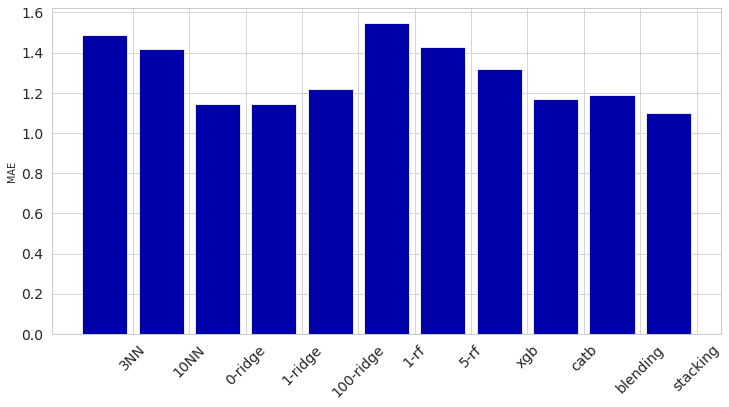

In [0]:
# Визуализация для сравнения
tmp = [('3NN', 1.49 ),
       ('10NN', 1.42),
       ('0-ridge', 1.1456),
       ('1-ridge', 1.1448),
       ('100-ridge', 1.2185),
       ('1-rf', 1.546),
       ('5-rf', 1.427),
       ('xgb', 1.32),
       ('catb', 1.167),
       ('blending',  1.19),
       ('stacking', 1.1)]


xticks = [x[0] for x in tmp]
#  aucs = [x[1] for x in tmp]
maes = [x[1] for x in tmp]

plt.figure(figsize=(12, 6))
#plt.bar(np.arange(len(aucs)), aucs, color='#0000AA', label=u'алгоритмы')
#plt.xticks(np.arange(len(aucs))+0.5, xticks, rotation=45)

plt.bar(np.arange(len(maes)), maes, color='#0000AA', label=u'алгоритмы')
plt.xticks(np.arange(len(maes))+0.5, xticks, rotation=45)
plt.ylabel('MAE')

In [0]:
%%time
# Несколько блэндингов подряд 
# models = [knn3, knn5, knn10, rg0, rg1, rg2, rf1, rf2, rf3]
ens_model = Ridge(0.001)
s1 = DjStacking(models, ens_model)
a = 0
e = []
for t in range(10):
    s1.fit(train_X, train_y, p=0.4)
    # a += s1.predict(test_X, train_y) если  AUC
    a = s1.predict(test_X, train_y)
    mae = mean_absolute_error(test_y, a)
    print (mae)
    e.append(mae)

1.1450932614488956
1.1449754527534075
1.1449339597997035
1.1449003552072097
1.144967976776968
1.1449538798569683


KeyboardInterrupt: ignored

CPU times: user 30.6 ms, sys: 1.01 ms, total: 31.6 ms
Wall time: 32.4 ms


findfont: Font family ['Vernada'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Vernada'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Vernada'] not found. Falling back to DejaVu Sans.


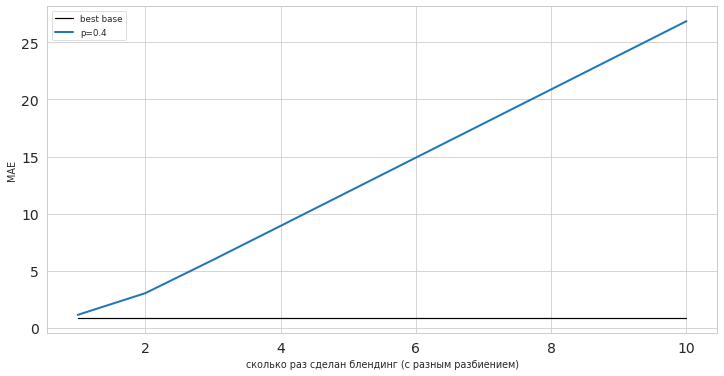

In [0]:
%%time
e4 = e
plt.figure(figsize=(12, 6))
plt.plot(np.arange(1,11), 0.900175155867 + 0*np.arange(1,11), c='black', label='best base')
#plt.plot(np.arange(1,11), e1, label='p=0.1', lw=2)
#plt.plot(np.arange(1,11), e2, label='p=0.2', lw=2)
#plt.plot(np.arange(1,11), e3, label='p=0.3', lw=2)
plt.plot(np.arange(1,11), e4, label='p=0.4', lw=2)
plt.xlabel(u'сколько раз сделан блендинг (с разным разбиением)')
plt.ylabel('MAE')
plt.legend()

In [0]:
# Варьируем число фолдов 

# models = [knn3, knn5, knn10, rg0, rg1, rg2, rf1, rf2, rf3]
ens_model = Ridge(0.001)

s1 = DjStacking(models, ens_model)
a = 0
e = []
for t in range(2, 11):
    s1.fit(train_X, train_y, p=-1, cv=t, err=0.00)
    a = s1.predict(test_X, train_y)
    mae = mean_absolute_error(test_y, a)
    print (mae)
    e.append(mae)

In [0]:
e1 = e
plt.figure(figsize=(12, 6))
plt.plot(np.arange(2,11), 0.900175155867 + 0*np.arange(2,11), c='black', label='best base')
plt.plot(np.arange(2,11), e1, label='err=0.0', lw=2)
#plt.plot(np.arange(2,11), e3, label='err=0.01', lw=2)
plt.plot(np.arange(2,11), e2, label='err=0.03', lw=2)
# plt.plot(np.arange(2,11), e4, label='p=0.4', lw=2)
plt.xlabel(u'число фолдов')
plt.ylabel('MAE')
plt.legend()

In [0]:
# Визуализация для сравнения
tmp = [('3NN', ),
       ('5NN', ),
       ('10NN', 0.874500610889),
       ('0-ridge', 0.883067503586),
       ('1-ridge', 0.883065725807),
       ('10-ridge', 0.88306217025),
       ('1-rf', 0.773247232554),
       ('3-rf', 0.878800390578),
       ('5-rf', 0.893922841743),
       ('blending', 0.893879508391),
       ('stacking', 0.89432173081)]


xticks = [x[0] for x in tmp]
#  aucs = [x[1] for x in tmp]
maes = [x[1] for x in tmp]

plt.figure(figsize=(12, 6))
#plt.bar(np.arange(len(aucs)), aucs, color='#0000AA', label=u'алгоритмы')
#plt.xticks(np.arange(len(aucs))+0.5, xticks, rotation=45)

plt.bar(np.arange(len(maes)), maes, color='#0000AA', label=u'алгоритмы')
plt.xticks(np.arange(len(maes))+0.5, xticks, rotation=45)

plt.bar([9, 10], [0.891809729693, 0.890628395835], color='#AA0000', label=u'после удаления лучшего')


plt.xlim([0, 11])
plt.ylim([0.75, 0.9])
plt.ylabel('MAE')
plt.legend(loc=3)

#### 16 may stacking (lightgbm, xgboost, catboost , ridge)
(with tags_freq_log)

In [0]:

train_X, test_X, train_y, test_y = train_test_split(X_train_sparse_with_author_1k, y_train_df, train_size=0.7, random_state=17)


In [0]:
%%time
rg0 = Ridge(alpha=0.01, random_state=17)
rg0.fit(train_X, train_y)
run_and_plot(rg0, test_X, test_y, 'ridge-0.01')


ridge-0.01 MAE  = 1.1420818101682622
CPU times: user 27.2 s, sys: 86.2 ms, total: 27.3 s
Wall time: 27.3 s


In [0]:
# сохраним модели
from sklearn.externals import joblib

In [0]:
%%time
joblib.dump(lgbm_ho, "lgbm_tag_freq_log.pkl")


CPU times: user 98.3 ms, sys: 8.01 ms, total: 106 ms
Wall time: 108 ms


['lgbm_tag_freq_log.pkl']

In [0]:
joblib.dump(xgb_ho, "xgb_ho_tag_freq_log.pkl")
joblib.dump(catboost_hyper, "cb_hyper(v3)_tag_freq_log.pkl")

['cb_hyper(v3)_tag_freq_log.pkl']

In [0]:
%%time
# Запускаем блэндинг и стэкинг без лесов 
models = [rg0, lgbm_ho, xgb_ho, catboost_hyper ] # rf1, rf2, # , rf3 
ens_model = Ridge()
s1 = DjStacking(models, ens_model)
s1.fit(train_X, train_y)
run_and_plot(s1, test_X, test_y, '1-stacking') # 1ый стэкинг

Streaming output truncated to the last 5000 lines.
4:	learn: 1.7374780	total: 974ms	remaining: 16m 12s
5:	learn: 1.7197579	total: 1.13s	remaining: 15m 40s
6:	learn: 1.7057174	total: 1.31s	remaining: 15m 33s
7:	learn: 1.6937979	total: 1.5s	remaining: 15m 35s
8:	learn: 1.6826317	total: 1.66s	remaining: 15m 20s
9:	learn: 1.6705572	total: 1.85s	remaining: 15m 26s
10:	learn: 1.6622063	total: 2.01s	remaining: 15m 13s
11:	learn: 1.6546941	total: 2.21s	remaining: 15m 18s
12:	learn: 1.6473296	total: 2.4s	remaining: 15m 19s
13:	learn: 1.6418481	total: 2.55s	remaining: 15m 9s
14:	learn: 1.6358828	total: 2.73s	remaining: 15m 5s
15:	learn: 1.6300315	total: 2.91s	remaining: 15m 7s
16:	learn: 1.6255742	total: 3.07s	remaining: 15m
17:	learn: 1.6210756	total: 3.23s	remaining: 14m 55s
18:	learn: 1.6171660	total: 3.37s	remaining: 14m 44s
19:	learn: 1.6123918	total: 3.52s	remaining: 14m 36s
20:	learn: 1.6086557	total: 3.69s	remaining: 14m 34s
21:	learn: 1.6039938	total: 3.89s	remaining: 14m 39s
22:	learn:

In [0]:
%%time
# 2ой стэкинг
s2 = DjStacking(models, ens_model)
s2.fit(train_X, train_y, p=-1)
run_and_plot(s2, test_X, test_y, '2-stacking') 
# >27 min 

Streaming output truncated to the last 5000 lines.
2:	learn: 1.7812872	total: 745ms	remaining: 20m 40s
3:	learn: 1.7571631	total: 993ms	remaining: 20m 40s
4:	learn: 1.7370601	total: 1.24s	remaining: 20m 35s
5:	learn: 1.7197806	total: 1.45s	remaining: 20m 8s
6:	learn: 1.7058511	total: 1.68s	remaining: 19m 58s
7:	learn: 1.6947580	total: 1.89s	remaining: 19m 39s
8:	learn: 1.6843838	total: 2.11s	remaining: 19m 29s
9:	learn: 1.6751473	total: 2.3s	remaining: 19m 7s
10:	learn: 1.6682395	total: 2.49s	remaining: 18m 49s
11:	learn: 1.6624775	total: 2.71s	remaining: 18m 45s
12:	learn: 1.6558088	total: 2.94s	remaining: 18m 46s
13:	learn: 1.6485895	total: 3.15s	remaining: 18m 42s
14:	learn: 1.6431076	total: 3.36s	remaining: 18m 37s
15:	learn: 1.6383634	total: 3.56s	remaining: 18m 29s
16:	learn: 1.6330011	total: 3.8s	remaining: 18m 33s
17:	learn: 1.6278843	total: 4s	remaining: 18m 28s
18:	learn: 1.6237204	total: 4.19s	remaining: 18m 19s
19:	learn: 1.6196750	total: 4.38s	remaining: 18m 10s
20:	learn:

In [0]:
joblib.dump(s2, "s2_stacking.pkl")

['s2_stacking.pkl']

## Старые модели

In [0]:
def best_model_m_xy (X_train, X_holdout, y_train, y_holdout, inmodel):
    # X_train, X_holdout, y_train, y_holdout = train_test_split(X, y, test_size=0.3,random_state=17)
    
    if inmodel == 'LinearRegression':      
      # LinearRegression
      model = LinearRegression()
      model_params = {'normalize' : [True, False]}
      model_grid = GridSearchCV(model, model_params, cv=5, n_jobs=-1,verbose= 0)
      model_grid.fit(X_train, y_train)

    if inmodel == 'Ridge':
      # Ridge
      model = Ridge()
      model_params = {'alpha': np.arange(1,4,0.1),'normalize' : [True, False]}
      model_grid = GridSearchCV(model, model_params, cv=5, n_jobs=-1,verbose= 0)
      model_grid.fit(X_train, y_train)
    
    if inmodel == 'Lasso':
      # Lasso
      model = Lasso()
      model_params = {'alpha': np.arange(1,4,0.1), 'normalize' : [True, False]}
      model_grid = GridSearchCV(model, model_params, cv=5, n_jobs=-1,verbose= 0)
      model_grid.fit(X_train, y_train)              
    
    if inmodel == 'RidgeCV':
      # RidgeCV
      model = RidgeCV()
      model_params = {'normalize' : [True, False]}
      model_grid = GridSearchCV(model, model_params, cv=5, n_jobs=-1,verbose= 0)
      model_grid.fit(X_train, y_train)

    if inmodel == 'LassoCV':
      # LassoCV
      model = LassoCV()
      model_params = {'normalize' : [True, False]}
      model_grid = GridSearchCV(model, model_params, cv=5, n_jobs=-1,verbose= 0)
      model_grid.fit(X_train, y_train) 
    
    if inmodel == 'RFR':  
      # RFR 
      model = RandomForestRegressor()
      model_params = {'max_depth': range(1,5),
                      'max_features': range(1,10)
                      } # по кол-ву признаков
      model_grid = GridSearchCV(model, model_params, cv=5, n_jobs=-1, verbose=True)
      model_grid.fit(X_train, y_train)
    
    if inmodel == 'GRB':  
      # GRB
      model = GradientBoostingRegressor()
      model_params = {'loss': ['ls', 'lad']} #, 'criterion': ["mae"]} 
      model_grid = GridSearchCV(model, model_params, cv=5, n_jobs=-1, verbose=True)
      model_grid.fit(X_train, y_train)
        
    result = pd.DataFrame()    
    result = pd.DataFrame({
                        "Best parameters":[model_grid.best_params_],
                        #"RMSE": np.sqrt(mean_squared_error(y_holdout,model_grid.predict(X_holdout))),
                        "MAE": mean_absolute_error(y_holdout, model_grid.predict(X_holdout)),
                        #"Score model": model_grid.best_score_,
                        "Method": str(type(model)).split('.')[-1].replace("'>",'') 
                       }) 
    return result

In [0]:
# Старая ф-ция
def best_model_m (df, inmodel):
    X = df.drop(columns = 'target') # target - MAE 3.06 # target_log - MAE 3.15
    y = df['target']  # 'target' - MAE 3.06 # target_log - MAE 3.15
    X_train, X_holdout, y_train, y_holdout = train_test_split(X.values, y, test_size=0.3,random_state=17)
    
    if inmodel == 'LinearRegression':      
      # LinearRegression
      model = LinearRegression()
      model_params = {'normalize' : [True, False]}
      model_grid = GridSearchCV(model, model_params, cv=5, n_jobs=-1,verbose= 0)
      model_grid.fit(X_train, y_train)

    if inmodel == 'Ridge':
      # Ridge
      model = Ridge()
      model_params = {'alpha': np.arange(1,4,0.1),'normalize' : [True, False]}
      model_grid = GridSearchCV(model, model_params, cv=5, n_jobs=-1,verbose= 0)
      model_grid.fit(X_train, y_train)
    
    if inmodel == 'Lasso':
      # Lasso
      model = Lasso()
      model_params = {'alpha': np.arange(1,4,0.1), 'normalize' : [True, False]}
      model_grid = GridSearchCV(model, model_params, cv=5, n_jobs=-1,verbose= 0)
      model_grid.fit(X_train, y_train)              
    
    if inmodel == 'RidgeCV':
      # RidgeCV
      model = RidgeCV()
      model_params = {'normalize' : [True, False]}
      model_grid = GridSearchCV(model, model_params, cv=5, n_jobs=-1,verbose= 0)
      model_grid.fit(X_train, y_train)

    if inmodel == 'LassoCV':
      # LassoCV
      model = LassoCV()
      model_params = {'normalize' : [True, False]}
      model_grid = GridSearchCV(model, model_params, cv=5, n_jobs=-1,verbose= 0)
      model_grid.fit(X_train, y_train) 
    
    if inmodel == 'RFR':  
      # RFR 
      model = RandomForestRegressor()
      model_params = {'max_depth': range(1,5),
                      'max_features': range(1,10)
                      } # по кол-ву признаков
      model_grid = GridSearchCV(model, model_params, cv=5, n_jobs=-1, verbose=True)
      model_grid.fit(X_train, y_train)
    
    if inmodel == 'GRB':  
      # GRB
      model = GradientBoostingRegressor()
      model_params = {'loss': ['ls', 'lad']} #, 'criterion': ["mae"]} 
      model_grid = GridSearchCV(model, model_params, cv=5, n_jobs=-1, verbose=True)
      model_grid.fit(X_train, y_train)
        
    result = pd.DataFrame()    
    result = pd.DataFrame({
                        "Best parameters":model_grid.best_params_,
                        "RMSE": np.sqrt(mean_squared_error(y_holdout,model_grid.predict(X_holdout))),
                        "MAE": mean_absolute_error(y_holdout, model_grid.predict(X_holdout)),
                        "Score model": model_grid.best_score_,
                        "Method": str(type(model)).split('.')[-1].replace("'>",'') 
                       }) 
    return result

In [0]:
# best_model_m (df_model, 'LinearRegression')

In [0]:
# best_model_m (df_model, 'Ridge')

In [0]:
# best_model_m (df_model, 'Lasso')

In [0]:
# best_model_m (df_model, 'RidgeCV')

In [0]:
# best_model_m (df_model, 'LassoCV')

In [0]:
# best_model_m (df_model, 'GRB')

In [0]:
# best_model_m (df_model, 'RFR')

# Работа с тестовой выборкой и выгрузка результата

In [0]:
df_test = pd.read_csv(PATH+'test.csv', index_col = 0)
df_test.head()

,content,published,title,author,domain,tags,length,url,dow,year,month,hour,number_of_tags
0,Member previewHITRECORDhitrecord.org is a new ...,2018-02-21 17:01:00.928,"For Night Owls, the Day Starts with a Nocturna...",HITRECORD,medium.com,MorningRoutines Hitrecord Podcast Night,12500,https://medium.com/on-mornings/nocturnalmornin...,2,2018,2,17,4
1,Member previewMaria Bustillosis a journalist a...,2017-12-07 15:56:00.967,Blockchain is Memory,Maria Bustillos,medium.com,Blockchain Technology History Network WordsTha...,6703,https://medium.com/wordsthatmatter/never-break...,3,2017,12,15,5
2,HITRECORDhitrecord.org is a new kind of online...,2018-02-08 17:33:27.816,ON MORNINGS Credits,HITRECORD,medium.com,Medium Hitrecord OnMornings,6744,https://medium.com/on-mornings/onmorningscredi...,3,2018,2,17,3
3,"Member previewLance UlanoffTech expert, journa...",2018-02-09 18:04:12.262,Apple HomePod Review: Almost love,Lance Ulanoff,medium.com,Apple Homepod Technology Review Audio,12952,https://medium.com/@LanceUlanoff/apple-homepod...,4,2018,2,18,5
4,"MediumEveryone’s stories and ideasOct 2, 2017T...",2017-10-02 23:08:00.000,Tips and tricks for Medium writers,Medium,blog.medium.com,Medium Help Tips,5576,https://blog.medium.com/tips-and-tricks-for-me...,0,2017,10,23,3


In [0]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 34645 entries, 0 to 34644
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   content         34645 non-null  object
 1   published       34645 non-null  object
 2   title           34645 non-null  object
 3   author          34645 non-null  object
 4   domain          34645 non-null  object
 5   tags            34011 non-null  object
 6   length          34645 non-null  int64 
 7   url             34645 non-null  object
 8   dow             34645 non-null  int64 
 9   year            34645 non-null  int64 
 10  month           34645 non-null  int64 
 11  hour            34645 non-null  int64 
 12  number_of_tags  34645 non-null  int64 
dtypes: int64(6), object(7)
memory usage: 3.7+ MB


In [0]:
df_test['published'] = pd.to_datetime(df_test['published'])

In [0]:
# Информация по фичам (название, кол-во пропущенных значений, число унивкальных значений, питонячий тип)
pd.DataFrame({'Feature': df_test.columns.tolist(),
              'NaN_count': df_test.isna().sum().tolist(),
              'number_of_unique_elements': pd.Series(df_test.columns.tolist()).apply(lambda row: df_test[row].nunique()),
              'type': pd.Series(df_test.columns.tolist()).apply(lambda row: df_test[row].dtype)})

,Feature,NaN_count,number_of_unique_elements,type
0,content,0,34640,object
1,published,0,34565,datetime64[ns]
2,title,0,34418,object
3,author,0,18395,object
4,domain,0,65,object
5,tags,634,32744,object
6,length,0,14284,int64
7,url,0,34630,object
8,dow,0,7,int64
9,year,0,2,int64


In [0]:
# выделим сезонность 
seasons = {'winter': (1, 2, 12),
           'spring': (3, 4, 5),
           'summer': (6, 7, 8),
           'autumn': (9, 10, 11)}

In [0]:
df_test['season'] = df_test['month'].map({1: 'winter', 2: 'winter', 3: 'spring', 4: 'spring', 5: 'spring', 6: 'summer', 7: 'summer', 8: 'summer', 9: 'autumn', 10: 'autumn', 11: 'autumn', 12: 'winter'})

In [0]:
df_test['dayofweek'] = df_test.iloc[:,1].apply(get_day_of_the_week)

In [0]:
df_test['dayofweek'] = df_test['dayofweek'].map({1: 'monday', 2: 'tuesday', 3: 'wednesday', 4: 'thursday', 5: 'friday', 6: 'saturday', 7: 'sunday'})

In [0]:
df_test['partofday'] = df_test['hour'].map({0: 'night', 1: 'night', 2: 'night',
                                  3: 'night', 4: 'night', 5: 'morning',
                                  6: 'morning', 7: 'morning', 8: 'morning',
                                  9: 'morning', 10: 'morning', 11: 'morning',
                                  12: 'afternoon', 13: 'afternoon', 14: 'afternoon',
                                  15: 'afternoon', 16: 'afternoon', 17: 'afternoon',
                                  18: 'evening', 19: 'evening', 20: 'evening',
                                  21: 'evening', 22: 'evening', 23: 'evening'})

In [0]:
df_test.domain.value_counts()

medium.com                      32079
hackernoon.com                   2429
towardsdatascience.com             17
blog.usejournal.com                 9
journal.thriveglobal.com            7
                                ...  
blog.web3.ventures                  1
blog.messengerdevelopers.com        1
lifeform.pl                         1
betterhumans.coach.me               1
democracyguardian.com               1
Name: domain, Length: 65, dtype: int64

In [0]:
# Добавим признак - домен=medium.com/hackernoon?
df_test['domain_top'] = df_test['domain'].apply(domain_get)

In [0]:
df_test.domain_top.value_counts()

medium        32079
hackernoon     2429
others          137
Name: domain_top, dtype: int64

In [0]:
# Добавим кол-во статей у автора
# get_author_cnt_articles (df_test)

In [0]:
# df_test['author_cnt_article'].hist()

In [0]:
df_test['author_wo_space'] = df_test['author'].str.replace(' ', '')

In [0]:
df_test.head(5)

,content,published,title,author,domain,tags,length,url,dow,year,month,hour,number_of_tags,season,dayofweek,partofday,domain_top,author_wo_space
0,Member previewHITRECORDhitrecord.org is a new ...,2018-02-21 17:01:00.928,"For Night Owls, the Day Starts with a Nocturna...",HITRECORD,medium.com,MorningRoutines Hitrecord Podcast Night,12500,https://medium.com/on-mornings/nocturnalmornin...,2,2018,2,17,4,winter,wednesday,afternoon,medium,HITRECORD
1,Member previewMaria Bustillosis a journalist a...,2017-12-07 15:56:00.967,Blockchain is Memory,Maria Bustillos,medium.com,Blockchain Technology History Network WordsTha...,6703,https://medium.com/wordsthatmatter/never-break...,3,2017,12,15,5,winter,thursday,afternoon,medium,MariaBustillos
2,HITRECORDhitrecord.org is a new kind of online...,2018-02-08 17:33:27.816,ON MORNINGS Credits,HITRECORD,medium.com,Medium Hitrecord OnMornings,6744,https://medium.com/on-mornings/onmorningscredi...,3,2018,2,17,3,winter,thursday,afternoon,medium,HITRECORD
3,"Member previewLance UlanoffTech expert, journa...",2018-02-09 18:04:12.262,Apple HomePod Review: Almost love,Lance Ulanoff,medium.com,Apple Homepod Technology Review Audio,12952,https://medium.com/@LanceUlanoff/apple-homepod...,4,2018,2,18,5,winter,friday,evening,medium,LanceUlanoff
4,"MediumEveryone’s stories and ideasOct 2, 2017T...",2017-10-02 23:08:00.000,Tips and tricks for Medium writers,Medium,blog.medium.com,Medium Help Tips,5576,https://blog.medium.com/tips-and-tricks-for-me...,0,2017,10,23,3,autumn,monday,evening,others,Medium


In [0]:
df_test_model = data_prepared(df_test, True)
df_test_model.head()

,season_autumn,season_spring,season_summer,season_winter,dayofweek_friday,dayofweek_monday,dayofweek_saturday,dayofweek_sunday,dayofweek_thursday,dayofweek_tuesday,dayofweek_wednesday,partofday_afternoon,partofday_evening,partofday_morning,partofday_night,domain_top_hackernoon,domain_top_medium,domain_top_others,length,number_of_tags
0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0.360817,-0.423739
1,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,1,0,-0.342825,0.471847
2,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,1,0,-0.337848,-1.319325
3,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0.415681,0.471847
4,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,-0.479620,-1.319325


In [0]:
tags_test = df_test['tags'].values.astype('U').tolist()

In [0]:
df_test[df_test['tags'] == np.nan]

,content,published,title,author,domain,tags,length,url,dow,year,month,hour,number_of_tags,season,partofday,dayofweek,domain_top


In [0]:
# обработаем тэги через countvectorizer 
X_test_tags = cv_tags.transform(tags_test)

In [0]:
title_test = df_test['title'].values.tolist() 
content_test = df_test['content'].values.tolist()
author_test = df_test['author_wo_space'].values.tolist()

In [0]:
X_test_title = cv_title.transform(title_test) 
X_test_content = cv_content.transform(content_test) 
X_test_author = cv_author.transform(author_test)

In [0]:
X_test_sparse = csr_matrix(hstack([X_test_tags, X_test_title, X_test_content, X_test_author, df_test_model.values]))

In [0]:
X_test_sparse.shape

(34645, 4020)

In [0]:
X_train_sparse.shape

NameError: ignored

### Запись результата

In [0]:
# запись рез-та
def write_submission_file(prediction, path_to_sample=PATH+'sample_submission.csv'):
    submission = pd.read_csv(path_to_sample, index_col='id')
    submission['log_recommends'] = prediction 
    submission.to_csv('submission.csv')

In [0]:
# catboost 
prediction = catboost_r.predict(X_test_sparse)
write_submission_file(prediction)

In [0]:
# stack
prediction = st_ens_with_catb.predict(X_test_sparse)
write_submission_file(prediction)

In [0]:
# model Catboost HyperOpt
prediction = catboost_hyper.predict(X_test_sparse)
write_submission_file(prediction)